# **Starbucks Customer Segmentation**


## **1. Business Objective** 

This is a customer segmentation problem for different types of advertisements on the Starbucks rewards mobile app. Customers respond differently to various types of promotions, so there is no 1 promotion type that is universally best for all customers. With a better understanding of customer behavior, Starbucks would be able to optimize how advertisements are sent to their customers.

The purpose of this project is to segment demographic groups based on how customers respond best to which offer type. This project will also include a classifier that predicts whether or not someone will respond to an offer.

## **2. Data Collection**

The dataset has been obtained from Udacity Capstone Challenge.

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. This is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks and not all users receive the same offer.

The data is contained in three files:

1.   portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
2.   profile.json - demographic data for each customer 
3.   transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:
1. portfolio.json
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

2. profile.json

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

3. transcript.json

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Moreover, some further information given about the offers is that there are 3 different offer types:

* BOGO - buy one get one free
* Discount - discount with purchase
* Informational - provides information about products


In [2]:
# Connecting to Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [334]:
# Importing sklearn libraries needed

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

from imblearn.over_sampling import SMOTE, ADASYN
from bayes_opt import BayesianOptimization
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, RootMeanSquaredError

In [6]:
import re
import ast
from wordcloud import WordCloud, STOPWORDS
import pickle
import json
import joblib

## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [7]:
# Loading the dataset

file_path = "/content/drive/My Drive/Colab Datasets/Starbucks"

portfolio = pd.read_json(file_path + "/portfolio.json", orient="records", lines=True)
profile = pd.read_json(file_path + "/profile.json", orient="records", lines=True)
transcript = pd.read_json(file_path + "/transcript.json", orient="records", lines=True)

In [8]:
# Checking the features and no. of records in the portfolio dataset

print("The number of records are : ", portfolio.shape[0])
print("The number of features are : ", portfolio.shape[1])
print("The list of features is : ", portfolio.columns)
portfolio.head()

The number of records are :  10
The number of features are :  6
The list of features is :  Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')


reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [9]:
# Checking the features and no. of records in the profile dataset.

print("The number of records are : ", profile.shape[0])
print("The number of features are : ", profile.shape[1])
print("The list of features is : ", profile.columns)
profile.head()

The number of records are :  17000
The number of features are :  5
The list of features is :  Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')


gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [10]:
# Checking the features and no. of records in the profile dataset.

print("The number of records are : ", transcript.shape[0])
print("The number of features are : ", transcript.shape[1])
print("The list of features is : ", transcript.columns)
transcript.head()

The number of records are :  306534
The number of features are :  4
The list of features is :  Index(['person', 'event', 'value', 'time'], dtype='object')


person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

### **3.1 Data Cleaning**

We will begin with data cleaning such that we can handle missing values, outliers, rare values and drop the unnecessary features that do not carry useful information.


In [11]:
# checking for duplicates

print("No. of duplicates records in the portfolio dataset : ", portfolio.columns.duplicated().sum())
print("No. of duplicates records in the profile dataset : ", profile.columns.duplicated().sum())
print("No. of duplicates records in the transcript dataset : ", transcript.columns.duplicated().sum())

No. of duplicates records in the portfolio dataset :  0
No. of duplicates records in the profile dataset :  0
No. of duplicates records in the transcript dataset :  0


##### Observations:
1. There are no duplicate records in either of the three datasets.

In [12]:
# Checking the columns' titles and datatypes

portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [13]:
# Checking the columns' titles and datatypes

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


##### Observations:
1. There are some missing values in the features "gender" and "income" which we need to handle ahead.

In [14]:
# Checking the columns' titles and datatypes

transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


#### **3.1.1 Handling Missing Values**

Identifying the features that have some missing values and imputing them.

In [15]:
# Checking the number of missing values in profile data

profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [16]:
# Checking the feature "gender"

profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

##### Observations:
1. There are three values: Males, Females and Others.
2. Males have the highest representation.

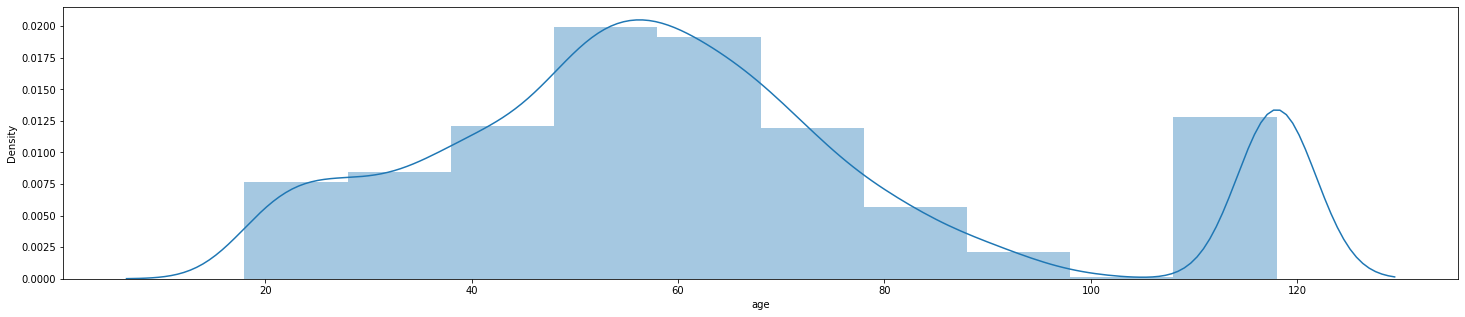

In [17]:
# Checking the feature "age"

sns.distplot(profile["age"], bins=10)

##### Observations:
1. The end of the distribution seems suspicious as it doesn't follows the distribution.

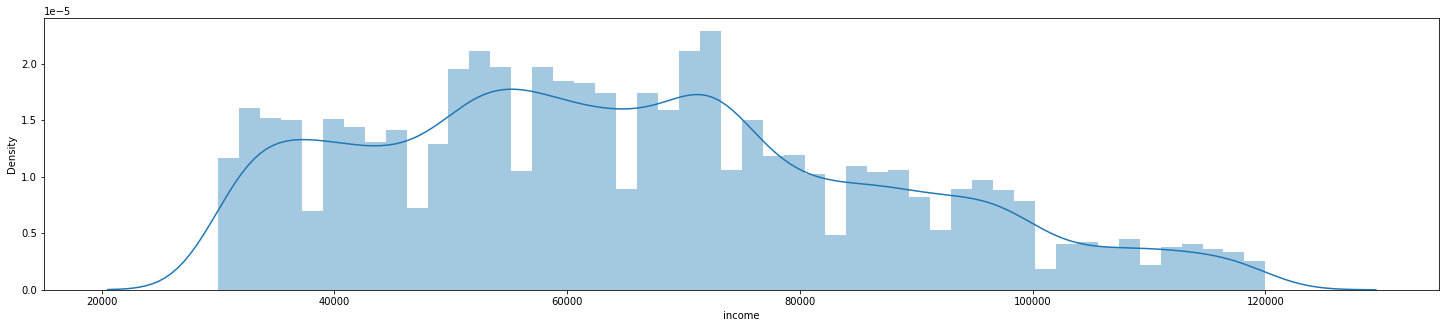

In [18]:
# Checking the feature "income"

sns.distplot(profile["income"], bins=50)

In [19]:
# creating a dataframe with missing values

df_missing_values = profile[(profile["gender"].isnull()) | (profile["income"].isnull())]
df_missing_values.head()

gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7   None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN

In [20]:
# Checking the age for the missing values 

df_missing_values["age"].value_counts()

118    2175
Name: age, dtype: int64

In [21]:
# Checking the became_member_on for the missing values 

df_missing_values["became_member_on"].value_counts()

20170901    11
20171002     9
20170928     8
20171126     8
20170907     8
            ..
20160625     1
20160122     1
20140205     1
20160701     1
20160512     1
Name: became_member_on, Length: 950, dtype: int64

##### Observations:
1. Looks like some of the customers did not provide their information while creating their account due to which their age might have been replaced with default age of 118.

2. Since the records have gender, income and age as missing, their is not many benefits of imputing values as it might carry the original information. So it would be safe for us to drop these records all togeher.

In [22]:
# Dropping the records with values missing for gender and income, and then resetting the index

profile.dropna(subset=["gender", "income"], inplace=True)
profile.reset_index(inplace = True, drop = True)

In [23]:
# Checking the number of missing values in profile data

profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

#### **3.1.2 Checking for Outliers**

Checking for outliers and removing them.

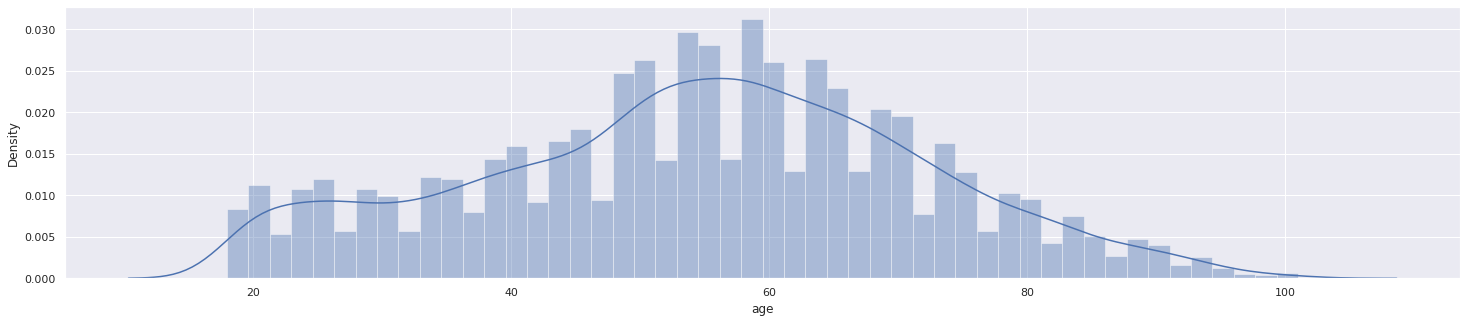

In [24]:
# Checking the feature "age"

sns.set(style="darkgrid")
sns.distplot(profile["age"], bins=50)

##### Observations:
1. We can see that the distribution has been corrected as we dropped the rows with missing values.

### **3.2 Exploratory Data Analysis**

After the data cleaning steps, we can now perform EDA on the dataset to discover patterns and relationships that will help in understanding the data better.

### **3.2.1 Univariate Analysis**

Analyzing each feature inidividually to gain insights from the data and discover any outliers.

---

##### Portfolio Dataset

In [25]:
# Checking the feature "id" in portfolio

portfolio["id"].value_counts()

2298d6c36e964ae4a3e7e9706d1fb8c2    1
ae264e3637204a6fb9bb56bc8210ddfd    1
fafdcd668e3743c1bb461111dcafc2a4    1
3f207df678b143eea3cee63160fa8bed    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
2906b810c7d4411798c6938adc9daaa5    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
f19421c1d4aa40978ebb69ca19b0e20d    1
5a8bc65990b245e5a138643cd4eb9837    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
Name: id, dtype: int64

##### Observations:
1. There are 10 unique offers in the portfolio of Starbucks.

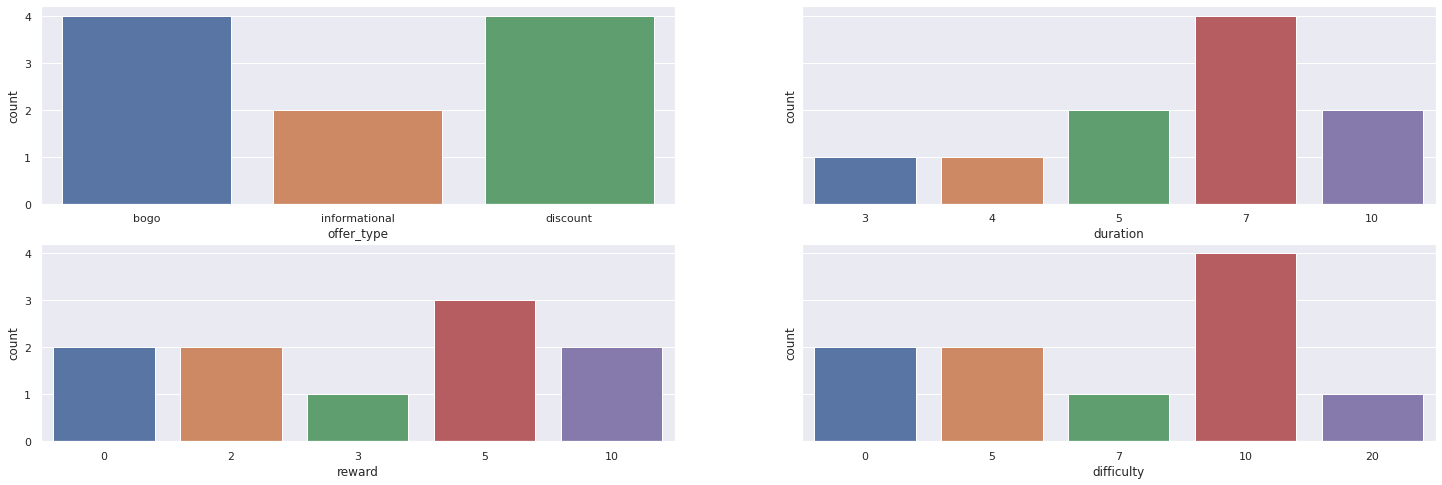

In [26]:
# Checking the feature "id" in portfolio

sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(25, 8), sharey=True)

sns.countplot("offer_type", data=portfolio, ax=axes[0][0])
sns.countplot("duration", data=portfolio, ax=axes[0][1])
sns.countplot("reward", data=portfolio, ax=axes[1][0])
sns.countplot("difficulty", data=portfolio, ax=axes[1][1])

##### Observations:
1. There are 3 offer types: BOGO(4), Discouny(4) and Informational(2).
2. The duration of the offers remains active from 3 to 10 days, with 7 days has the highest occurence with 4.
3. The reward lies from 0 to 10 dollars with $5 being the highest count with 3.

4. The difficulty lies from 0 to 20 dollars with $10 being the most frequent one. 

In [27]:
# Extracting channels from the portfolio dataset

channels_list = []
def ExtractChannelsFromPortfolio(x):
    for c in x:
        channels_list.append(c.strip())

In [28]:
# Filtering unique channels

portfolio["channels"].apply(ExtractChannelsFromPortfolio)
unique_channels = np.unique(channels_list)
unique_channels

array(['email', 'mobile', 'social', 'web'], dtype='<U6')

##### Observations:
1. There are 4 channels being used for targetting which are: Email, Mobile, Social and Web

---

##### Profile Dataset

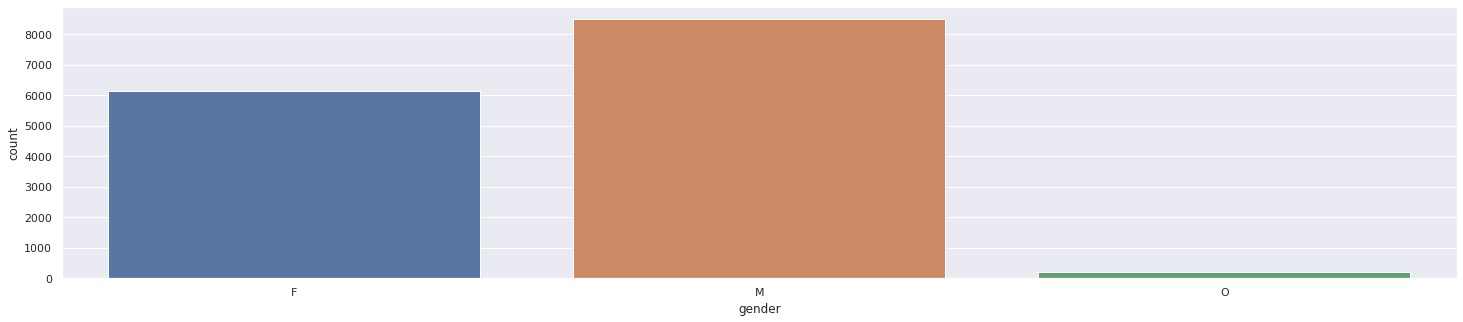

In [29]:
# Checking the feature "gender" in profile

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot("gender", data=profile, ax=axes)

##### Observations:
1. There are 3 gender values: Male, Female and Others with Males being in majority

The basic statistics for the feature are : 
 count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


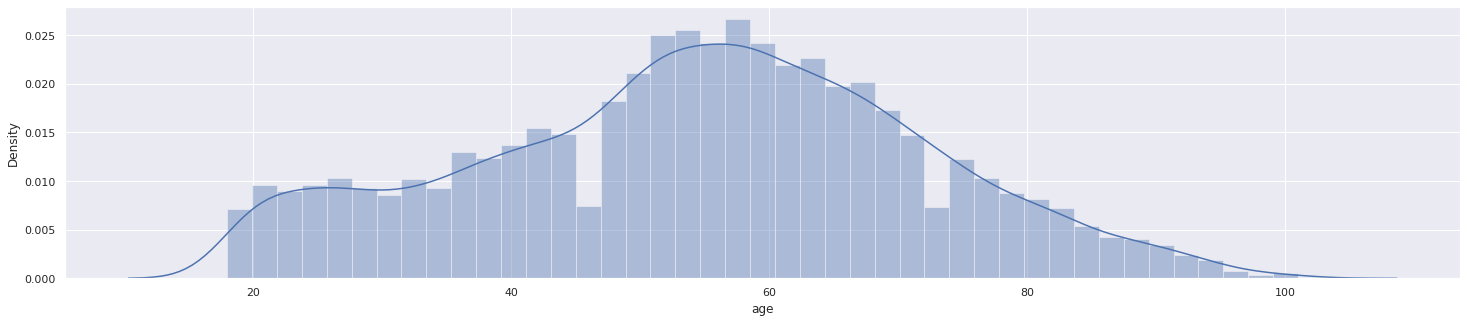

In [30]:
# Checking the feature "age" in profile

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

print("The basic statistics for the feature are : \n", profile["age"].describe())
sns.distplot(profile["age"], ax=axes)

##### Observations:
1. The value for "age" lies between 18 to 101, with mean and median being very close to each other as 55.
2. The distribution is also somewhat normal.

The basic statistics for the feature are : 
 count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


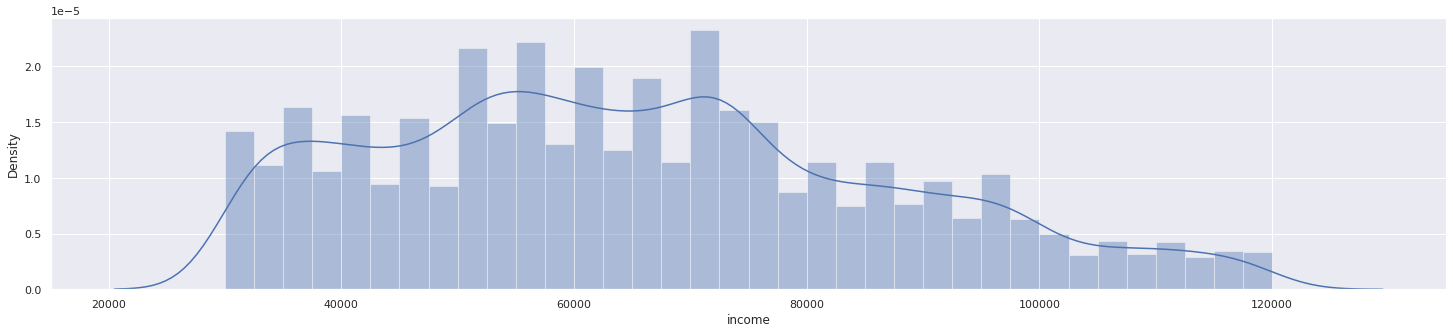

In [31]:
# Checking the feature "income" in profile

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

print("The basic statistics for the feature are : \n", profile["income"].describe())
sns.distplot(profile["income"], ax=axes)

##### Observations:
1. The continuous feature lies between 30K to 120K dollars with mean and median very close to each other at 65K.
2. The distribution looks somewhat normal with a wider variance.

In [32]:
# Checking the feature "became_member_on" in profile

profile["became_member_on"].value_counts()

20170819    39
20171007    37
20171207    36
20180125    35
20171010    34
            ..
20131121     1
20150608     1
20150624     1
20141023     1
20140305     1
Name: became_member_on, Length: 1707, dtype: int64

##### Observations:
1. There are 1707 unique values for dates on which the customers became members of Starbucks.
2. There will be a need to extract the dates from the dataset as it is "int" format.

In [33]:
# Checking the feature "id" in profile

profile["id"].value_counts()

42f2d7c55fe84b68bf9e743e8992fd8c    1
d122a4332290450fbecdca2d5e15ee0d    1
0b931f3c0c9049dd825fc371e4d759f9    1
072731be403a472883bed6c38a8e7aa8    1
7f4fc4cfd74a404a93b1a411cb906067    1
                                   ..
02eba2268a3640bb8e85880e12617c5f    1
2366b169d6de42f084c7a64c1b938f9d    1
277d5c3110104e278963d796465f45a8    1
8ca29d07b300474786a6016fe76174dd    1
6d28f18e91324d358d69d1e4b01f1ace    1
Name: id, Length: 14825, dtype: int64

##### Observations:
1. Each entry is unique which implies that there are 14825 unique customers in the dataset.

---

##### Transcript Dataset

In [34]:
# Checking the feature "person" in transcript

transcript["person"].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
                                    ..
df9fc9a86ca84ef5aedde8925d5838ba     2
fccc9279ba56411f80ffe8ce7e0935cd     2
3a4e53046c544134bb1e7782248631d1     2
22617705eec442e0b7b43e5c5f56fb17     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

##### Observations:
1. There are 17K unique customers which matches with the profile dataset.

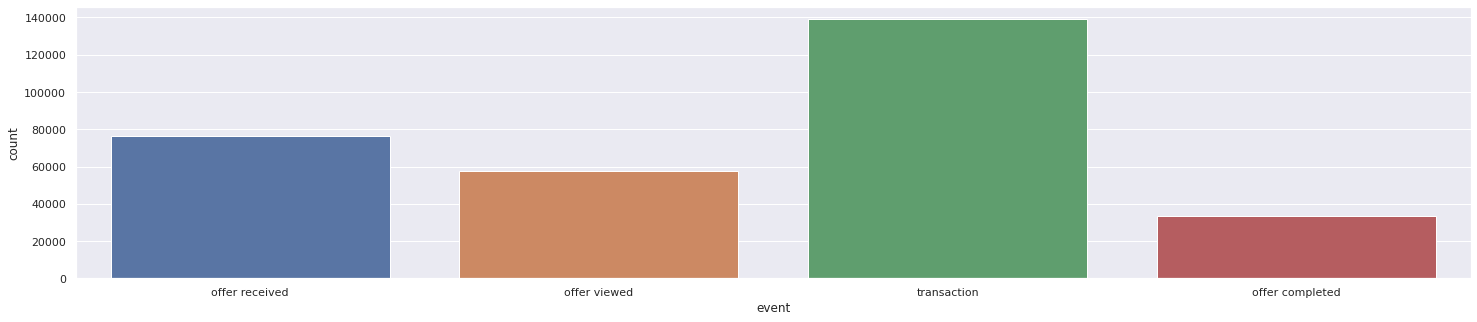

In [35]:
# Checking the feature "event" in transcript

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot("event", data=transcript, ax=axes)

##### Observations:
1. There are 4 types of Events: Offer received, offer viewed, transaction and offer completed.
2. Transaction is most frequent event type which means that customers tend to make transactions based on offers but may not have completed the offer.

The basic statistics for the feature are : 
 count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64


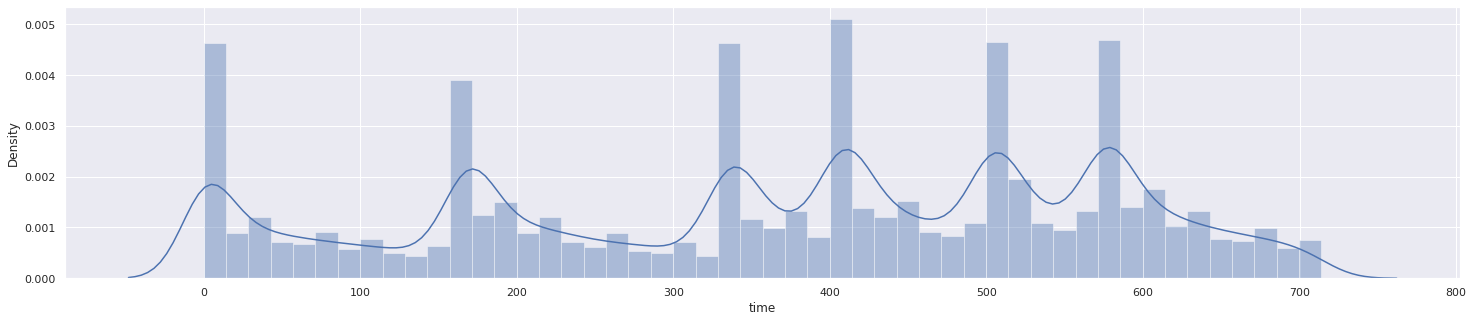

In [36]:
# Checking the feature "time" in transcript

transcript["time"].value_counts()

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

print("The basic statistics for the feature are : \n", transcript["time"].describe())
sns.distplot(transcript["time"], ax=axes)

##### Observations:
1. The time is provided in hours units and with multiple distribution.

In [37]:
# Checking the feature "value" in transcript data

transcript["value"]

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

##### Observations:
1. There are different values based on event type. We need to extract values from it as it contains the amount spent if event is transaction and offer types received.

### **3.2.2 Bi-variate Analysis**

Analyzing multiple features together to discover relations, correlations and patterns. 

In [38]:
# Adding Channels as features as part of preprocessing

channels_df = []
def ExtractChannelsAsFeatures(x):
    channels_array = np.ones(len(unique_channels))
    for idx, c in enumerate(unique_channels):
        if c not in x:
            channels_array[idx] = 0
    channels_df.append(channels_array)

In [39]:
# Concatenated the Channels as features in portfolio data

portfolio["channels"].apply(ExtractChannelsAsFeatures)
channels_df = pd.DataFrame(data=channels_df, columns=unique_channels)
portfolio = pd.concat([portfolio, channels_df], axis=1)

In [40]:
le_offer_id = LabelEncoder()

In [41]:
# drop the channels feature
portfolio.drop("channels", axis=1, inplace=True)

# rename offer_id column
portfolio.rename(columns = {"id" : "offer_id"}, inplace=True)

# Label Encoded the offer_ids for better readability
portfolio["offer_id"] = le_offer_id.fit_transform(portfolio["offer_id"])

portfolio.head()

reward  difficulty  duration     offer_type  offer_id  email  mobile  \
0      10          10         7           bogo         7    1.0     1.0   
1      10          10         5           bogo         4    1.0     1.0   
2       0           0         4  informational         3    1.0     1.0   
3       5           5         7           bogo         6    1.0     1.0   
4       5          20        10       discount         0    1.0     0.0   

   social  web  
0     1.0  0.0  
1     1.0  1.0  
2     0.0  1.0  
3     0.0  1.0  
4     0.0  1.0

In [42]:
# rename id column in profile data
profile.rename(columns = {"id" : "customer_id"}, inplace=True)

# Converting the became member on to date format
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"].astype(str))

# Label Encoding customer ids for better readability
le_customer_id = LabelEncoder()
profile["customer_id"] = le_customer_id.fit_transform(profile["customer_id"])

profile.head()

gender  age  customer_id became_member_on    income
0      F   55          346       2017-07-15  112000.0
1      F   75         6962       2017-05-09  100000.0
2      M   68        13107       2018-04-26   70000.0
3      M   65         3246       2018-02-09   53000.0
4      M   58         2669       2017-11-11   51000.0

In [43]:
# Creating a new dataframe based on dictionary values in value and concatenating with transcript

transcript = pd.concat([transcript, transcript["value"].apply(pd.Series)], axis=1)

In [44]:
# It appears as though the offer id column ended up being duplicates so we have to clean it up further to ensure there is only one offer id column

# create new feature to ensure only one offer_id column
transcript["offer_id_new"] = np.where(transcript["offer id"].isnull() & transcript["offer_id"].notnull(), transcript["offer_id"], transcript["offer id"])

# drop unnecessary offer_id columns
transcript.drop(["offer id", "offer_id", "value"], axis=1, inplace=True)

# rename offer_id column
transcript.rename(columns = {"offer_id_new" : "offer_id", "person" : "customer_id"}, inplace=True)

In [45]:
# Getting customer_id with no profiles

list_customer_with_no_profiles = list(set(transcript["customer_id"].tolist()) - set(le_customer_id.classes_.tolist()))

In [46]:
# Dropping samples from transcript for the customer id with no profiles

transcript = transcript[~transcript["customer_id"].isin(list_customer_with_no_profiles)].reset_index(drop=True)

In [47]:
# Label Encoding of customer_id

transcript["customer_id"] = le_customer_id.transform(transcript["customer_id"])

In [48]:
# Label Encoding of offer_id

def ReEncodeOfferID(x):
    if not pd.isnull(x):
        return le_offer_id.transform([x])[0]
    return x

transcript["offer_id"] = transcript["offer_id"].apply(ReEncodeOfferID)

In [49]:
# Missing counts for each event type

print('Overall event count:')
print(transcript["event"].value_counts())

for e in transcript["event"].unique():
    print(f'\nMissing values for event:', e)
    print(transcript[transcript["event"] == e].isnull().sum().iloc[2:5])

Overall event count:
transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

Missing values for event: offer received
time          0
amount    66501
reward    66501
dtype: int64

Missing values for event: offer viewed
time          0
amount    49860
reward    49860
dtype: int64

Missing values for event: transaction
time           0
amount         0
reward    123957
dtype: int64

Missing values for event: offer completed
time          0
amount    32444
reward        0
dtype: int64


##### Observations:
There is no problem with the missing values here:
- For "offer received" and "offer viewed" events: no transaction was made so there shouldn't be an amount and no reward was given so there shouldn't be a reward
- For "offer completed" events: no transaction was made so there shouldn't be an amount
- For "transaction" events: there is no offer corresponding to transactions so there shouldn't be an offer_id or a reward

In [50]:
# Filling the Nan values as 0

transcript["offer_id"].fillna(-1, inplace=True)
transcript["offer_id"] = transcript["offer_id"].astype('int64')
transcript["amount"].fillna(0, inplace=True)
transcript["reward"].fillna(0, inplace=True)

In [51]:
# Checking for any duplicate events

print('Duplicated events:', transcript.duplicated().sum())

Duplicated events: 374


In [52]:
# Duplicated events

dup_events = transcript[transcript.duplicated(keep=False)]
dup_events.head()

customer_id            event  time  amount  reward  offer_id
58685         3592  offer completed   168     0.0     2.0         2
58686         3592  offer completed   168     0.0     2.0         2
59266        13567  offer completed   168     0.0    10.0         7
59267        13567  offer completed   168     0.0    10.0         7
59990         9799  offer completed   168     0.0     5.0         6

In [53]:
# Duplicated event types

dup_events["event"].value_counts()

offer completed    747
Name: event, dtype: int64

##### Observations:
All 374 of the duplicated events were offers being completed. It is unlikely that the same user is completing the same offer type within the same hour, so these duplicates will be dropped. Even if they were actually separate events, this is only a very small portion of the event data, so losing them won't be a problem.

In [54]:
# Drop duplicate events

transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [55]:
transcript.head()

customer_id           event  time  amount  reward  offer_id
0         6962  offer received     0     0.0     0.0         6
1        13107  offer received     0     0.0     0.0         2
2         3246  offer received     0     0.0     0.0         8
3         2669  offer received     0     0.0     0.0         3
4         9940  offer received     0     0.0     0.0         0

##### **1. How many offers of each type were sent out?**


In [56]:
# join transcript with portfolio based on offer_id and filtering for only "offer received" events

received_offers = transcript.merge(portfolio, how='left', on='offer_id')
received_offers.rename(columns = {"reward_y" : "reward_offered", "reward_x" : "reward_received"}, inplace=True)
received_offers = received_offers[received_offers["event"] == "offer received"]
received_offers.head()

customer_id           event  time  amount  reward_received  offer_id  \
0         6962  offer received     0     0.0              0.0         6   
1        13107  offer received     0     0.0              0.0         2   
2         3246  offer received     0     0.0              0.0         8   
3         2669  offer received     0     0.0              0.0         3   
4         9940  offer received     0     0.0              0.0         0   

   reward_offered  difficulty  duration     offer_type  email  mobile  social  \
0             5.0         5.0       7.0           bogo    1.0     1.0     0.0   
1             2.0        10.0       7.0       discount    1.0     1.0     0.0   
2             5.0         5.0       5.0           bogo    1.0     1.0     1.0   
3             0.0         0.0       4.0  informational    1.0     1.0     0.0   
4             5.0        20.0      10.0       discount    1.0     0.0     0.0   

   web  
0  1.0  
1  1.0  
2  1.0  
3  1.0  
4  1.0

In [57]:
# Checking count of different offer types within the different events

received_offers.groupby(["event", "offer_type"])["offer_type"].count()

event           offer_type   
offer received  bogo             26537
                discount         26664
                informational    13300
Name: offer_type, dtype: int64

In [58]:
# Checking count of different offer types within the different events

received_offers.groupby(["event", "offer_type", "offer_id"])["offer_id"].count()

event           offer_type     offer_id
offer received  bogo           4           6593
                               6           6685
                               7           6683
                               8           6576
                discount       0           6726
                               1           6655
                               2           6631
                               9           6652
                informational  3           6657
                               5           6643
Name: offer_id, dtype: int64

##### Observations:
1. There are around 66K+ offers sent to the customers.
2. Out of the all the offers, the bogo and discount offers are close to 26K each and informational is 13K which is due to the fact that the portfolio has 8 bogo and discount offers combined and rest is informational.
3. From the records of individual offer_ids, we can see that the number of each offers sent out is similar in count

---
##### **2. How many reward offers were completed?**

The term "reward offers" refers to "discount" and "bogo" offers collectively. 

We know that BOGO and discount offers have an offer completed event when offers are completed so an effective offer would be defined if the following events were recorded in the right sequence in time:

- offer received -> offer viewed -> transaction -> offer completed

We can create 2 binary features to indicate whether the offer was viewed and completed. These 2 features will help us group the offers that were sent out. 

There are 4 possibilities that could have happened with customers whenever they received an offer:

1. The customers neither viewed or completed the offer: this group will have a 0 for both features
2. The customers viewed, but did not complete the offer: this group will have a 1 for viewed and 0 for completed
3. The customers completed the offer, but either viewed it after completion or never viewed it: this group will have a 0 for viewed and 1 for completed
 - Some customers viewed the offer AFTER completing it so these cases will be treated as if they were never viewed
4. The customers viewed and completed the offer, in that order: this group will have a 1 for both features

While filtering the transcripts, we can omit the "transaction" event as the "offer completed" event is a validation of a transaction.

In [59]:
# Creating a df by merging transcript and portfolio on offer_id and filtering for only bogo and discount offer types and non-transaction events.

offer_events = transcript.merge(portfolio, how="left", on="offer_id")
offer_events.rename(columns = {"reward_y" : "reward_offered", "reward_x" : "reward_received"}, inplace=True)
offer_events = offer_events[(offer_events["event"] != "transaction") & (offer_events["offer_type"] != "informational")]
offer_events.reset_index(inplace=True)

In [60]:
# Add expiration hour
offer_events["expire_time"] = offer_events.apply(lambda e: e.duration * 24 + e.time if e.event == "offer received" else -1, axis=1)

# Concatenate offer ID and user ID to group offers

offer_events["oid_cid"] = offer_events["offer_id"].astype('str') + "_" + offer_events["customer_id"].astype('str') 
offer_events = offer_events.sort_values(["oid_cid", "time", "index"]).reset_index(drop=True)
offer_events.head()

index  customer_id            event  time  amount  reward_received  \
0  136615            1   offer received   408     0.0              0.0   
1  157989            1     offer viewed   432     0.0              0.0   
2  229843            1  offer completed   576     0.0              5.0   
3   53737           10   offer received   168     0.0              0.0   
4   75089           10  offer completed   210     0.0              5.0   

   offer_id  reward_offered  difficulty  duration offer_type  email  mobile  \
0         0             5.0        20.0      10.0   discount    1.0     0.0   
1         0             5.0        20.0      10.0   discount    1.0     0.0   
2         0             5.0        20.0      10.0   discount    1.0     0.0   
3         0             5.0        20.0      10.0   discount    1.0     0.0   
4         0             5.0        20.0      10.0   discount    1.0     0.0   

   social  web  expire_time oid_cid  
0     0.0  1.0        648.0     0_1  
1     0.0  1.0         -1.0     0_1  
2     0.0  1.0         -1.0     0_1  
3     0.0  1.0        408.0    0_10  
4     0.0  1.0         -1.0    0_10

In [61]:
# Create binary features to indicate whether the offer was viewed and completed

offer_events["viewed"] = -1
offer_events["completed"] = -1

In [62]:
# Function to fill feature values for binary features Viewed and Completed

def FillViewAndCompletedValueForOffers(view_val, comp_val, rows_to_fill, off_evt_df= offer_events, view_col='viewed', comp_col='completed'):    

    for row in rows_to_fill:
        if view_val in [0, 1]:
            off_evt_df.loc[row, view_col] = view_val
        if comp_val in [0, 1]:
            off_evt_df.loc[row, comp_col] = comp_val

In [63]:
# This will check the transcripts for reward offer events and figure out their individual groupings based on view and completeion

for idx, oid_cid, event in offer_events[["oid_cid", "event"]].itertuples():

    if idx+2 < offer_events.shape[0] and event == "offer received":

        event_2, event_3 = offer_events.iloc[idx+1], offer_events.iloc[idx+2]

        if event_2.oid_cid == oid_cid and event_2.event == "offer viewed":
            if event_3.oid_cid == oid_cid and event_3.event == "offer completed":
                FillViewAndCompletedValueForOffers(1, 1, [idx, idx+1, idx+2])
            else:
                FillViewAndCompletedValueForOffers(1, 0, [idx, idx+1])
        
        elif event_2.oid_cid == oid_cid and event_2.event == "offer completed":
            if event_3.oid_cid == oid_cid and event_3.event == "offer viewed":
                FillViewAndCompletedValueForOffers(0, 1, [idx, idx+1, idx+2])
            else:
                FillViewAndCompletedValueForOffers(0, 1, [idx, idx+1])
        
        else:
            FillViewAndCompletedValueForOffers(0, 0, [idx])
      
    if offer_events.loc[idx, "viewed"] < 0:

        if event == "offer viewed":
            FillViewAndCompletedValueForOffers(1, 0, [idx])
        if event == "offer completed":
            idx0 = idx - 1
            if 0 <= idx0 < offer_events.shape[0]:
                event0 = offer_events.iloc[idx0]
                while event0.oid_cid == oid_cid:
                    if event0.event == "offer viewed":
                        FillViewAndCompletedValueForOffers(1, 1, [idx])
                        FillViewAndCompletedValueForOffers(1, 1, [idx0])
                    elif event0.event == "offer completed":
                        FillViewAndCompletedValueForOffers(event0.viewed, 1, [idx])
                    idx0 = idx0 - 1
                    if 0 <= idx0 < offer_events.shape[0]:
                        event0 = offer_events.iloc[idx0]
                    else:
                        break
            else:
                FillViewAndCompletedValueForOffers(0, 1, [idx])

In [64]:
# Checking if any record has been missed

print("Events not filled : ", offer_events.query("viewed < 0 or completed < 0").shape[0])

Events not filled :  0


In [65]:
# Function to group the records based on "view" and "complete" features

def GroupOffer(event_row, viewed_col="viewed", completed_col="completed"):
        
    if event_row[viewed_col] == 0 and event_row[completed_col] == 0:
        return 1
    if event_row[viewed_col] == 1 and event_row[completed_col] == 0:
        return 2
    if event_row[viewed_col] == 0 and event_row[completed_col] == 1:
        return 3
    if event_row[viewed_col] == 1 and event_row[completed_col] == 1:
        return 4
     
# Add a "group" feature to group offers as described above
offer_events["group"] = offer_events.apply(GroupOffer, axis=1)

In [66]:
offer_events.head(5)

index  customer_id            event  time  amount  reward_received  \
0  136615            1   offer received   408     0.0              0.0   
1  157989            1     offer viewed   432     0.0              0.0   
2  229843            1  offer completed   576     0.0              5.0   
3   53737           10   offer received   168     0.0              0.0   
4   75089           10  offer completed   210     0.0              5.0   

   offer_id  reward_offered  difficulty  duration offer_type  email  mobile  \
0         0             5.0        20.0      10.0   discount    1.0     0.0   
1         0             5.0        20.0      10.0   discount    1.0     0.0   
2         0             5.0        20.0      10.0   discount    1.0     0.0   
3         0             5.0        20.0      10.0   discount    1.0     0.0   
4         0             5.0        20.0      10.0   discount    1.0     0.0   

   social  web  expire_time oid_cid  viewed  completed  group  
0     0.0  1.0        648.0     0_1       1          1      4  
1     0.0  1.0         -1.0     0_1       1          1      4  
2     0.0  1.0         -1.0     0_1       1          1      4  
3     0.0  1.0        408.0    0_10       0          1      3  
4     0.0  1.0         -1.0    0_10       0          1      3

In [67]:
# Total offers received and completed
received_offers = offer_events.query('event == "offer received"')
completed_offers = received_offers.query('completed == 1')
print("Total offers sent out : ", received_offers.shape[0])
print("Offers completed : ", completed_offers.shape[0])
print("Offers not completed : ", received_offers.shape[0] - completed_offers.shape[0])

# Number of offers in each group
group_count = received_offers["group"].value_counts()
print("\n(Group 1) Offers that were neither viewed or completed : ", group_count[1])
print("(Group 2) Offers that were viewed, but not completed : ", group_count[2])
print("(Group 3) Offers that were completed, but not viewed : ", group_count[3])
print("(Group 4) Offers that were both viewed and completed : ", group_count[4])

Total offers sent out :  53201
Offers completed :  32000
Offers not completed :  21201

(Group 1) Offers that were neither viewed or completed :  7187
(Group 2) Offers that were viewed, but not completed :  14014
(Group 3) Offers that were completed, but not viewed :  9666
(Group 4) Offers that were both viewed and completed :  22334


##### Observations:

1. Of the 21,201 reward offers that weren't completed, 7,187 (about a third) of them weren't even viewed. 
2. Of the 32,000 completed offers that were recorded, only 22,334 of them were actually completed; that is, the offer was viewed first before it was completed. 
3. The remaining 9,666 "completed" offers cannot truly be considered completed since they were either completed without the user having viewed the offer or viewing the offer after it was completed. Either way, the user was unaware of the offer and spent the money regardless.

---

##### **3. How many informational offers were followed by a transaction?**

Since informational offers do not carry any rewards, there is no "completion",  so these are measured a little differently. There are 2 informational offers with different durations, which are assumed to be the amount of days the advertisement has some influence on the customer after viewing it. We will be seeing which offers were followed by a transaction (with a minimum amount) within the duration of the offer.

We will have to define transactions as a conversion to effectivev informational offer:

- offer received -> offer viewed -> transaction

In [68]:
# Creating a df by merging transcript and portfolio on offer_id, sorting it based on customer_id and index(transaction order) and filling the missing values by -1

info_events = transcript.merge(portfolio, how="left", on="offer_id")
info_events.rename(columns = {"reward_y" : "reward_offered", "reward_x" : "reward_received"}, inplace=True)
info_events.reset_index(inplace=True)
info_events = info_events.sort_values(["customer_id", "index"]).reset_index(drop=True)
info_events.fillna(-1, inplace=True)

In [69]:
# Finding the index of transaction for reward offers so that these transactions can be filtered out
transaction_event_idx_for_reward_offers = []
for idx, c_id, event in info_events[["customer_id", "event"]].itertuples():
    if event == "transaction":
        next_idx = idx+1
        if 0 <= next_idx < info_events.shape[0]:
            next_event = info_events.iloc[next_idx]
            if next_event.event == "offer completed" and next_event.customer_id == c_id:
                transaction_event_idx_for_reward_offers.append(idx)

In [70]:
print("No. of transaction records that belong to reward offers are : ", len(transaction_event_idx_for_reward_offers))

No. of transaction records that belong to reward offers are :  29581


In [71]:
# Filtering the df such that reward offers records are removed and we are left with offer types for informational offers
info_events = info_events[(info_events["event"] != "offer completed") & (~info_events["offer_type"].isin(["bogo", "discount"]))]

# Dropping the records whose event is transaction but the offer type was rewards (bogo and discount)
info_events = info_events.drop(transaction_event_idx_for_reward_offers)

In [72]:
# Drop transactions of customers that did not receive an informational offer

users_with_info_offers = info_events.query('event != "transaction"').customer_id.unique()
info_events = info_events[info_events["customer_id"].isin(users_with_info_offers)]

In [73]:
print("The number of customer that received an informational offer is : ", len(users_with_info_offers)  , " out of total number of customers : ", len(transcript["customer_id"].unique()))
print("The records of transcripts based on customers who received an informational offer is : ", info_events.shape)

The number of customer that received an informational offer is :  9200  out of total number of customers :  14825
The records of transcripts based on customers who received an informational offer is :  (81353, 15)


In [74]:
# Add expiration hour (duration starts when the offer is viewed)
info_events["expire_time"] = info_events.apply(lambda e: -1 if e.event == "transaction" else e.duration * 24 + e.time, axis=1)

# Concatenate offer ID and user ID to group offers
info_events["oid_cid"] = info_events["offer_id"].astype('str') + "_" + info_events["customer_id"].astype('str')
info_events = info_events.sort_values(['customer_id', 'index']).reset_index(drop=True)

# Create binary features to indicate whether the offer was viewed and completed
info_events["viewed"] = -1
info_events["completed"] = -1

In [75]:
# This will iterate throught the events and mark the viewed and completed features for grouping

for idx, c_id, o_id, event, exp_time in info_events[["customer_id", "offer_id", "event", "expire_time"]].itertuples():

    if event == "offer received":
        if 0 <= idx+1 < info_events.shape[0]:
            idx2 = idx+1
            event_2 = info_events.iloc[idx2]
            if event_2.customer_id == c_id:
                if event_2.event == "offer viewed":
                    next_idx = idx2+1
                    next_event = info_events.iloc[next_idx]
                    FillViewAndCompletedValueForOffers(1, 0, [idx, idx+1], info_events)
                    while next_event.event == "transaction" and next_event.customer_id == c_id:
                        if next_event.time <= exp_time and next_event.amount > 0:
                            FillViewAndCompletedValueForOffers(1, 1, [idx, idx+1, next_idx], info_events)
                            break
                        else:
                            FillViewAndCompletedValueForOffers(0, 0, [next_idx], info_events)
                        next_idx = next_idx + 1
                        if 0 <= next_idx < info_events.shape[0]:
                            next_event = info_events.iloc[next_idx]

                elif event_2.event == "transaction":
                    next_idx = idx2
                    next_event = event_2
                    idx_for_successful_offer_completion = [idx]
                    FillViewAndCompletedValueForOffers(0, 0, idx_for_successful_offer_completion, info_events)
                    while next_event.customer_id == c_id:
                        if next_event.event == "transaction":
                            if next_event.time <= exp_time and next_event.amount > 0:
                                idx_for_successful_offer_completion.append(next_idx)
                                FillViewAndCompletedValueForOffers(offer_events.loc[idx, "viewed"], 1, idx_for_successful_offer_completion, info_events)
                            else:
                                FillViewAndCompletedValueForOffers(0, 0, [next_idx], info_events)
                            next_idx = next_idx + 1
                            if 0 <= next_idx < info_events.shape[0]:
                                next_event = info_events.iloc[next_idx]
                        elif next_event.event == "offer viewed":
                            idx_for_successful_offer_completion = []
                            idx_for_successful_offer_completion.append(idx)
                            idx_for_successful_offer_completion.append(next_idx)
                            if len(idx_for_successful_offer_completion) == 1:
                                FillViewAndCompletedValueForOffers(1, 0, idx_for_successful_offer_completion, info_events)
                            else:
                                FillViewAndCompletedValueForOffers(0, 1, idx_for_successful_offer_completion, info_events)                                
                            next_idx = next_idx + 1
                            if 0 <= next_idx < info_events.shape[0]:
                                next_event = info_events.iloc[next_idx]
                        else:
                            break
                else:
                      FillViewAndCompletedValueForOffers(0, 0, [idx], info_events)
            else:
                FillViewAndCompletedValueForOffers(0, 0, [idx], info_events)

    elif info_events.loc[idx, "viewed"] < 0 or info_events.loc[idx, "completed"] < 0:
        if event == "offer viewed":
            FillViewAndCompletedValueForOffers(1, 0, [idx], info_events)
        else:
            FillViewAndCompletedValueForOffers(0, 1, [idx], info_events)

In [76]:
# Checking if there is any event unmarked
print("Offers not filled : ", info_events.query('event != "transaction" and (viewed < 0 or completed < 0)').shape[0])

# Printing the groupings based on viewed and completed received informational offers
print("Groupings :\n", info_events.loc[info_events.event == "offer received", ["viewed", "completed"]].value_counts())

Offers not filled :  0
Groupings :
 viewed  completed
1       1            6134
        0            3382
0       0            2010
        1            1774
dtype: int64


In [77]:
# Add a `group` feature to group offers like with the reward offers
info_events["group"] = info_events.apply(GroupOffer, axis=1).fillna(-1).astype(int)

In [78]:
# Total offers received and completed
received_offers = info_events.query('event == "offer received"')
completed_offers = received_offers.query('completed == 1')
print("Total offers sent out : ", received_offers.shape[0])
print("Offers completed : ", completed_offers.shape[0])
print("Offers not completed : ", received_offers.shape[0] - completed_offers.shape[0])

# Number of offers in each group
group_count = received_offers["group"].value_counts()
print("\n(Group 1) Offers that were neither viewed or completed : ", group_count[1])
print("(Group 2) Offers that were viewed, but not completed : ", group_count[2])
print("(Group 3) Offers that were completed, but not viewed : ", group_count[3])
print("(Group 4) Offers that were both viewed and completed : ", group_count[4])

Total offers sent out :  13300
Offers completed :  7908
Offers not completed :  5392

(Group 1) Offers that were neither viewed or completed :  2010
(Group 2) Offers that were viewed, but not completed :  3382
(Group 3) Offers that were completed, but not viewed :  1774
(Group 4) Offers that were both viewed and completed :  6134


##### Observations:

For informational offers, completion means that the user made a transaction within the duration of the offer. 

If the offer was received, the duration began after it because this was expiry of the offer for the user begins.

Out of 13300 Infomational offers sent out to the customers, 7908 offers were completed, out of which  6134 were viewed and completed while 1774 were completed but were not viewed so the customer didn't know about the offer.

Out of the 5392 offers that were converted, 3382 were viewed but were not completed and 2010 were neither viewed nor completed.


---

##### **4. Which offers had the highest completion rate?**


In [79]:
# Combine reward and informational offer events

offers = pd.concat([offer_events, info_events.query('event != "transaction"')])
offers = offers.sort_values('index').reset_index(drop=True)

In [80]:
offers.head()

index  customer_id           event  time  amount  reward_received  \
0      0         6962  offer received     0     0.0              0.0   
1      1        13107  offer received     0     0.0              0.0   
2      2         3246  offer received     0     0.0              0.0   
3      3         2669  offer received     0     0.0              0.0   
4      4         9940  offer received     0     0.0              0.0   

   offer_id  reward_offered  difficulty  duration     offer_type  email  \
0         6             5.0         5.0       7.0           bogo    1.0   
1         2             2.0        10.0       7.0       discount    1.0   
2         8             5.0         5.0       5.0           bogo    1.0   
3         3             0.0         0.0       4.0  informational    1.0   
4         0             5.0        20.0      10.0       discount    1.0   

   mobile  social  web  expire_time  oid_cid  viewed  completed  group  
0     1.0     0.0  1.0        168.0   6_6962       1          1      4  
1     1.0     0.0  1.0        168.0  2_13107       1          0      2  
2     1.0     1.0  1.0        120.0   8_3246       1          1      4  
3     1.0     0.0  1.0         96.0   3_2669       0          0      1  
4     0.0     0.0  1.0        240.0   0_9940       1          0      2

In [81]:
# Count true offers by ID - unviewed completed offers are not counted
true_offers = offers.query('event == "offer received" and group != 3') # offers that were not viewed, then completed
true_by_offer = true_offers["offer_id"].value_counts().reset_index()
true_by_offer.columns = ["offer_id", "n_offers"]

# Count completed offers by ID
comp_offers = offers.query('event == "offer received" and group == 4') # offers that were viewed, then completed
comp_by_offer = comp_offers.offer_id.value_counts().reset_index()
comp_by_offer.columns = ["offer_id", "n_completed"]

In [82]:
# Calculate completion rate by offer ID

comp_by_offer = pd.merge(comp_by_offer, true_by_offer, on='offer_id', how='left')
comp_by_offer["pct_completed"] = (100 * comp_by_offer["n_completed"] / comp_by_offer["n_offers"]).round(2)
comp_by_offer.sort_values('pct_completed', ascending=False, inplace=True)

In [83]:
# Merge with offer metadata
comp_by_offer = pd.merge(comp_by_offer, portfolio, on='offer_id', how='left')

# Concatenate offer information for plots
comp_by_offer["offer"] =  comp_by_offer["offer_id"].astype('str') + ". " + comp_by_offer["offer_type"] + " - $" + comp_by_offer["difficulty"].astype('str') + " => $" + comp_by_offer["reward"].astype('str') + " (exp in " + comp_by_offer["duration"].astype('str') + " days)"                                        
comp_by_offer["summary"] = "Received : " + comp_by_offer["n_offers"].astype('str') + " | Completed: " + comp_by_offer["n_completed"].astype('str') + " (" + comp_by_offer["pct_completed"].astype('str') + " %)"

In [84]:
comp_by_offer

offer_id  n_completed  n_offers  pct_completed  reward  difficulty  \
0         9         4288      6011          71.34       2          10   
1         1         4095      5911          69.28       3           7   
2         8         3354      5856          57.27       5           5   
3         5         3250      5843          55.62       0           0   
4         3         2884      5683          50.75       0           0   
5         7         2554      5633          45.34      10          10   
6         4         2719      6031          45.08      10          10   
7         6         2020      4564          44.26       5           5   
8         2         2023      4801          42.14       2          10   
9         0         1281      4728          27.09       5          20   

   duration     offer_type  email  mobile  social  web  \
0        10       discount    1.0     1.0     1.0  1.0   
1         7       discount    1.0     1.0     1.0  1.0   
2         5           bogo    1.0     1.0     1.0  1.0   
3         3  informational    1.0     1.0     1.0  0.0   
4         4  informational    1.0     1.0     0.0  1.0   
5         7           bogo    1.0     1.0     1.0  0.0   
6         5           bogo    1.0     1.0     1.0  1.0   
7         7           bogo    1.0     1.0     0.0  1.0   
8         7       discount    1.0     1.0     0.0  1.0   
9        10       discount    1.0     0.0     0.0  1.0   

                                         offer  \
0     9. discount - $10 => $2 (exp in 10 days)   
1       1. discount - $7 => $3 (exp in 7 days)   
2           8. bogo - $5 => $5 (exp in 5 days)   
3  5. informational - $0 => $0 (exp in 3 days)   
4  3. informational - $0 => $0 (exp in 4 days)   
5         7. bogo - $10 => $10 (exp in 7 days)   
6         4. bogo - $10 => $10 (exp in 5 days)   
7           6. bogo - $5 => $5 (exp in 7 days)   
8      2. discount - $10 => $2 (exp in 7 days)   
9     0. discount - $20 => $5 (exp in 10 days)   

                                       summary  
0  Received : 6011 | Completed: 4288 (71.34 %)  
1  Received : 5911 | Completed: 4095 (69.28 %)  
2  Received : 5856 | Completed: 3354 (57.27 %)  
3  Received : 5843 | Completed: 3250 (55.62 %)  
4  Received : 5683 | Completed: 2884 (50.75 %)  
5  Received : 5633 | Completed: 2554 (45.34 %)  
6  Received : 6031 | Completed: 2719 (45.08 %)  
7  Received : 4564 | Completed: 2020 (44.26 %)  
8  Received : 4801 | Completed: 2023 (42.14 %)  
9  Received : 4728 | Completed: 1281 (27.09 %)

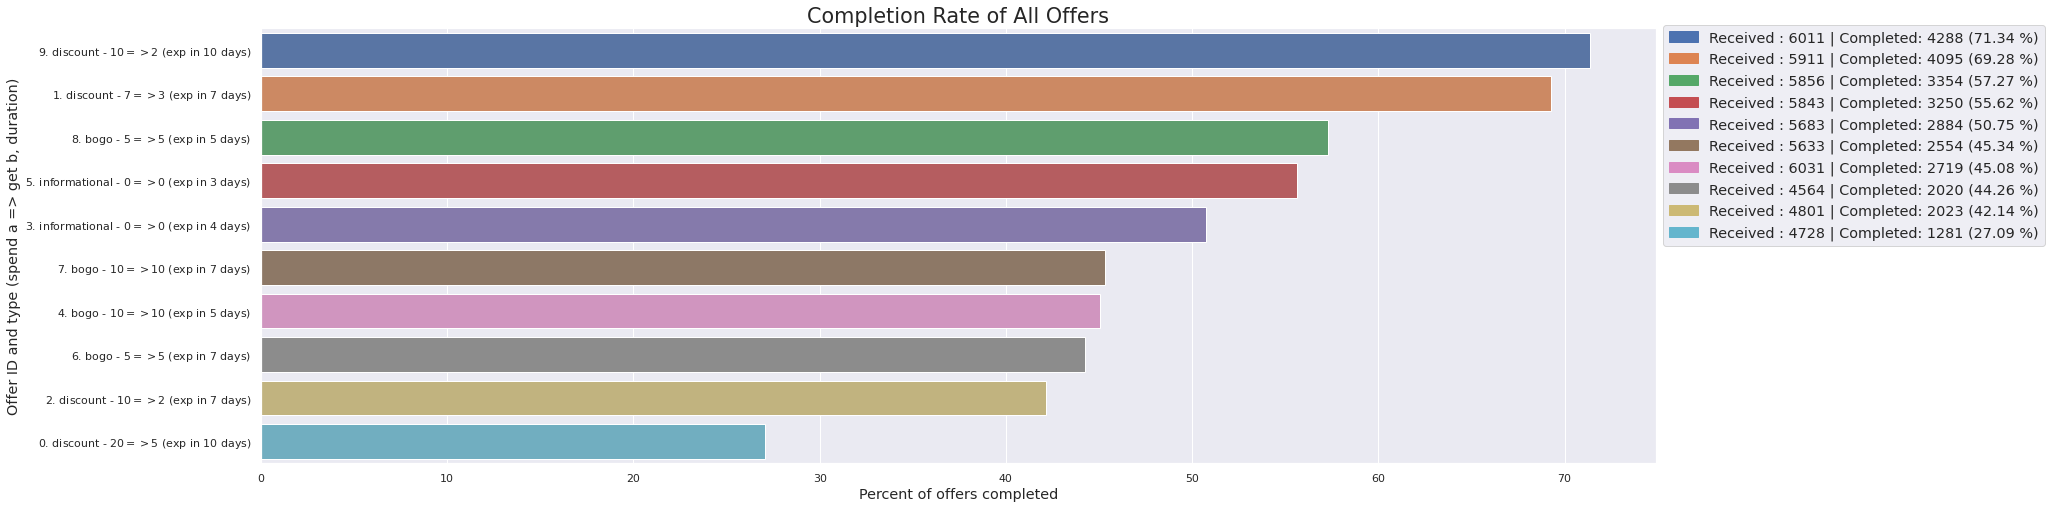

In [85]:
# Plot completed offer rates

plt.figure(figsize=(25, 8))
sns.barplot(data=comp_by_offer, x='pct_completed', y='offer', orient='h')
plt.legend(handles=[plt.Rectangle((0,0), 1, 1, color=color) for color in sns.color_palette()[:10]], labels=comp_by_offer.summary.tolist(), fontsize='large', bbox_to_anchor=(1, 1.025))
plt.title('Completion Rate of All Offers', fontsize='xx-large')
plt.ylabel('Offer ID and type (spend a => get b, duration)', fontsize='large')
plt.xlabel('Percent of offers completed', fontsize='large');

##### Observations:
The above bar chart shows the 10 unique offers in the dataset - 4 bogo, 4 discount, and 2 informational offers. This excludes completed offers that were not viewed before being completed.

- Offer 9 - spend 10 dollars to get a 2-dollar discount expiring in 10 days - had the highest completion rate at 71.34% (4,288 out of 6,011).
- Offer 0 - spend 20 dollars to get a 5-dollar discount expiring in 10 days - had the lowest completion rate at 27.09% (1,281 out of 4,728).


In predicting whether an offer will be completed, we can infer that the reward amount isn't as important a factor as the difficulty or duration.

It might be our first instinct to assume that the bogo offers would have the highest completion rate since the user is getting a 100% return on their money spent, but this is not the case. This is most likely due to the fact that bogo offers are inherently more difficult to complete regardless of duration because the difficulty amount has to be spent within a single transaction in order to complete the offer.

On the other hand, discount offers allow users to accumulate the difficulty amount with multiple transactions. For example, offer 7 (spend 10 dollars to get a 2-dollar discount) would be completed if a user made 4 small transactions of 3 dollars each because these transactions accumulate to more than 10 dollars.


---

##### **5. How are user demographics distributed in each group?**

In [86]:
# Add signup year feature

profile["signup_year"] = profile["became_member_on"].dt.year

In [87]:
# Fucntion to filter the offer data based on groups and merge it with profiles for demographic data

def merge_user_data_to_group_data(group_df, user_df=profile, merge_on="customer_id", cols_to_drop=["event", "group", "viewed", "completed"]):       
    df = pd.merge(group_df, user_df, on=merge_on, how='left')
    if isinstance(cols_to_drop, list) and len(cols_to_drop):
        df.drop(cols_to_drop, axis=1, inplace=True)
    return df

In [88]:
# Separate offers by group and merge user data into each group data

group1 = merge_user_data_to_group_data(offers.query('event == "offer received" and group == 1'))
group2 = merge_user_data_to_group_data(offers.query('event == "offer received" and group == 2'))
group3 = merge_user_data_to_group_data(offers.query('event == "offer received" and group == 3'))
group4 = merge_user_data_to_group_data(offers.query('event == "offer received" and group == 4'))

##### **Visualizing Profile Demographics for Group 1**

---

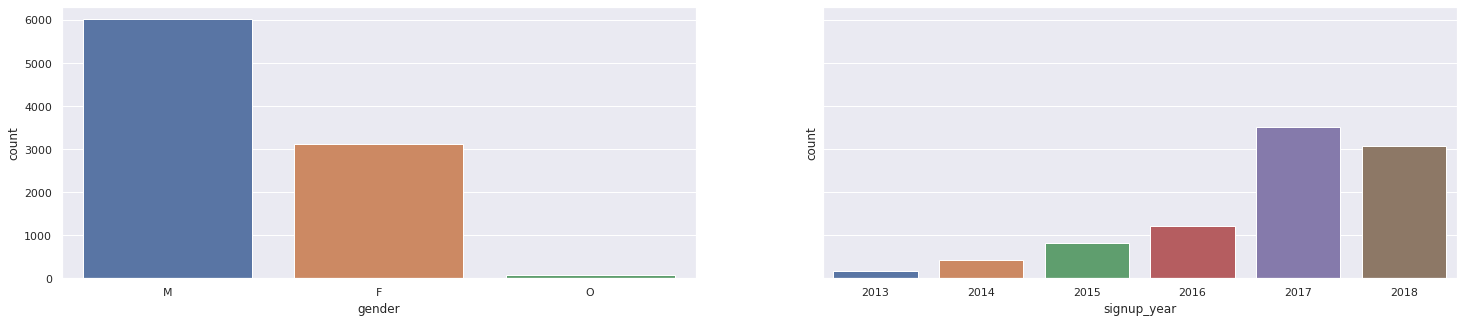

In [89]:
# Visualizing Gender and Signup year

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=True)

sns.countplot("gender", data=group1, ax=axes[0])
sns.countplot("signup_year", data=group1, ax=axes[1])

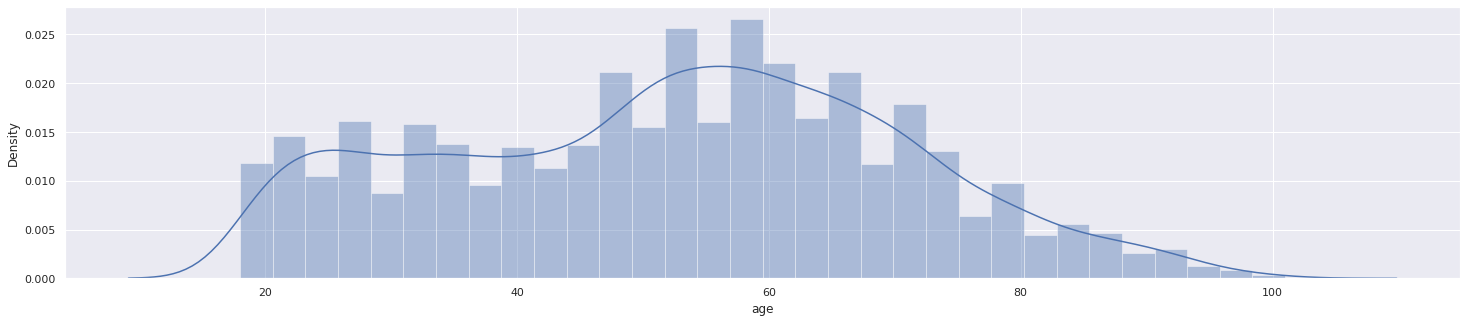

In [90]:
# Visualizing Age

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group1["age"], ax=axes)

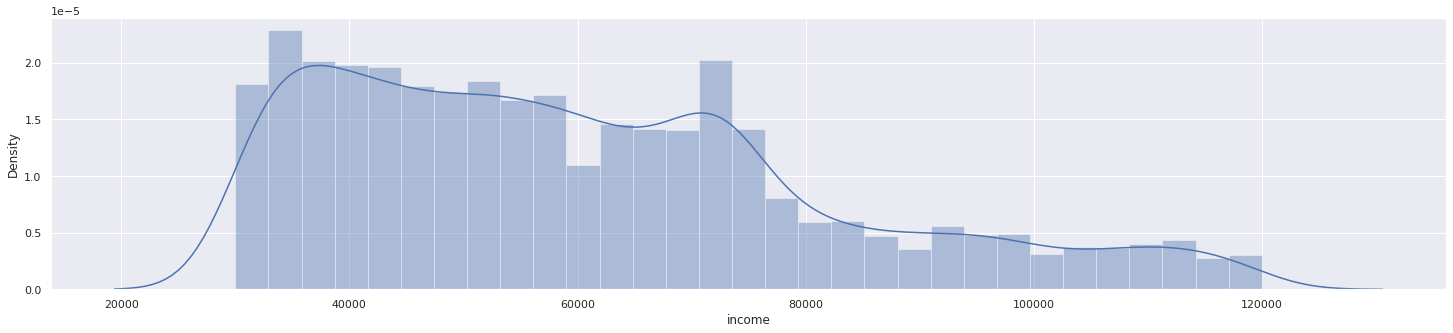

In [91]:
# Visualizing Income

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group1["income"], ax=axes)

##### **Visualizing Profile Demographics for Group 2**

---

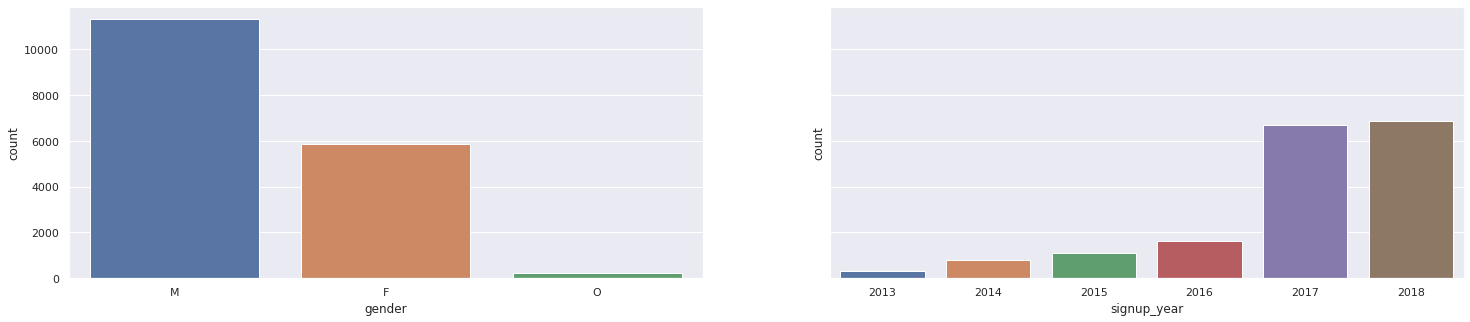

In [92]:
# Visualizing Gender and Signup year

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=True)

sns.countplot("gender", data=group2, ax=axes[0])
sns.countplot("signup_year", data=group2, ax=axes[1])

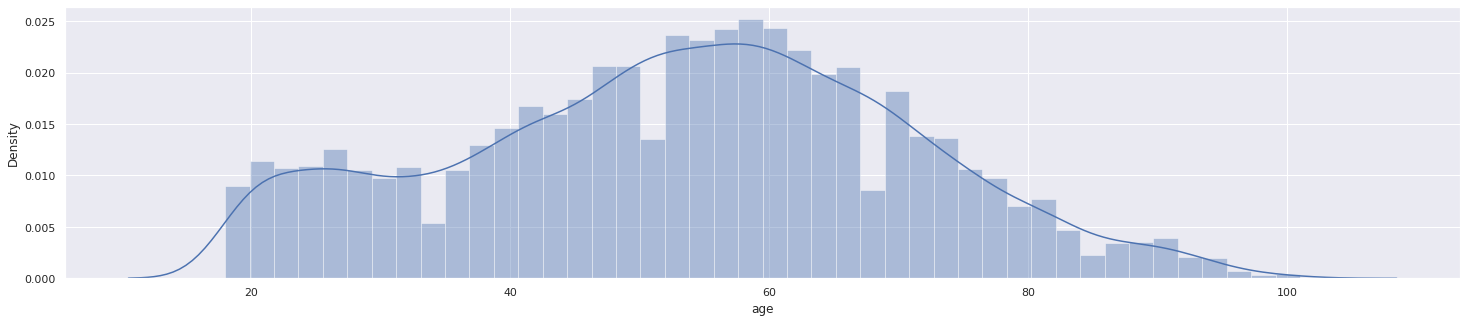

In [93]:
# Visualizing Age

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group2["age"], ax=axes)

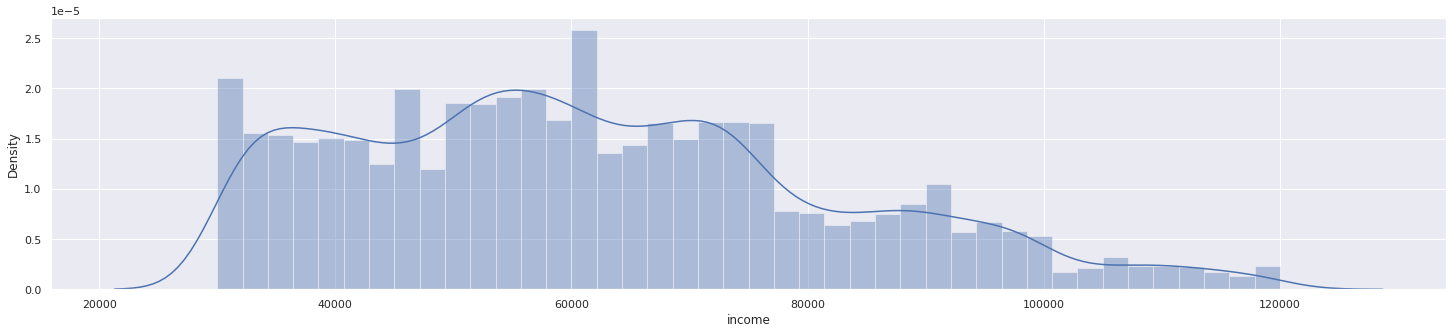

In [94]:
# Visualizing Income

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group2["income"], ax=axes)

##### **Visualizing Profile Demographics for Group 3**

---

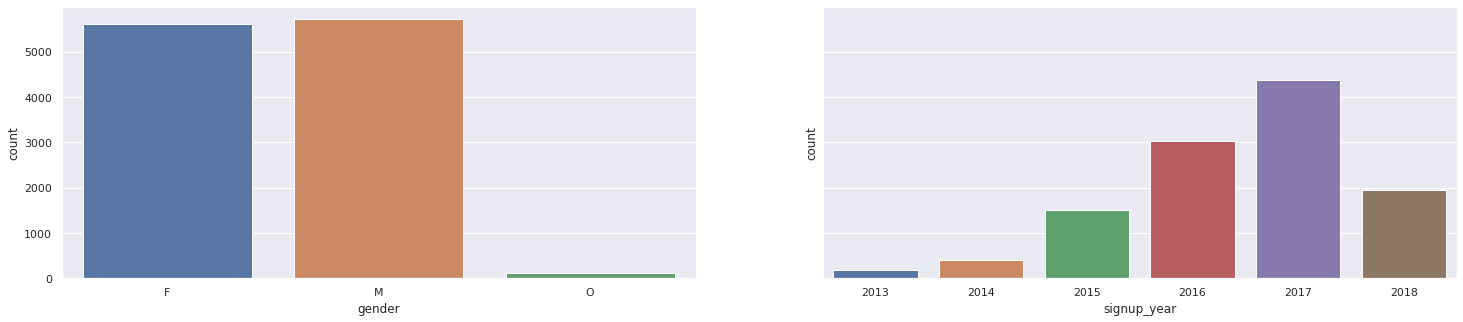

In [95]:
# Visualizing Gender and Signup year

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=True)

sns.countplot("gender", data=group3, ax=axes[0])
sns.countplot("signup_year", data=group3, ax=axes[1])

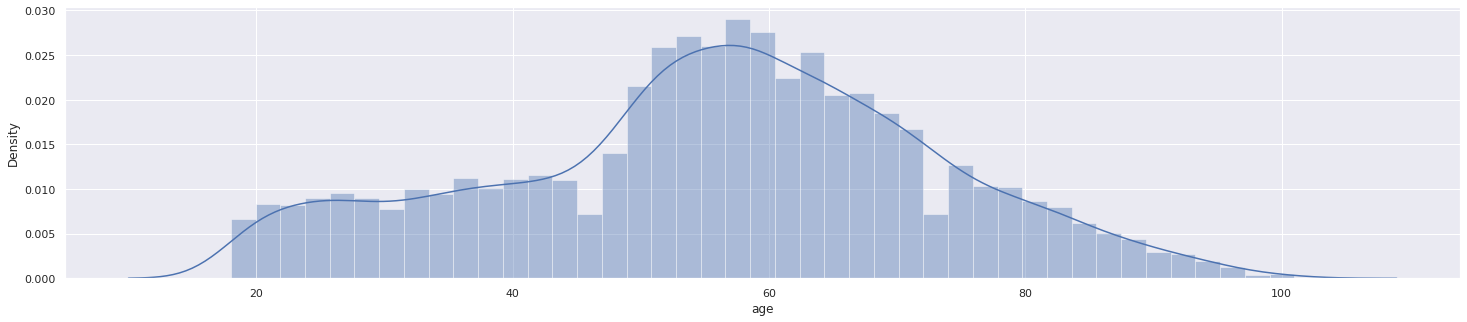

In [96]:
# Visualizing Age

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group3["age"], ax=axes)

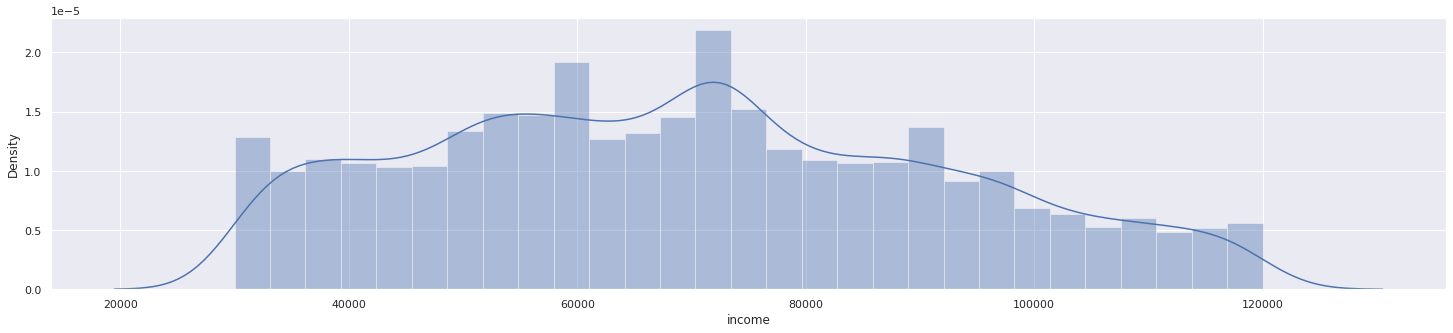

In [97]:
# Visualizing Income

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group3["income"], ax=axes)

##### **Visualizing Profile Demographics for Group 4**

---

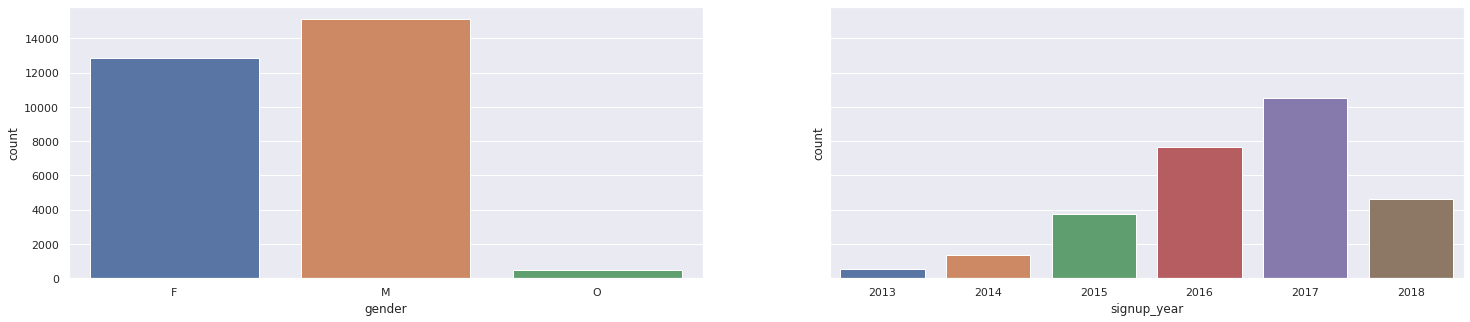

In [98]:
# Visualizing Gender and Signup year

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=True)

sns.countplot("gender", data=group4, ax=axes[0])
sns.countplot("signup_year", data=group4, ax=axes[1])

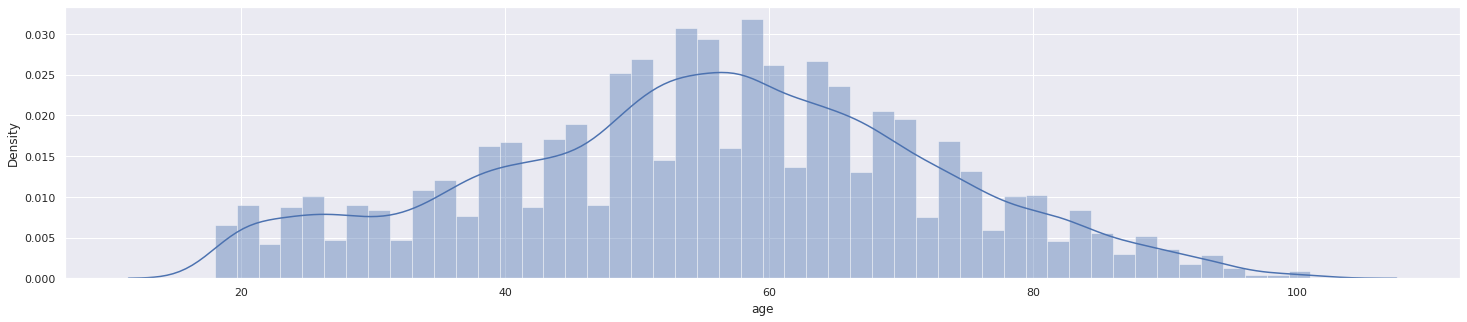

In [99]:
# Visualizing Age

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group4["age"], ax=axes)

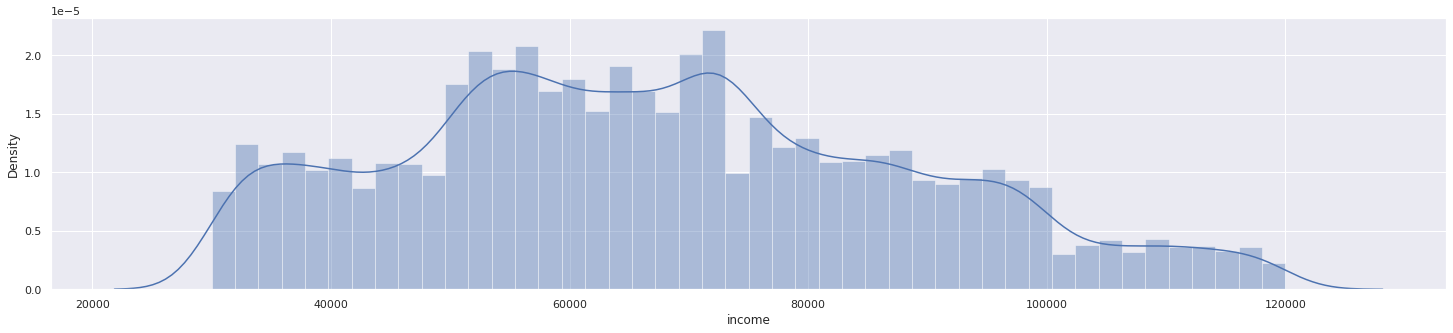

In [100]:
# Visualizing Income

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
sns.distplot(group4["income"], ax=axes)

##### Observations:

1. The demographics are very similar between groups 1 and 2 (offers that were not completed) and between groups 3 and 4 (offers that were completed)
  - Perhaps spending habit is a major differentiating factor between users in 2 groups 1 and 2 versus users in groups 3 and 4

2. Groups 1 and 2 (offers that were not completed):
- There are about twice as many male users as female users
- Contains more younger users than groups 3 and 4
- Signup trend is similar to groups 3 and 4 from 2013 to 2017, but 2018 signups only had a small decrease from 2017
- Contains a lot more users on the lower end of the income distribution

3. Groups 3 and 4 (offers that were completed):
- The number of male and female users are roughly equivalent
- Average age is a little higher than groups 1 and 2
- Saw a steep drop in signups in 2018
- Average income is about 8k higher than groups 1 and 2

---

##### **6. Are there any patterns in user spending?**

In [101]:
# Group age and income into bins

profile["age_group"] = pd.qcut(profile["age"], 5, labels=range(1, 6)).astype(int)
profile["income_group"] = pd.qcut(profile["income"], 5, labels=range(1, 6)).astype(int)

In [102]:
# Calculate the total amount each user spent
total_spent = transcript.groupby("customer_id")["amount"].sum().reset_index()
profile = pd.merge(profile, total_spent, on="customer_id", how="left")

# Calculate the decile (10-quantile) each user's spending falls into
profile["spend_group"] = pd.qcut(profile.amount, 10, range(1, 11)).astype(int)

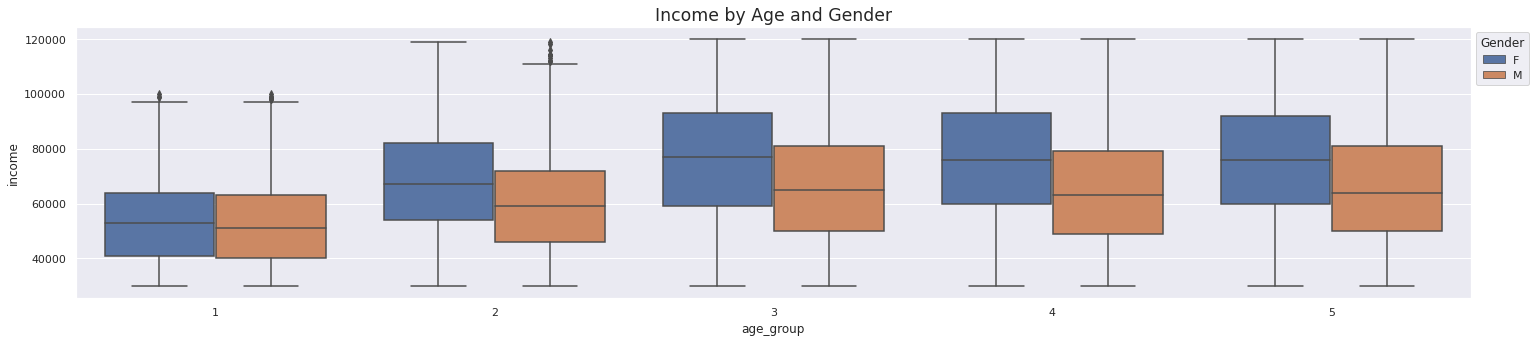

In [103]:
# Income by age and gender

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(data=profile.query('gender != "O"'), x="age_group", y="income", hue="gender")
plt.title("Income by Age and Gender", fontsize='x-large')
plt.legend(title="Gender", bbox_to_anchor=(1, 1));

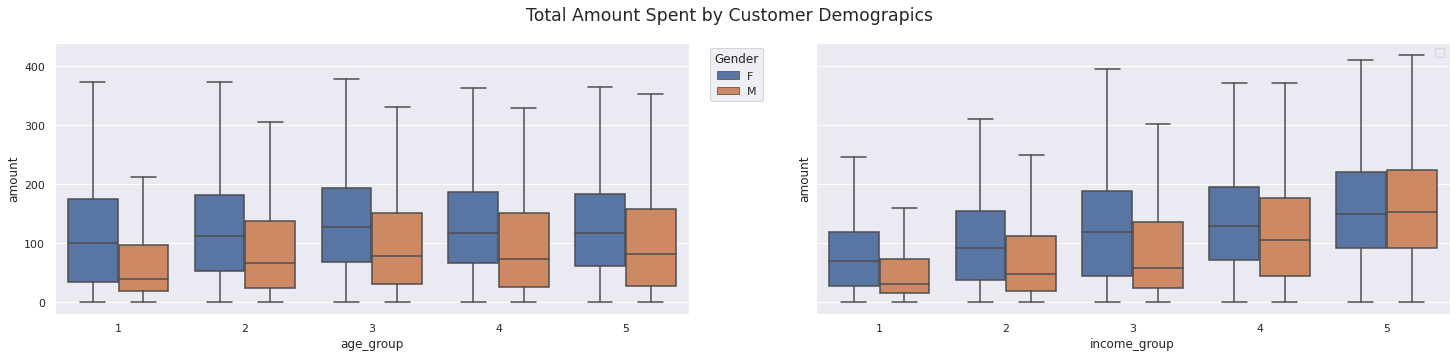

In [104]:
# Box plots with hue

sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(25, 5))
fig.suptitle("Total Amount Spent by Customer Demograpics", fontsize='x-large')

sns.boxplot(data=profile.query('gender != "O"'), x="age_group", y="amount", hue="gender", showfliers=False, ax=ax[0])
sns.boxplot(data=profile.query('gender != "O"'), x="income_group", y="amount", hue="gender", showfliers=False, ax=ax[1])
ax[0].legend(title='Gender', bbox_to_anchor=(1.025, 1))
ax[1].legend('');

Text(0.5, 1.0, 'Amount Spent by Signup Year')

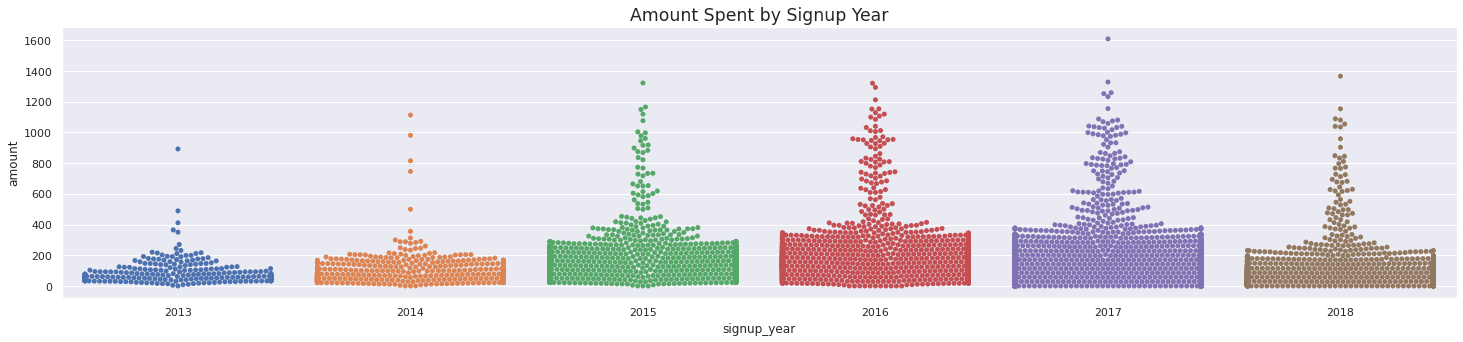

In [105]:
# Amount Spend by Signup year

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.swarmplot(data=profile.query('gender != "O"'), x="signup_year", y="amount")
plt.title("Amount Spent by Signup Year", fontsize='x-large')


##### Observations:

Users were grouped into 10 cohorts based on the total amount they spent (in 10 quantiles). 

From these plots, we can make the following observations and inferences about how different types of users spend money on the app:

- Signup year - users who have been using the app longer tend to spend more
- Income - users who earn more money tend to spend more
- Age - user spending increases with age up to a certain age, and then the spending is consistent with the older half
- Gender - female users tend to spend more money. Female users outnumber male users a little in the higher spending cohorts, as opposed to the bottom cohort, where there are 3 times as many male users as female users

---

##### **7. Are there any demographic patterns in offer completion?**

In [106]:
# Merge user data into event data
offers = pd.merge(offers, profile.drop("amount", axis=1), on="customer_id", how="left")

# Extract true offers by ID - unviewed completed offers are not counted
true_offers = offers.query('event == "offer received" and group != 3')

In [107]:
# Function for plotting offer completion rate by a specified user demographic feature

def plot_demographic_completion(data, hue, x="offer_id", y="completed"):    
    sns.set(style="darkgrid")
    plt.figure(figsize=(25, 5))

    title = hue.replace("_", " ").title()
    sns.barplot(data=data, x=x, y=y, hue=hue)
    plt.title(f"Completion Rate by {title}", fontsize='xx-large')
    plt.ylabel("Proportion of offers completed")
    plt.xlabel("Offer ID")
    plt.legend(title=title, bbox_to_anchor=(1, 1))
    plt.show()

Counts for :  gender
F    21854
M    32416
O      791
Name: offer_id, dtype: int64


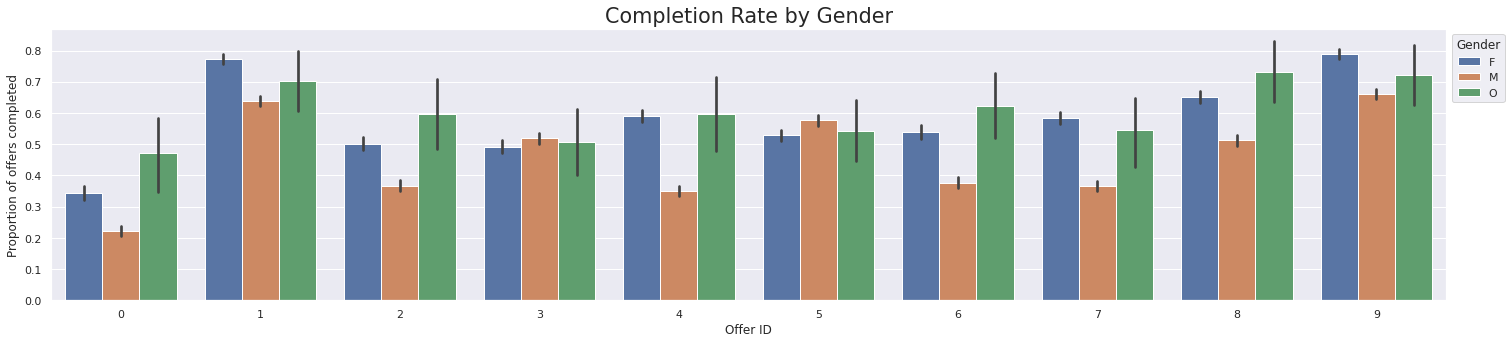

In [108]:
# Plot offer completion rate by gender

print("Counts for : ", true_offers.groupby("gender")["offer_id"].count())
plot_demographic_completion(true_offers, "gender")

Counts for :  age_group
1    11793
2    11199
3    10576
4    10972
5    10521
Name: offer_id, dtype: int64


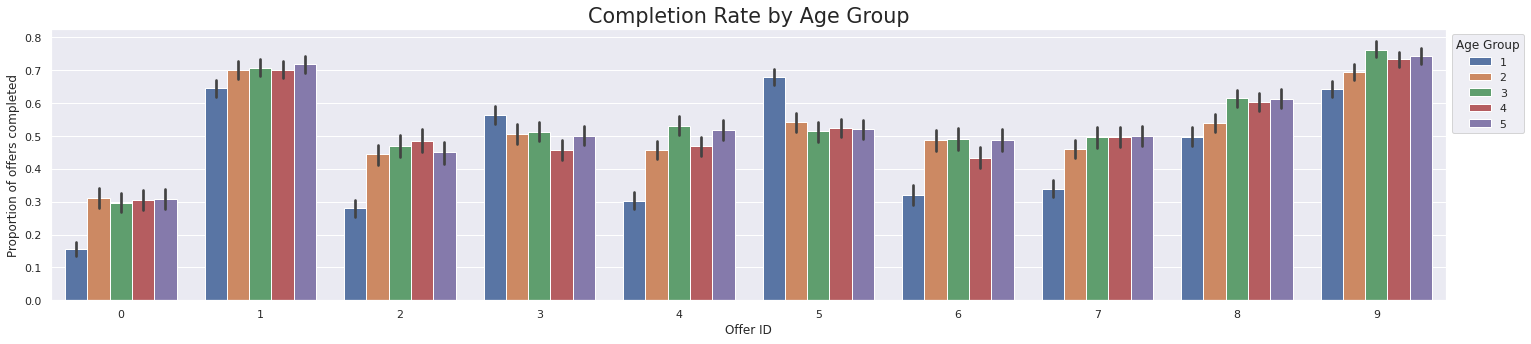

In [109]:
# Plot offer completion rate by age_group

print("Counts for : ", true_offers.groupby("age_group")["offer_id"].count())
plot_demographic_completion(true_offers, "age_group")

Counts for :  income_group
1    11825
2    11118
3    11703
4    10527
5     9888
Name: offer_id, dtype: int64


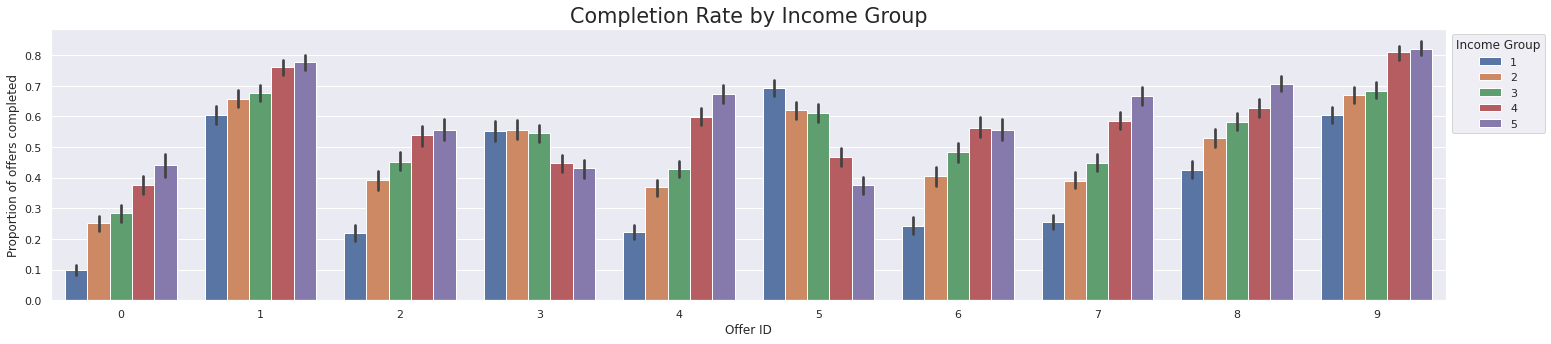

In [110]:
# Plot offer completion rate by income group

print("Counts for : ", true_offers.groupby("income_group")["offer_id"].count())
plot_demographic_completion(true_offers, "income_group")

Counts for :  signup_year
2013     1050
2014     2560
2015     5652
2016    10492
2017    20748
2018    14559
Name: offer_id, dtype: int64


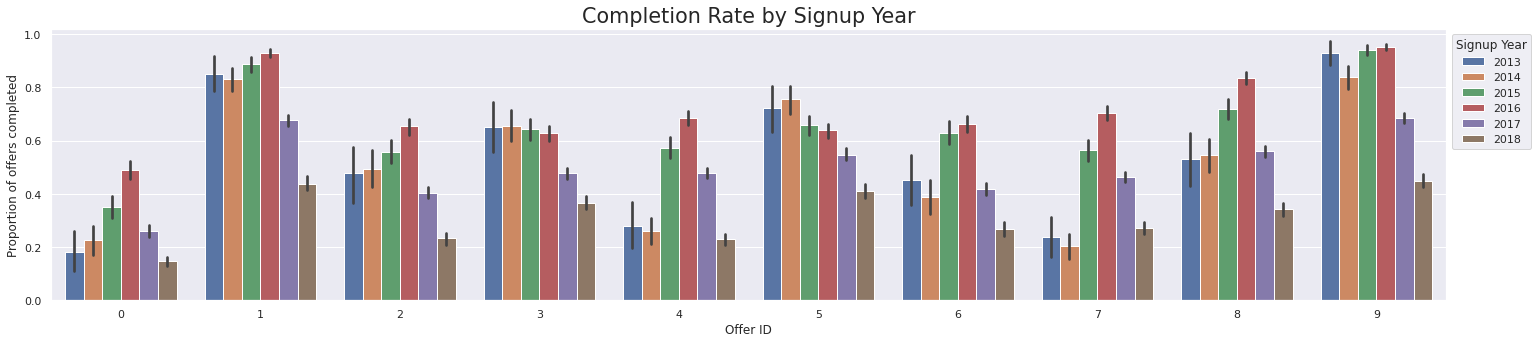

In [111]:
# Plot offer completion rate by signup year

print("Counts for : ", true_offers.groupby("signup_year")["offer_id"].count())
plot_demographic_completion(true_offers, "signup_year")

Counts for :  spend_group
1     6354
2     6181
3     5910
4     5748
5     5364
6     5081
7     4955
8     5115
9     5056
10    5297
Name: offer_id, dtype: int64


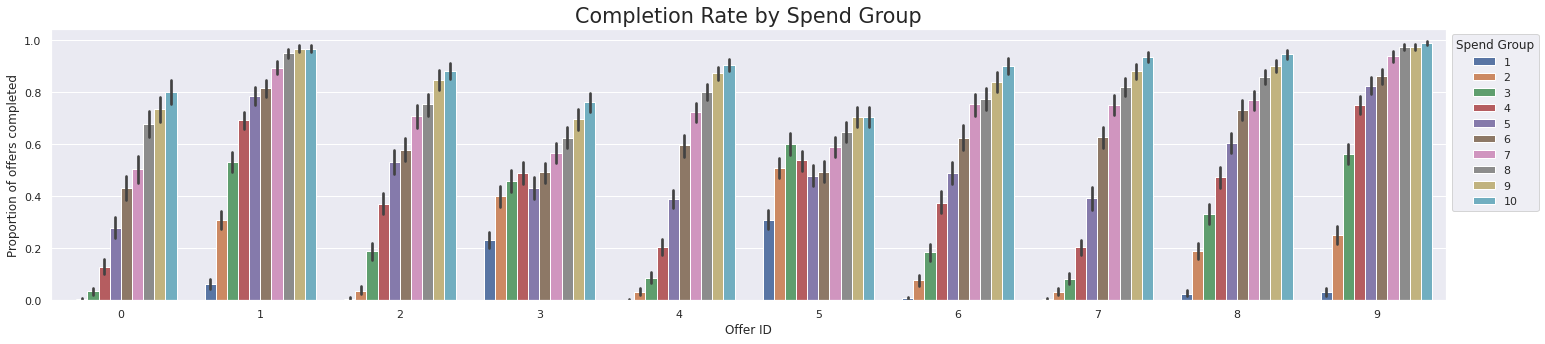

In [112]:
# Plot offer completion rate by spend_group

print("Counts for : ", true_offers.groupby("spend_group")["offer_id"].count())
plot_demographic_completion(true_offers, "spend_group")

In [113]:
true_offers.head()

index  customer_id           event  time  amount  reward_received  \
0      0         6962  offer received     0     0.0              0.0   
1      1        13107  offer received     0     0.0              0.0   
2      2         3246  offer received     0     0.0              0.0   
3      3         2669  offer received     0     0.0              0.0   
4      4         9940  offer received     0     0.0              0.0   

   offer_id  reward_offered  difficulty  duration     offer_type  email  \
0         6             5.0         5.0       7.0           bogo    1.0   
1         2             2.0        10.0       7.0       discount    1.0   
2         8             5.0         5.0       5.0           bogo    1.0   
3         3             0.0         0.0       4.0  informational    1.0   
4         0             5.0        20.0      10.0       discount    1.0   

   mobile  social  web  expire_time  oid_cid  viewed  completed  group gender  \
0     1.0     0.0  1.0        168.0   6_6962       1          1      4      F   
1     1.0     0.0  1.0        168.0  2_13107       1          0      2      M   
2     1.0     1.0  1.0        120.0   8_3246       1          1      4      M   
3     1.0     0.0  1.0         96.0   3_2669       0          0      1      M   
4     0.0     0.0  1.0        240.0   0_9940       1          0      2      F   

   age became_member_on    income  signup_year  age_group  income_group  \
0   75       2017-05-09  100000.0         2017          5             5   
1   68       2018-04-26   70000.0         2018          4             3   
2   65       2018-02-09   53000.0         2018          4             2   
3   58       2017-11-11   51000.0         2017          3             2   
4   61       2017-09-11   57000.0         2017          4             2   

   spend_group  
0            8  
1            4  
2            3  
3            2  
4            5

##### Observations:

From the above barplots, we can see make the following observations and inferences:
1. Gender - female customers had a higher completion rate than male customers for most of the 10 offers
- The difference in offer completion rate between male and female cutomers also increases as the offer type gets harder to complete (informational < discount < bogo)
- In general, female customers are more likely than male customers to complete an offer

2. Age - the youngest age group had the lowest completion rate than the other 4 groups for 8 out of 10 offers (except 3 and 5)
- The difference is greater for the more difficult offers

3. Income - for the most part, there is a monotonic relationship between income and offer completion rate
- As with age, the greatest differences are between income group 1 and the other 
- 4 groups for the more difficult offers
- It could be that since younger customers earn less income, they spend less in general and are less likely to complete the more difficult offers

4. Signup year - Customers that signed up in 2016 had the highest completion rate (followed by 2015-users) and users that signed up in 2018 had the lowest completion rate for 9 out of 10 offers
- As we saw in the previous subsection, there were a lot more 2018-users among the lower spenders so they would be less likely to complete the more difficult offers
- It could be that newer users are more hesistant to spend money on the app compared to more established users
- Another possibility is that a lot of the 2018 signups were the younger users (who don't spend as much)

5. Spend Group - Customers tend have higher completion rate as the income increases.
- Except for offers 3 and 5, completion rate increases with income group

---

### **3.3 Segmentation**

#### **3.3.1 FMT segmentation (frequency, monetary value, tenure)**

Group customers into quantiles for each of these metrics and score customers using all 3 quantile features, then segments will be created based on the total scores
- Frequency - how often the user made a transaction
- Monetary value - how much money the user spent
- Tenure - how long the user has been using the app

This is normally RFM (recency, frequency, monetary value), but recency is not useful here with only 1 month of activity data, so tenure is replacing recency.

The FMT values were calculated for each customer based on the following rules:
- Frequency - number of transactions made, where the amount was at least 1 dollar
- Monetary value - total amount spent
- Tenure - number of months from signup date to the reference date
The reference date was set as the latest signup date plus 30 days


In [114]:
transcript.head()

customer_id           event  time  amount  reward  offer_id
0         6962  offer received     0     0.0     0.0         6
1        13107  offer received     0     0.0     0.0         2
2         3246  offer received     0     0.0     0.0         8
3         2669  offer received     0     0.0     0.0         3
4         9940  offer received     0     0.0     0.0         0

In [115]:
# Extract transactions
transactions = transcript.query('event == "transaction"').drop("event", axis=1)

# Merge with profile data
transactions = pd.merge(transactions, profile.drop(["amount", "spend_group"], axis=1), on="customer_id", how="left")  

In [116]:
# Creating a binary feature indicating whether the transaction amount was at least $1
transactions["gte1"] = transactions["amount"].apply(lambda a: int(a >= 1))

# Calculate the frequency, monetary value for all users
fmt = transactions.groupby("customer_id", as_index=False).agg({
    'gte1': 'sum', # frequency
    'amount': 'sum', # monetary
})
fmt.columns = ["customer_id", "frequency", "monetary"]

In [117]:
# Add users with no transactions

fmt = pd.merge(profile[["customer_id", "became_member_on"]], fmt, on="customer_id", how="left")
fmt = fmt.sort_values("customer_id").set_index("customer_id").fillna(0)
fmt["frequency"] = fmt.frequency.astype(int)

In [118]:
# Calculate a reference date for tenure - 30 days after the latest signup date
ref_date = profile["became_member_on"].max() + pd.Timedelta(30, 'days')

# Calculate the tenure in months for all users
fmt["tenure"] = fmt["became_member_on"].apply(lambda d: (ref_date - d).days // 30)
fmt.drop("became_member_on", axis=1, inplace=True)

The FMT values were reduced to quantiles in order to score each customer. 

The number of quantiles chosen for each feature was the weight for which the segmentation was based on:
- Frequency - 6 quantiles (1 - 6 points)
- Monetary value - 8 quantiles (1 - 8 points)
- Tenure - 3 quantiles (1 - 3 points)

Example: a user in the top quantile for all 3 features would get a total score of 17 (6 + 8 + 3)

The weights were chosen somewhat arbitrarily, but the general idea is that monetary value is the most important feature here since it is the main focus of this project. This is followed by frequency and then tenure, which would both have more weight if we were focusing on how customers are using the app, but this is not the case.

In [119]:
# Reduce FMT values into quantiles
fmt["F"] = pd.qcut(fmt["frequency"], 6, range(1, 7)).astype(int)
fmt["M"] = pd.qcut(fmt["monetary"], 8, range(1, 9)).astype(int)
fmt["T"] = pd.qcut(fmt["tenure"], 3, range(1, 4)).astype(int)

In [120]:
# Aggregate quantile values

# concat as str for segment name
fmt["FMT"] = fmt["F"].astype(str) + fmt["M"].astype(str) + fmt["T"].astype(str) 

# sum as int for customer score
fmt["score"] = fmt["F"] + fmt["M"] + fmt["T"] 

In [121]:
fmt.head()

frequency  monetary  tenure  F  M  T  FMT  score
customer_id                                                  
0                    8    127.60      16  4  6  2  462     12
1                    5     79.46       7  2  4  1  241      7
2                    8    196.86      30  4  7  3  473     14
3                   12    154.05      21  5  6  2  562     13
4                   14     48.34      14  6  3  2  632     11

In [122]:
# Calculate the frequency, monetary, and tenure (FMT) means for each segment, as well as the number and percentage of users in each segment.

def segment_means(fmt_df, cols=["frequency", "monetary", "tenure"], group_col="score", count_col="FMT"):    
    
    df = fmt_df.groupby(group_col).mean()[cols].round(2)
    df["n_users"] = fmt_df.groupby(group_col)[count_col].count()
    df["pct_users"] = (100 * df["n_users"] / fmt_df.shape[0]).round(2)
    return df

# Calculate the FMT means and user counts for each score segment 
fmt_segementation = segment_means(fmt)

In [123]:
fmt_segementation

frequency  monetary  tenure  n_users  pct_users
score                                                 
3           1.62      6.35    5.01      951       6.41
4           2.66     12.58    7.47      943       6.36
5           3.53     26.82    7.08     1052       7.10
6           4.34     37.65    8.59     1047       7.06
7           4.79     51.64   12.12      840       5.67
8           5.30     69.95   14.52      907       6.12
9           6.22     78.77   19.03      921       6.21
10          7.40     92.34   21.26     1026       6.92
11          8.90    107.15   24.83     1300       8.77
12          9.88    131.55   23.22     1218       8.22
13         11.51    151.20   25.74     1350       9.11
14         11.16    213.38   23.00     1076       7.26
15         12.48    264.39   23.10     1021       6.89
16         14.43    311.64   25.20      844       5.69
17         16.93    331.60   30.70      329       2.22

In [124]:
# Create 3 customer tiers based on score: 3 - 7, 8 - 12, 13 - 17
fmt["tier"] = (fmt.score + 2) // 5
fmt["customer_tier"] = fmt["tier"].map({1: "Bronze", 2: "Silver", 3: "Gold"})

# Calculate the FMT means and user counts for each tier segment 
fmt_tier_segmentation = segment_means(fmt, group_col='tier')

The individual scores for each were summed up for a maximum of 17 points, which created 15 cohorts of users (3 - 17 points). Since there are too many cohorts and the cohort sizes weren't very balanced, I grouped the cohorts in 3 tiers of customers: bronze customers have a total score between 3 and 7, silver between 8 and 12, and gold between 13 and 17.

In [125]:
fmt_tier_segmentation

frequency  monetary  tenure  n_users  pct_users
tier                                                 
1          3.38     26.67    7.95     4833      32.60
2          7.77     98.71   21.05     5372      36.24
3         12.56    232.85   24.77     4620      31.16

In [126]:
fmt.head()

frequency  monetary  tenure  F  M  T  FMT  score  tier  \
customer_id                                                           
0                    8    127.60      16  4  6  2  462     12     2   
1                    5     79.46       7  2  4  1  241      7     1   
2                    8    196.86      30  4  7  3  473     14     3   
3                   12    154.05      21  5  6  2  562     13     3   
4                   14     48.34      14  6  3  2  632     11     2   

            customer_tier  
customer_id                
0                  Silver  
1                  Bronze  
2                    Gold  
3                    Gold  
4                  Silver

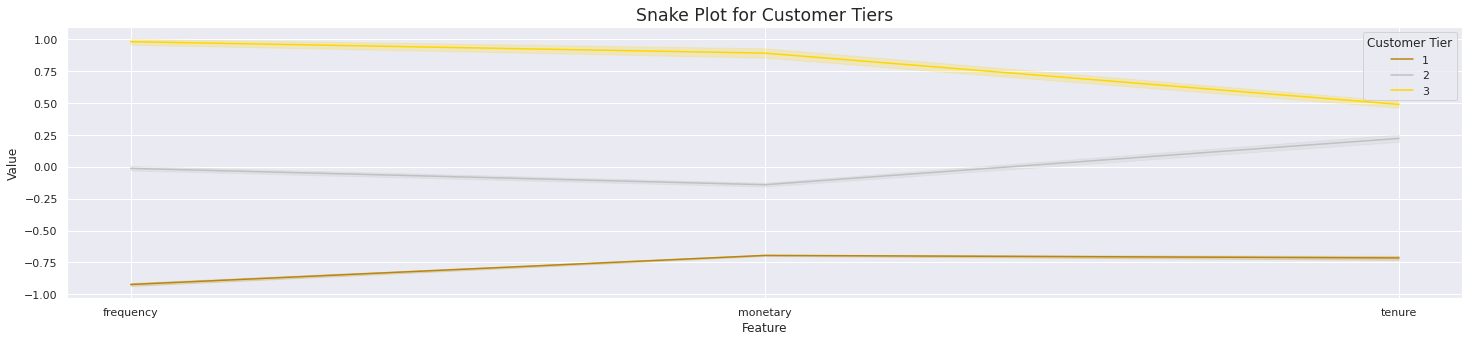

In [127]:
# Create a snake plot for the specified features of customer segments.

def snake_plot(segment_df, feats=["frequency", "monetary", "tenure"], normalize=True, segment_col="tier", user_col="customer_id", title="Snake Plot", legend_title="Customer Tier", palette=None):
        
    # Set index
    if user_col in segment_df.columns:
        segment_df.set_index(user_col, inplace=True)
        
    # Normalize values
    if normalize:
        df = pd.DataFrame(StandardScaler().fit_transform(segment_df[feats]), index=segment_df.index, columns=feats)
        df[segment_col] = segment_df[segment_col]
    else:
        df = segment_df[feats]
        
    # Melt features
    melt = pd.melt(df.reset_index(), id_vars=[user_col, segment_col], value_vars=feats, var_name='Feature', value_name='Value')

    # Create a snake plot for customer segments
    title += ' for ' + legend_title + 's'
    sns.lineplot(data=melt, x='Feature', y='Value', hue=segment_col, palette=palette)
    plt.title(title, fontsize='x-large')
    plt.legend(title=legend_title, bbox_to_anchor=(1, 1))
    plt.show()

# Snake plot
snake_plot(fmt, palette=['darkgoldenrod', 'silver', 'gold'])

##### Observations:

1. The average of all 3 FMT metrics increase with an increasing customer tier, although not at the same rate. 

2. The different increasing rates could be due to or made more pronounced by the difference in the number of quantiles between the features.

---

##### **Completion rate of customer tiers**

In [128]:
# Merge FMT data into offer events
offers = pd.merge(offers, fmt.reset_index()[["customer_id", "frequency", "monetary", "tenure", "customer_tier"]], on="customer_id", how="left")

# Extract true offers
true_offers = offers.query('event == "offer received" and group != 3')

In [129]:
true_offers.head()

index  customer_id           event  time  amount  reward_received  \
0      0         6962  offer received     0     0.0              0.0   
1      1        13107  offer received     0     0.0              0.0   
2      2         3246  offer received     0     0.0              0.0   
3      3         2669  offer received     0     0.0              0.0   
4      4         9940  offer received     0     0.0              0.0   

   offer_id  reward_offered  difficulty  duration     offer_type  email  \
0         6             5.0         5.0       7.0           bogo    1.0   
1         2             2.0        10.0       7.0       discount    1.0   
2         8             5.0         5.0       5.0           bogo    1.0   
3         3             0.0         0.0       4.0  informational    1.0   
4         0             5.0        20.0      10.0       discount    1.0   

   mobile  social  web  expire_time  oid_cid  viewed  completed  group gender  \
0     1.0     0.0  1.0        168.0   6_6962       1          1      4      F   
1     1.0     0.0  1.0        168.0  2_13107       1          0      2      M   
2     1.0     1.0  1.0        120.0   8_3246       1          1      4      M   
3     1.0     0.0  1.0         96.0   3_2669       0          0      1      M   
4     0.0     0.0  1.0        240.0   0_9940       1          0      2      F   

   age became_member_on    income  signup_year  age_group  income_group  \
0   75       2017-05-09  100000.0         2017          5             5   
1   68       2018-04-26   70000.0         2018          4             3   
2   65       2018-02-09   53000.0         2018          4             2   
3   58       2017-11-11   51000.0         2017          3             2   
4   61       2017-09-11   57000.0         2017          4             2   

   spend_group  frequency  monetary  tenure customer_tier  
0            8          7    159.27      15        Silver  
1            4          3     57.73       4        Bronze  
2            3          3     36.43       6        Bronze  
3            2          3     15.62       9        Bronze  
4            5          6     85.55      11        Silver

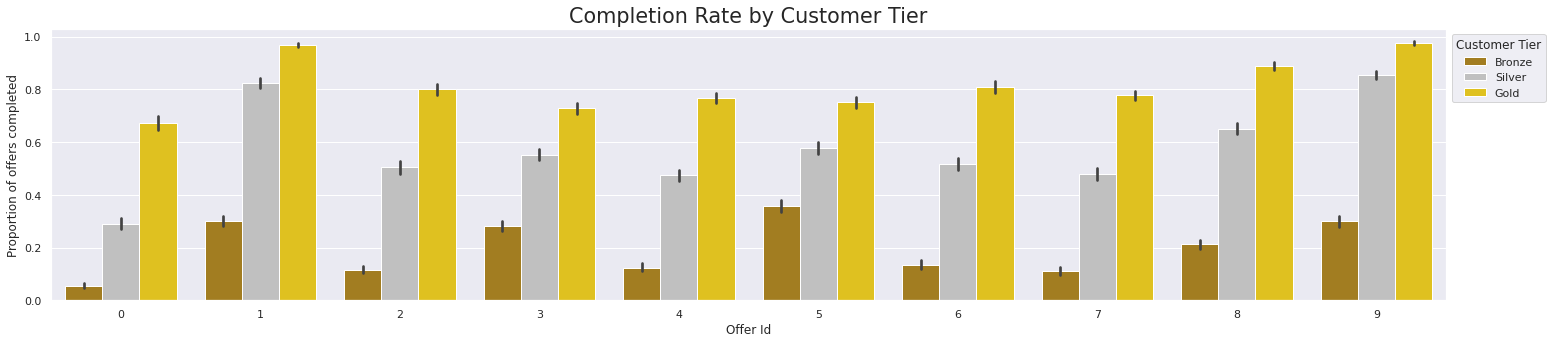

In [130]:
# Plot offer completion rate by customer segment.

def plot_segment_completion(data, hue, hue_order, x='offer_id', y='completed', palette=None):
    plt.figure(figsize=(25, 5))
    title = hue.replace("_", " ").title()
    
    sns.barplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=palette)
    plt.title(f'Completion Rate by {title}', fontsize='xx-large')
    plt.ylabel('Proportion of offers completed')
    plt.xlabel(x.replace('_', ' ').title())
    plt.legend(title=title, bbox_to_anchor=(1, 1))
    plt.show()
    

plot_segment_completion(true_offers, "customer_tier", ["Bronze", "Silver", "Gold"], palette=['darkgoldenrod' ,'silver', 'gold'])

##### Observations:

1. Bronze customers - had a very low completion rate for all offers
  - The highest rate wasn't even as high as 40% and that was with the 2 easiest reward offers (3 and 4)

2. Silver customers - was in between bronze and gold customers for all offers
  - Completion rate was mediocre for all offers except offers 1 and 9, which were both over 80%

3. Gold customers - had a completion rate of over 60% for all offers
  - Completion rate gets as high as 97%

4. Offers 0 had the lowest completion rate and offers 1 and 9 had the highest completion rate for all 3 tiers
  - All 3 of these were discount offers

---

##### **Customer tier demographics**



In [131]:
# Merge user data into FMT data

fmt = pd.merge(fmt.reset_index(), profile, on="customer_id", how="left")

In [132]:
# Filtering the fmt data based on customer tier

fmt_bronze = fmt[fmt["customer_tier"] == "Bronze"]
fmt_silver = fmt[fmt["customer_tier"] == "Silver"]
fmt_golden = fmt[fmt["customer_tier"] == "Gold"]

[Text(0.5, 1.0, 'Gold')]

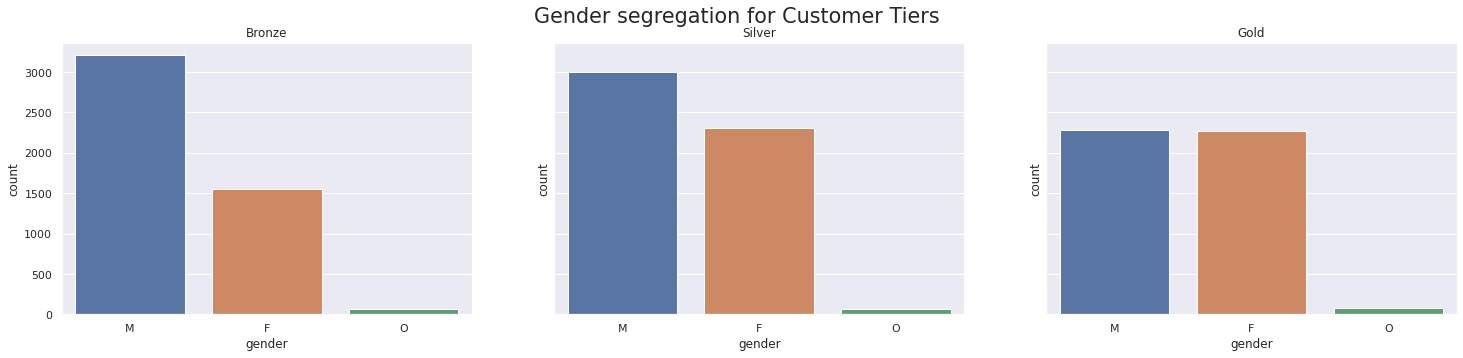

In [133]:
# Visualizing Gender 

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle("Gender segregation for Customer Tiers", fontsize='xx-large')

sns.countplot("gender", data=fmt_bronze, ax=axes[0], order=["M", "F", "O"])
axes[0].set(title="Bronze")

sns.countplot("gender", data=fmt_silver, ax=axes[1], order=["M", "F", "O"])
axes[1].set(title="Silver")

sns.countplot("gender", data=fmt_golden, ax=axes[2], order=["M", "F", "O"])
axes[2].set(title="Gold")

[Text(0.5, 1.0, 'Gold')]

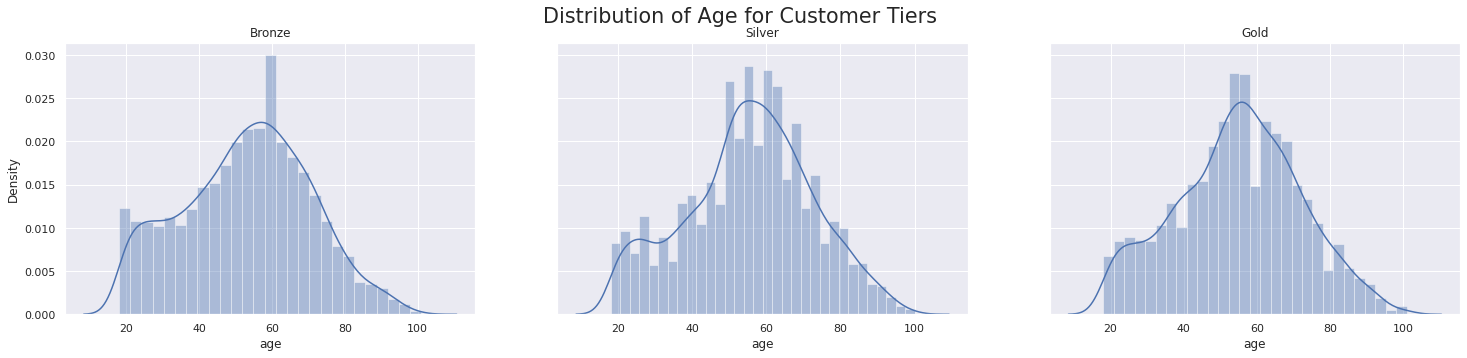

In [134]:
# Visualizing Age

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle("Distribution of Age for Customer Tiers", fontsize='xx-large')

sns.distplot(fmt_bronze["age"], ax=axes[0])
axes[0].set(title="Bronze")

sns.distplot(fmt_silver["age"], ax=axes[1])
axes[1].set(title="Silver")

sns.distplot(fmt_golden["age"], ax=axes[2])
axes[2].set(title="Gold")

[Text(0.5, 1.0, 'Gold')]

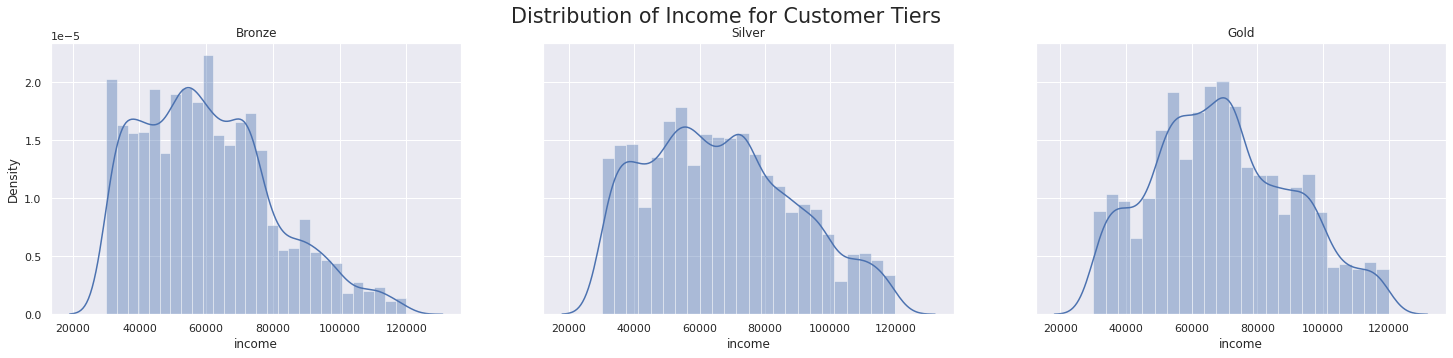

In [135]:
# Visualizing Income

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle("Distribution of Income for Customer Tiers", fontsize='xx-large')

sns.distplot(fmt_bronze["income"], ax=axes[0])
axes[0].set(title="Bronze")

sns.distplot(fmt_silver["income"], ax=axes[1])
axes[1].set(title="Silver")

sns.distplot(fmt_golden["income"], ax=axes[2])
axes[2].set(title="Gold")

##### Observations:

With an increasing customer tier, we can see the following changes:
1. Gender - proportion of female users increases relative to male users
  - In the bronze group, there are more than twice as many male users as female users
  - In the gold group, the number of female and male users are almost equal

2. Age - number of users under 40 decreases
  - But there isn't much difference in the average age

3. Income - number of lower earners decreases and number of higher earners increase
  - The average income of gold users is about 9k higher than the average income of bronze users. As bronze users do not spend a lot of money, they're not very likely to respond to offers so it would be a good idea to either stop sending them offers or to only send them offers that are easy to complete.
  - Silver users do spend quite a bit more than bronze users, so it's actually worth it to be sending them offers. They completed a good portion of discount offers 3 and 4 that were sent out, so focusing on the easier offers or lowering the difficulty of the harder offers would likely result in an increase the number of offers that are completed.
  - Gold users consistently have a high rate of offer completion so it would actually benefit Starbucks to increase the difficulty of offers being sent to these users. As they are highly likely to respond to offers, a higher difficulty would likely increase the amount these customers spend.


---

#### **3.3.2 KMeans Segmentation**

In [136]:
# Group "female" and "other" gender into a new binary feature

fmt["male"] = (fmt["gender"] == 'M').astype(int)

In [137]:
fmt.head()

customer_id  frequency  monetary  tenure  F  M  T  FMT  score  tier  \
0            0          8    127.60      16  4  6  2  462     12     2   
1            1          5     79.46       7  2  4  1  241      7     1   
2            2          8    196.86      30  4  7  3  473     14     3   
3            3         12    154.05      21  5  6  2  562     13     3   
4            4         14     48.34      14  6  3  2  632     11     2   

  customer_tier gender  age became_member_on   income  signup_year  age_group  \
0        Silver      M   33       2017-04-21  72000.0         2017          1   
1        Bronze      O   40       2018-01-09  57000.0         2018          2   
2          Gold      F   59       2016-03-04  90000.0         2016          3   
3          Gold      F   24       2016-11-11  60000.0         2016          1   
4        Silver      F   26       2017-06-21  73000.0         2017          1   

   income_group  amount  spend_group  male  
0             4  127.60            7     1  
1             2   79.46            5     0  
2             5  196.86            9     0  
3             3  154.05            8     0  
4             4   48.34            4     0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34867e5588>,
      dtype=object)

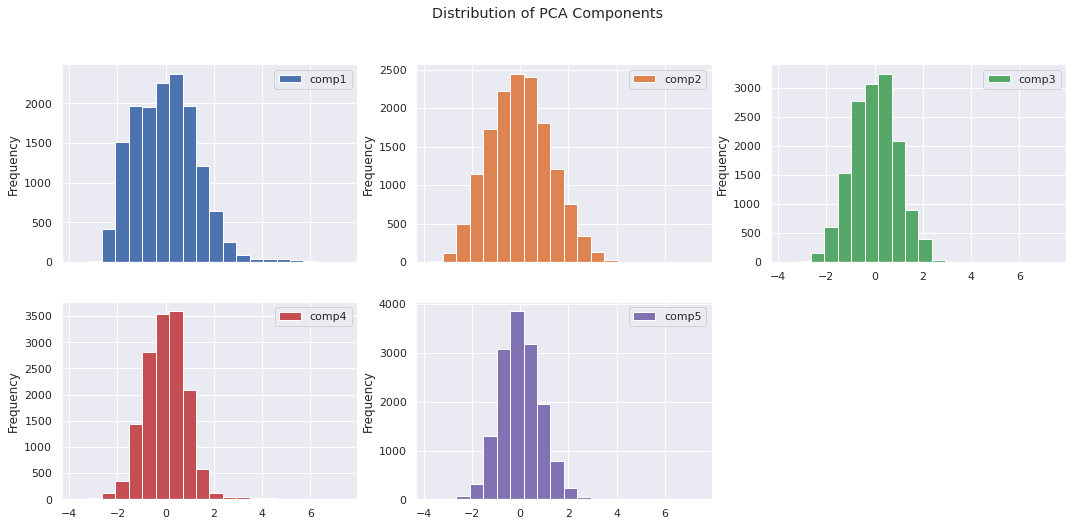

In [138]:
# Normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(fmt[["male", "age", "income", "frequency", "monetary", "tenure"]])

# PCA
pca = PCA(n_components=5, random_state=0)
user_pca = pd.DataFrame(pca.fit_transform(scaled), columns=["comp" + str(i) for i in range(1, 6)])
user_pca.plot(kind='hist', bins=20, figsize=(18, 8), subplots=True, layout=(2, 3), title='Distribution of PCA Components')

In [139]:
# Add components to FMT data

fmt = pd.concat([fmt, user_pca], axis=1)
pca.explained_variance_ratio_

array([0.28691816, 0.26401487, 0.14821769, 0.13255764, 0.11507985])

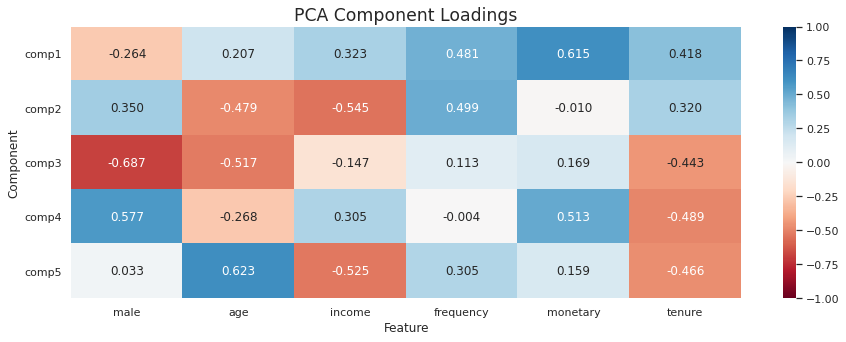

In [140]:
# Heatmap for PCA Components vs the Features
user_comps = pd.DataFrame(pca.components_, index=user_pca.columns, columns=['male', 'age', 'income', 'frequency', 'monetary', 'tenure'])

plt.figure(figsize=(15, 5))
sns.heatmap(user_comps, annot=True, vmin=-1, vmax=1, cmap='RdBu', fmt='.3f')
plt.title("PCA Component Loadings", fontsize='x-large')
plt.xlabel("Feature")
plt.ylabel("Component")
plt.yticks(rotation=0)
plt.show()

##### Observations:

Gender was reduced to a binary feature that indicates whether the user is male because there is a very low number of "other" users so they were grouped with "female" users to represent non-male users. 

Since this is still a categorical feature and K-means clustering wasn't meant for categorical features, PCA was applied to get new components (which are linear combinations of the original features) to perform clustering with. 

The 5 components account for almost 95% of the explained variance.

These characterizations may not capture the entire essence of the component, but can give a general idea.
  - Component 1 - high spending amount
  - Component 2 - low income, high spending frequency
  - Component 3 - female, young, newer to the app
  - Component 4 - male, high spending amount, newer to the app
  - Component 5 - older, lower income, newer to the app

In [141]:
# Test different numbers of clusters

msd = [] # mean
for k in range(3, 15):
    kmeans = KMeans(k, random_state=0)
    kmeans.fit(user_pca)
    msd.append(np.sqrt(kmeans.inertia_ / user_pca.shape[0]))

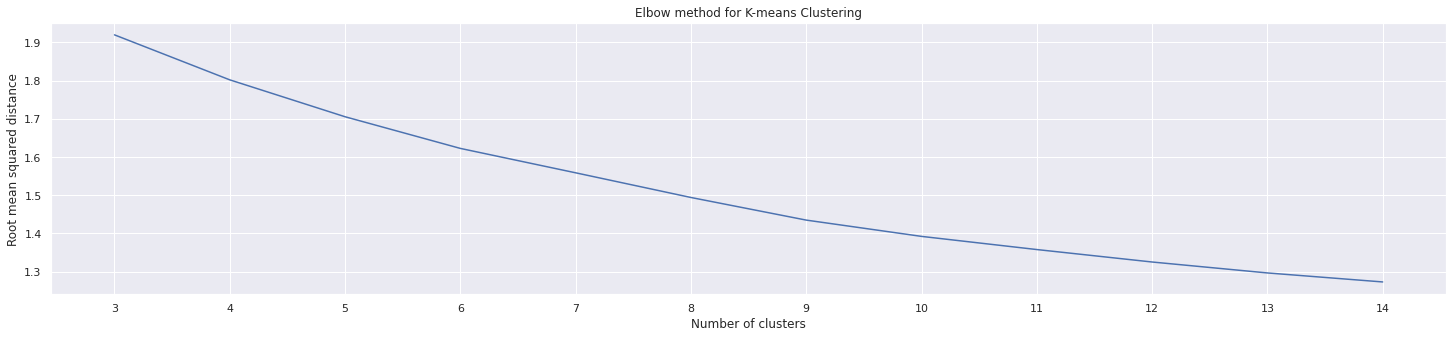

In [142]:
# Elbow method
plt.figure(figsize=(25, 5))

sns.lineplot(x=range(3, 15), y=msd)
plt.title("Elbow method for K-means Clustering")
plt.ylabel("Root mean squared distance")
plt.xlabel("Number of clusters")
plt.xticks(range(3, 15), range(3, 15));

In [143]:
# K-means clustering with 4 clusters
kmeans = KMeans(4, random_state=0)
kmeans.fit(user_pca)
fmt["cluster"] = kmeans.labels_

# Cluster summary
feats = ["male", "age", "income", "frequency", "monetary", "tenure", "comp1", "comp2", "comp3", "comp4", "comp5"]
cluster_means = segment_means(fmt, feats, "cluster")

In [144]:
cluster_means

male    age    income  frequency  monetary  tenure  comp1  comp2  \
cluster                                                                     
0        1.00  51.62  58959.35       4.76     47.38    8.64  -1.27   0.02   
1        0.75  46.62  51901.02      12.83    116.99   32.21   0.54   1.52   
2        0.45  63.70  87629.57      10.12    287.89   23.38   1.71  -0.55   
3        0.00  58.34  70120.36       5.46     84.69   12.51  -0.13  -1.00   

         comp3  comp4  comp5  n_users  pct_users  
cluster                                           
0        -0.34   0.50   0.12     4650      31.37  
1        -0.25  -0.37  -0.10     3536      23.85  
2        -0.16   0.51  -0.04     2651      17.88  
3         0.72  -0.60  -0.02     3988      26.90

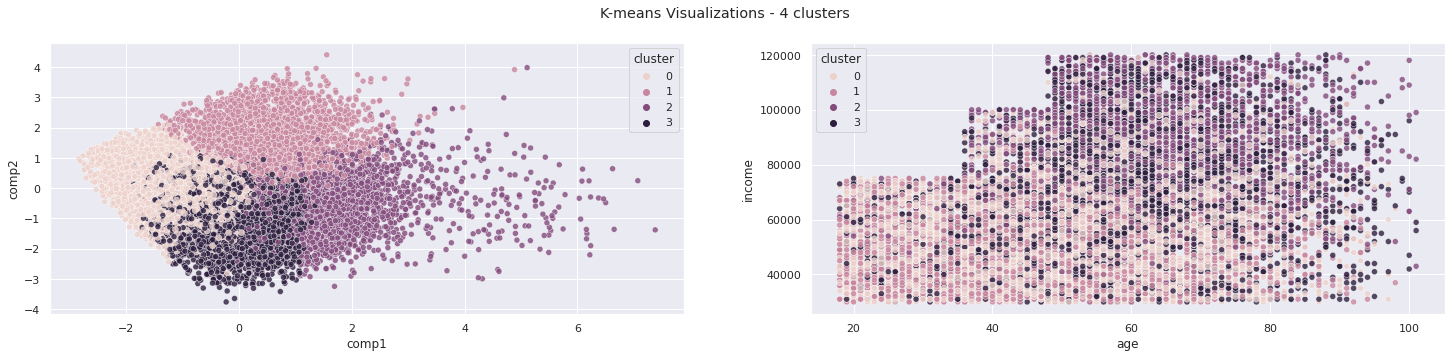

In [145]:
# Visualize clusters
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
sns.scatterplot(data=fmt, x='comp1', y='comp2', hue='cluster', ax=ax[0], alpha=0.8) # first 2 components
sns.scatterplot(data=fmt, x='age', y='income', hue='cluster', ax=ax[1], alpha=0.8); # age vs income
fig.suptitle('K-means Visualizations - 4 clusters');

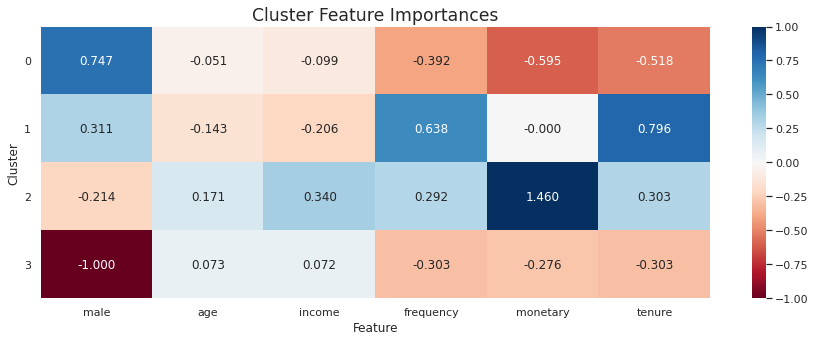

In [146]:
# Feature importances of
feats = ["male", "age", "income", "frequency", "monetary", "tenure"]
overall_means = fmt[feats].mean()
feat_importances = cluster_means.iloc[:, :6] / overall_means - 1

# Heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(feat_importances, annot=True, vmin=-1, vmax=1, cmap='RdBu', fmt='.3f')
plt.title("Cluster Feature Importances", fontsize='x-large')
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.yticks(rotation=0)
plt.show()

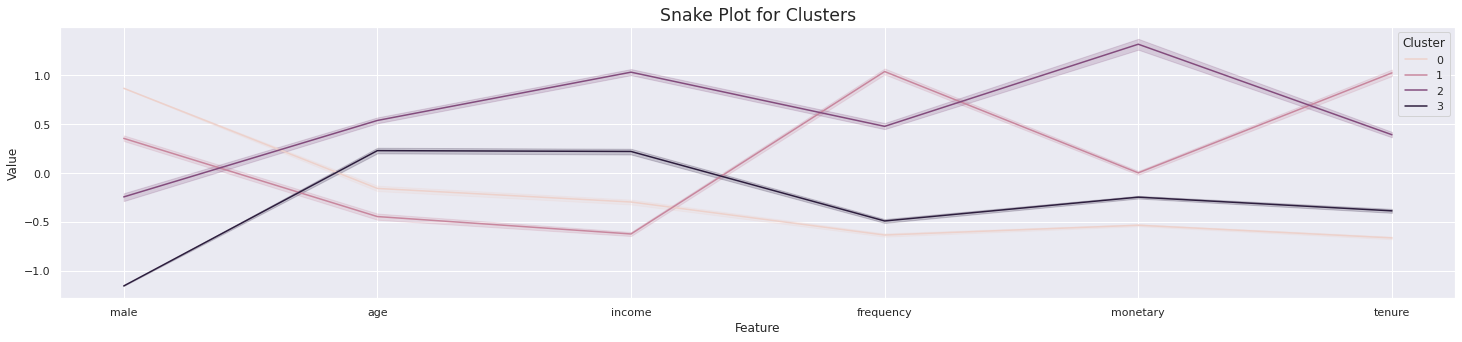

In [147]:
# Snake plot
snake_plot(fmt, feats, segment_col='cluster', legend_title='Cluster')

##### Observations:

The clusters were named using the snake plot. The general description of each cluster is as follows:
 
  - Cluster 0 (female low spenders) - users in this group are predominantly female with average to slightly above average age and income, and do not spend very much money
There is a small number of "other" users and no male users
  
  - Cluster 1 (low earners) - users in this group are younger and are low earners, who spend frequently but in small amounts
  
  - Cluster 2 (high earners) - users in this group are older and have the highest income compared to the other clusters, who also spend the most money
  
  - Cluster 3 (male low spenders) - users in this group are all male with average to a little below average age and income, and spend the least compared to the other clusters


In [148]:
dict_cluster_map = {0: "Male low spenders", 1: "Low earners", 2: "High earners", 3: "Female low spenders"}
fmt["customer_cluster"] = fmt.cluster.map(dict_cluster_map)

In [149]:
fmt.head()

frequency  monetary  tenure  F  M  T  FMT  score  tier  \
customer_id                                                           
0                    8    127.60      16  4  6  2  462     12     2   
1                    5     79.46       7  2  4  1  241      7     1   
2                    8    196.86      30  4  7  3  473     14     3   
3                   12    154.05      21  5  6  2  562     13     3   
4                   14     48.34      14  6  3  2  632     11     2   

            customer_tier gender  age became_member_on   income  signup_year  \
customer_id                                                                    
0                  Silver      M   33       2017-04-21  72000.0         2017   
1                  Bronze      O   40       2018-01-09  57000.0         2018   
2                    Gold      F   59       2016-03-04  90000.0         2016   
3                    Gold      F   24       2016-11-11  60000.0         2016   
4                  Silver      F   26       2017-06-21  73000.0         2017   

             age_group  income_group  amount  spend_group  male     comp1  \
customer_id                                                                 
0                    1             4  127.60            7     1 -0.374715   
1                    2             2   79.46            5     0 -0.778955   
2                    3             5  196.86            9     0  1.482611   
3                    1             3  154.05            8     0  0.544624   
4                    1             4   48.34            4     0  0.253138   

                comp2     comp3     comp4     comp5  cluster  \
customer_id                                                    
0            0.697403  0.076584  1.031336 -0.810518        0   
1           -0.337117  1.512733 -0.327184 -0.209949        3   
2           -0.864339  0.215461 -0.498733 -0.764860        2   
3            1.066774  1.785490 -0.240180 -0.790609        1   
4            0.738427  1.768599 -0.261266 -0.803890        3   

                customer_cluster  
customer_id                       
0              Male low spenders  
1            Female low spenders  
2                   High earners  
3                    Low earners  
4            Female low spenders

In [150]:
# Plot the distribution of user demographics and FMT features in a segment.

def plot_user_demographics6(segment_df, segment, color, cols=["gender"] + feats[1:], segment_col="customer_cluster"):   
    # Extract cluster
    cluster = segment_df.loc[segment_df[segment_col] == segment, cols]
    
    # Histogram subplots
    fig, ax = plt.subplots(2, 3, figsize=(25, 10))
    fig.suptitle("Demographics of Cluster: " + segment.title(), fontsize='x-large')

    for i in range(3):
        sns.histplot(cluster[cols[i]], bins=20, color=color, ax=ax[0, i])
        sns.histplot(cluster[cols[i + 3]], bins=20, color=color, ax=ax[1, i])
    plt.tight_layout()

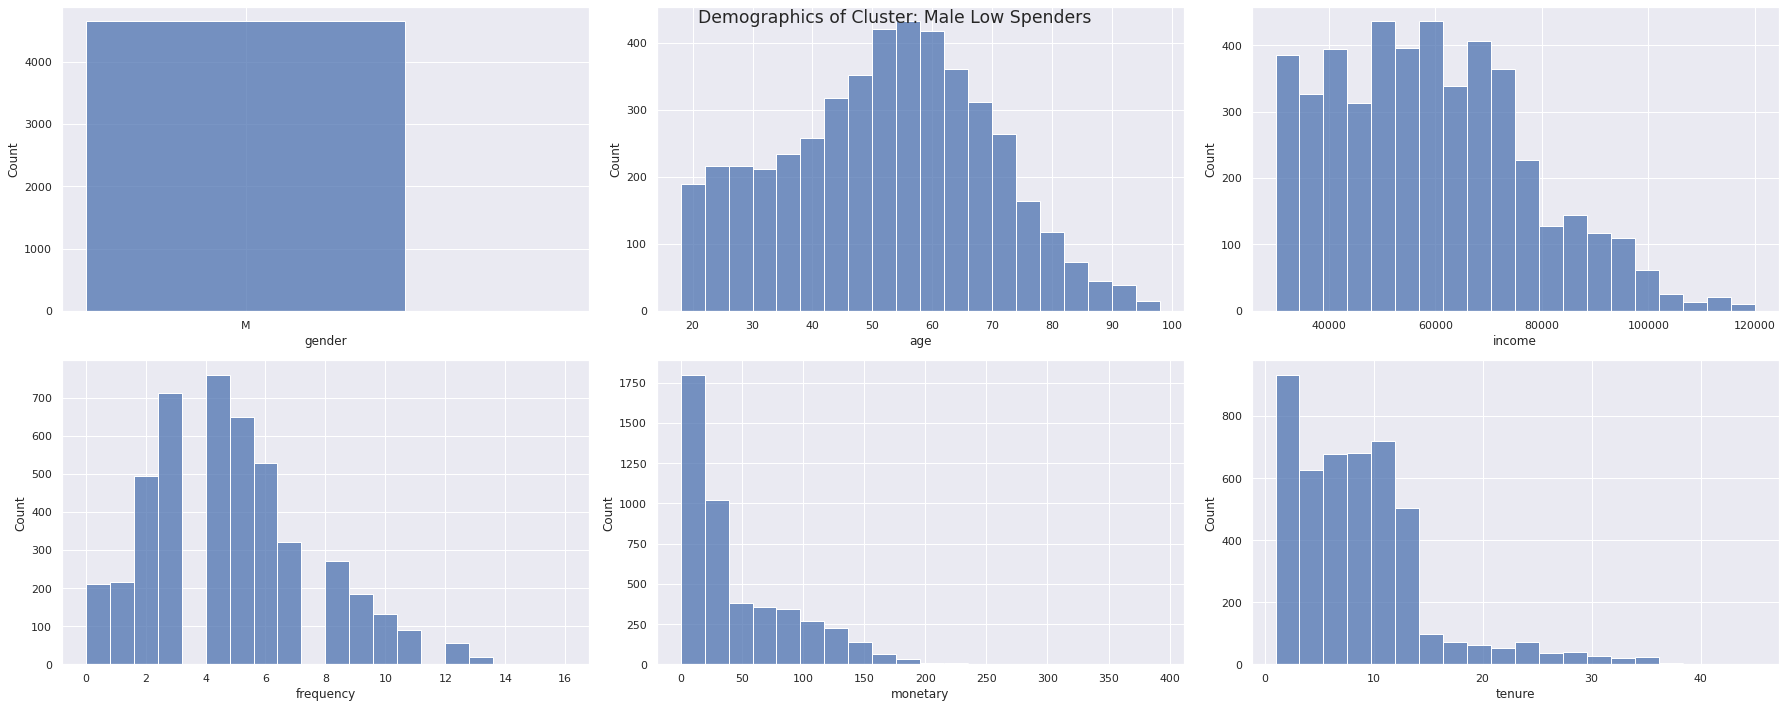

In [151]:
# Demographics of male low spenders

plot_user_demographics6(fmt, "Male low spenders", sns.color_palette()[0])

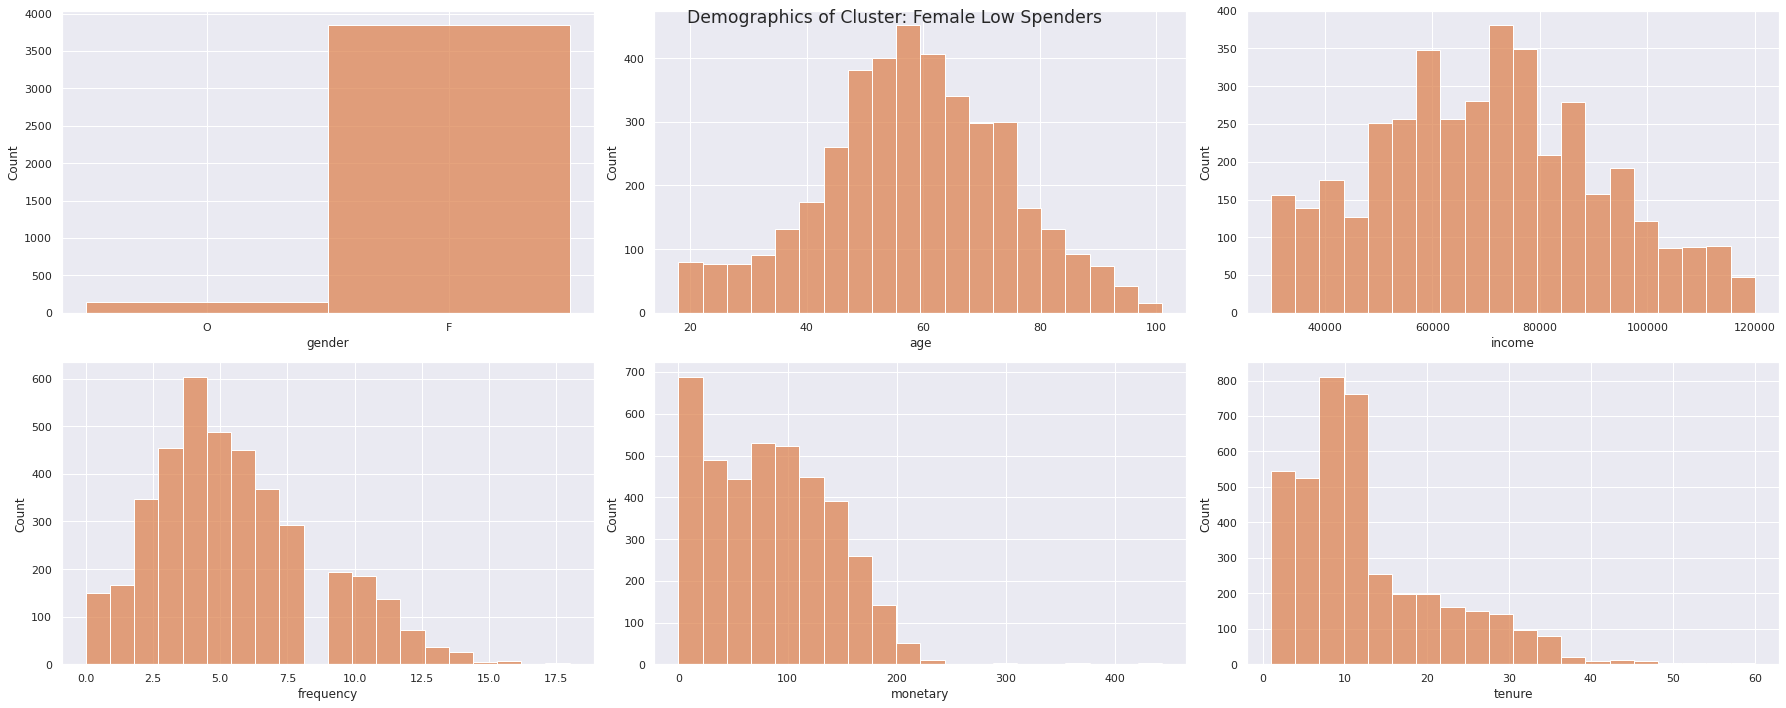

In [152]:
# Demographics of male low spenders

plot_user_demographics6(fmt, "Female low spenders", sns.color_palette()[1])

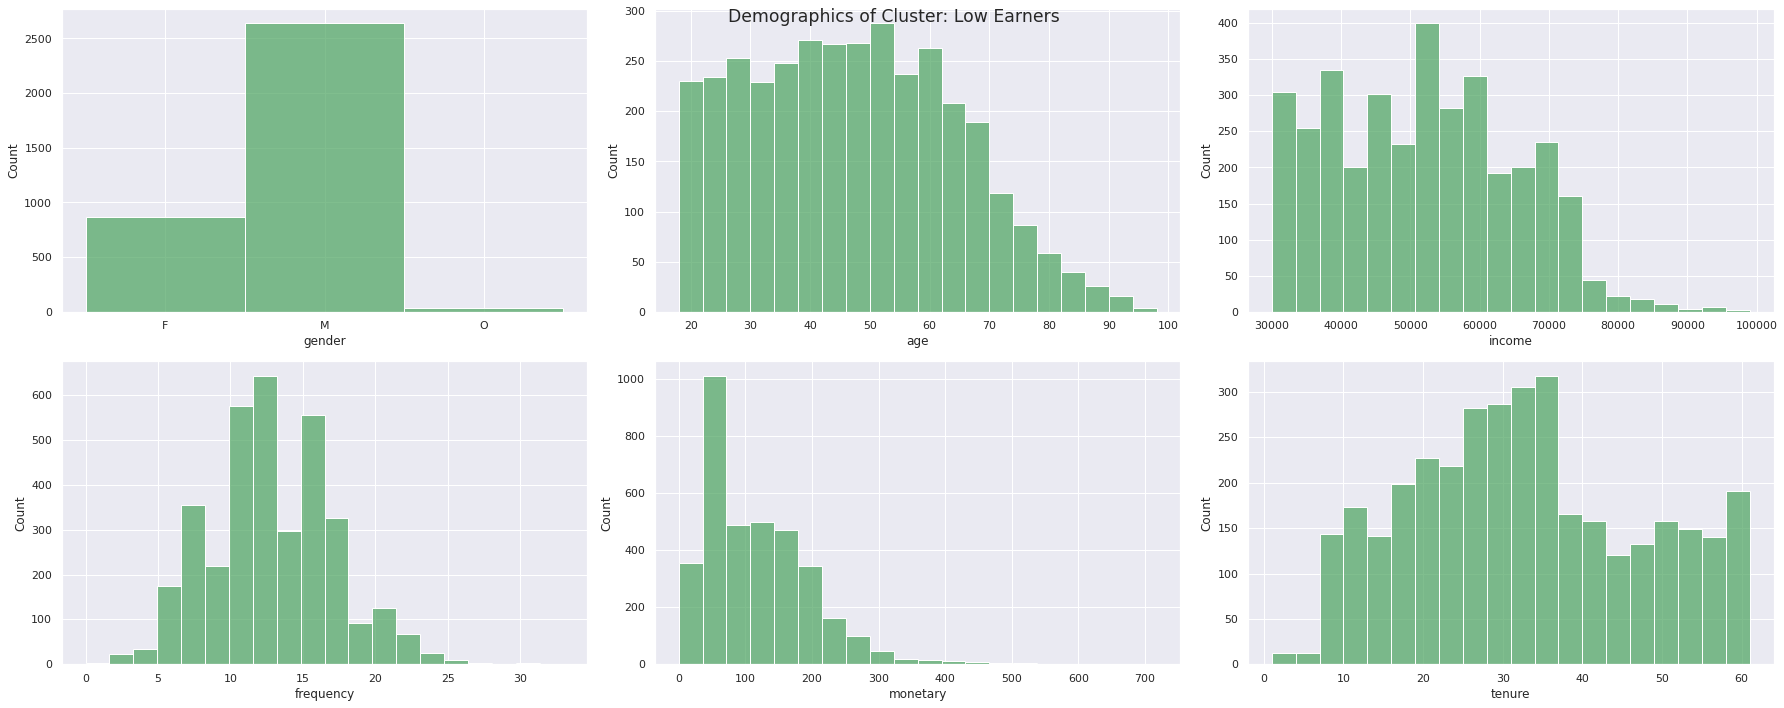

In [153]:
# Demographics of low earners

plot_user_demographics6(fmt, "Low earners", sns.color_palette()[2])

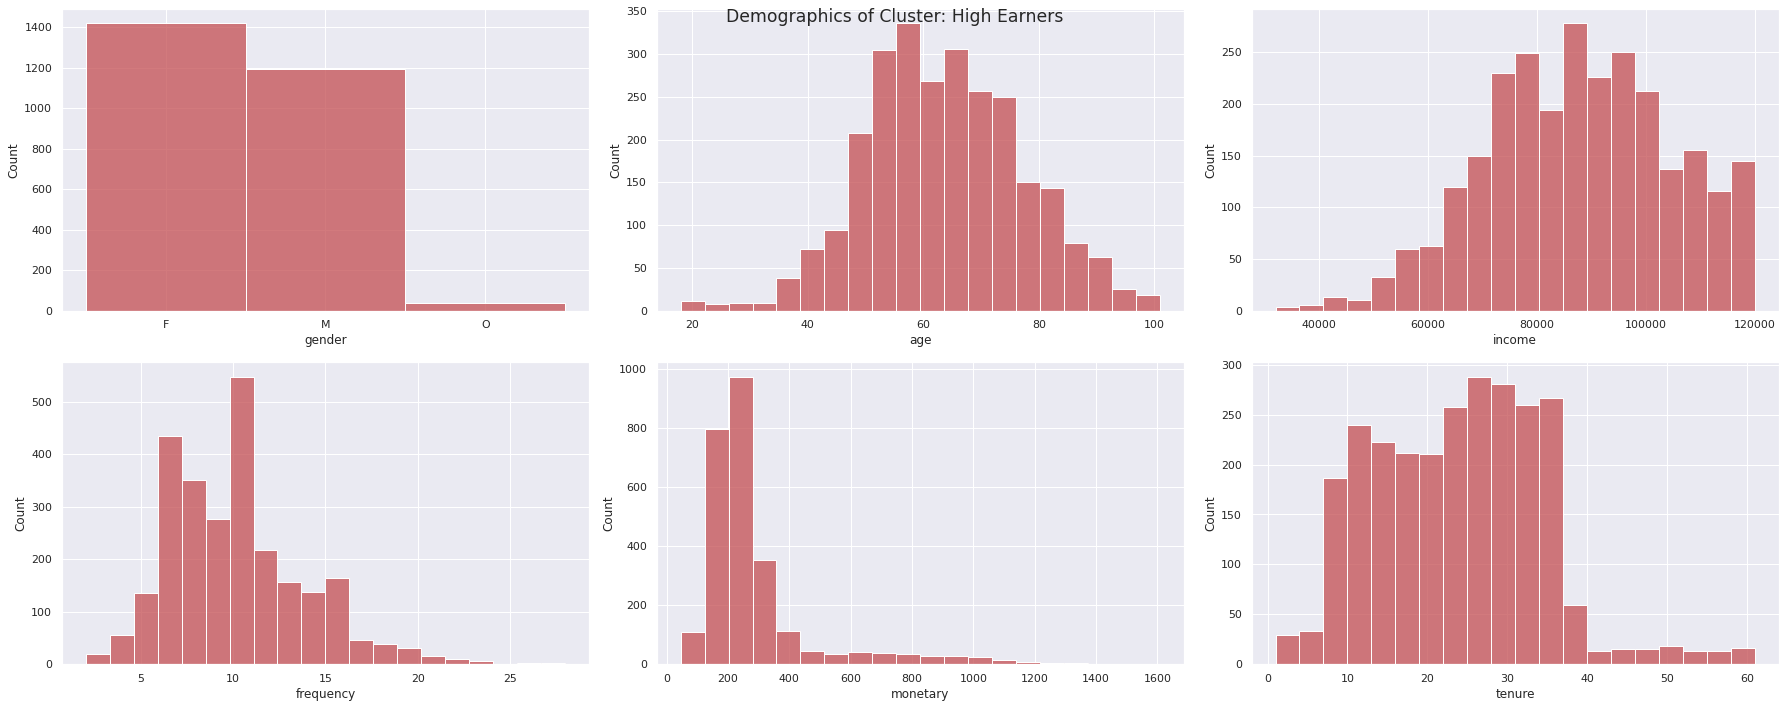

In [154]:
# Demographics of high earners

plot_user_demographics6(fmt, "High earners", sns.color_palette()[3])

##### Observations:

1. Male low spenders:
  - This group is entirely male and contains a lot of customers under the age of 40 relative to the other groups
  - Has the most number of customers with an income less than 80k
  - This group has even more low earners than the low earners group, but also has more higher earners to pull their average income higher than the low earners group 
  - Customers in this group spend the least money relative to the other groups
  - Most customers in this group have been using the app for less than a year

2. Female low spenders:
  - Except a few other-gendered customers, this group is entirely female
  - Age and income are both roughly normally distributed with means a little above the overall means
  - Customers in this group also do not spend a lot of money, despite having an average income that is higher than the overall mean
  - Again, most customers in this group have been using the app for less than a year, with some in the 2 and 3 year marks

3. Low earners:
  - There are 3 times as many male as female customers
  - This group contains the most younger customers
  - Most customers in this group have a salary of less than 75k
  - Customers in this group spend money frequently but have a low total amount, which means they are making many small transactions
  - Most customers in this group have been using the app for more than a year

4. High earners:
  - There are a little more female than male customers
  - There is a very low number of customers under the age of 40
  - Most customers in this group have a salary of more than 70k
  - Customers in this group don't spend as frequently as the low earners, but spend the most money relative to the other groups
  - Most customers in this group have been using the app between 1 and 3 years 

In [155]:
# Completion rate of clusters

# Merge cluster data into offer events
offers = pd.merge(offers, fmt.reset_index()[["customer_id", "cluster", "customer_cluster"]], on="customer_id", how="left")

# Extract true offers
true_offers = offers.query('event == "offer received" and group != 3')

In [156]:
true_offers.head()

index  customer_id           event  time  amount  reward_received  \
0      0         6962  offer received     0     0.0              0.0   
1      1        13107  offer received     0     0.0              0.0   
2      2         3246  offer received     0     0.0              0.0   
3      3         2669  offer received     0     0.0              0.0   
4      4         9940  offer received     0     0.0              0.0   

   offer_id  reward_offered  difficulty  duration     offer_type  email  \
0         6             5.0         5.0       7.0           bogo    1.0   
1         2             2.0        10.0       7.0       discount    1.0   
2         8             5.0         5.0       5.0           bogo    1.0   
3         3             0.0         0.0       4.0  informational    1.0   
4         0             5.0        20.0      10.0       discount    1.0   

   mobile  social  web  expire_time  oid_cid  viewed  completed  group gender  \
0     1.0     0.0  1.0        168.0   6_6962       1          1      4      F   
1     1.0     0.0  1.0        168.0  2_13107       1          0      2      M   
2     1.0     1.0  1.0        120.0   8_3246       1          1      4      M   
3     1.0     0.0  1.0         96.0   3_2669       0          0      1      M   
4     0.0     0.0  1.0        240.0   0_9940       1          0      2      F   

   age became_member_on    income  signup_year  age_group  income_group  \
0   75       2017-05-09  100000.0         2017          5             5   
1   68       2018-04-26   70000.0         2018          4             3   
2   65       2018-02-09   53000.0         2018          4             2   
3   58       2017-11-11   51000.0         2017          3             2   
4   61       2017-09-11   57000.0         2017          4             2   

   spend_group  frequency  monetary  tenure customer_tier  cluster  \
0            8          7    159.27      15        Silver        3   
1            4          3     57.73       4        Bronze        0   
2            3          3     36.43       6        Bronze        0   
3            2          3     15.62       9        Bronze        0   
4            5          6     85.55      11        Silver        3   

      customer_cluster  
0  Female low spenders  
1    Male low spenders  
2    Male low spenders  
3    Male low spenders  
4  Female low spenders

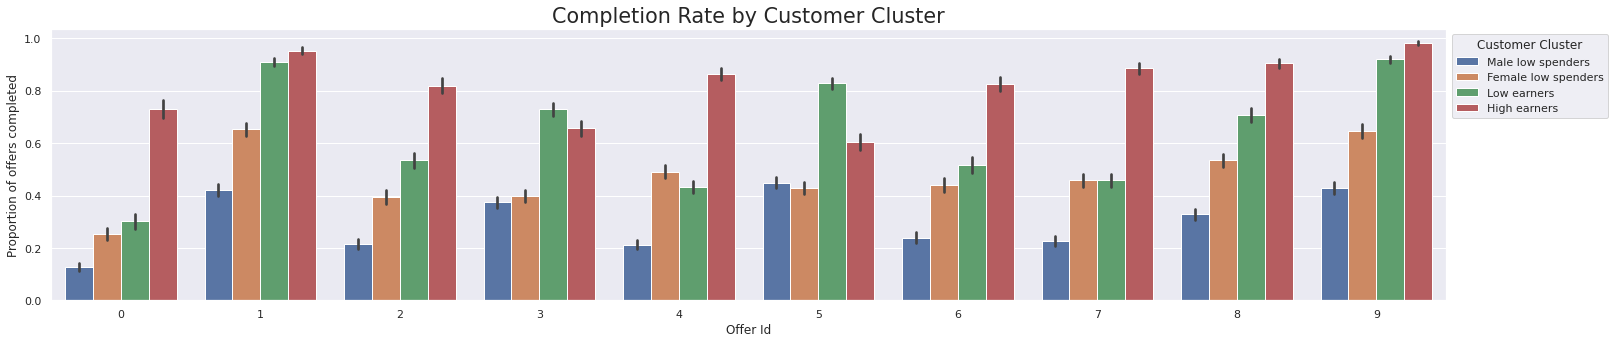

In [157]:
# Plot completion rate by cluster

plot_segment_completion(true_offers, hue="customer_cluster", hue_order=true_offers.groupby("customer_cluster")["monetary"].mean().sort_values().index)

##### Observations:

In the barplot above, the customer clusters were ordered based on their average monetary value, i.e. male low spenders spent the least and high earners spent the most money. 

We can see for most offers that as a group's average spending increases, so does the rate at which they complete offers.

The completion rates of male low spenders, low earners and high earners look similar to those of the bronze, silver, and gold tiers from the FMT segmentation respectively. So the same suggestions would apply to these clusters.

---

##### Observations:

Based on the customers' spending habits, the suggestions would be to :
  - Target the low spenders with the easier offers and lower the difficulty of the more difficult offers because they are currently not responding as much to the more difficult offers.

  - Send the high spenders more informational offers and raise the difficulty of their reward offers (discount and bogo), since they are much more likely to respond to most offers.

---

## **4. Model Buliding - Classification**

We will try to build a classifier to predict whether a customer will respond to an offer. This predictor will help us decide whether we should send customers a particular offer.

In [158]:
print("The shape of the dataset is : ", offers.shape)
offers.head()

The shape of the dataset is :  (148431, 34)


index  customer_id           event  time  amount  reward_received  \
0      0         6962  offer received     0     0.0              0.0   
1      1        13107  offer received     0     0.0              0.0   
2      2         3246  offer received     0     0.0              0.0   
3      3         2669  offer received     0     0.0              0.0   
4      4         9940  offer received     0     0.0              0.0   

   offer_id  reward_offered  difficulty  duration     offer_type  email  \
0         6             5.0         5.0       7.0           bogo    1.0   
1         2             2.0        10.0       7.0       discount    1.0   
2         8             5.0         5.0       5.0           bogo    1.0   
3         3             0.0         0.0       4.0  informational    1.0   
4         0             5.0        20.0      10.0       discount    1.0   

   mobile  social  web  expire_time  oid_cid  viewed  completed  group gender  \
0     1.0     0.0  1.0        168.0   6_6962       1          1      4      F   
1     1.0     0.0  1.0        168.0  2_13107       1          0      2      M   
2     1.0     1.0  1.0        120.0   8_3246       1          1      4      M   
3     1.0     0.0  1.0         96.0   3_2669       0          0      1      M   
4     0.0     0.0  1.0        240.0   0_9940       1          0      2      F   

   age became_member_on    income  signup_year  age_group  income_group  \
0   75       2017-05-09  100000.0         2017          5             5   
1   68       2018-04-26   70000.0         2018          4             3   
2   65       2018-02-09   53000.0         2018          4             2   
3   58       2017-11-11   51000.0         2017          3             2   
4   61       2017-09-11   57000.0         2017          4             2   

   spend_group  frequency  monetary  tenure customer_tier  cluster  \
0            8          7    159.27      15        Silver        3   
1            4          3     57.73       4        Bronze        0   
2            3          3     36.43       6        Bronze        0   
3            2          3     15.62       9        Bronze        0   
4            5          6     85.55      11        Silver        3   

      customer_cluster  
0  Female low spenders  
1    Male low spenders  
2    Male low spenders  
3    Male low spenders  
4  Female low spenders

### **4.1 Feature Engineering**

Now that we have completed the data exploration part, we can start the Feature Engineering in order to prepare the data for the ML algorithms.

In [159]:
# Since we are trying to predict whether a customer will respond to an offer if we send it to them, the only data of interest are "offer received" events.

received_offers = offers.query('event == "offer received"').copy()

In [160]:
# Drop columns that won't be used
to_drop = ["index", "event", "time", "expire_time", "oid_cid", "became_member_on", "signup_year", "customer_tier", "customer_cluster", "cluster"]

received_offers.drop(to_drop, axis=1, inplace=True)

#### **4.1.1 Feature Encoding**


In [161]:
# OHE Encoding "offer_type"

received_offers["info_offer"] = received_offers["offer_type"].apply(lambda t: int(t == "informational"))
received_offers["disc_offer"] = received_offers["offer_type"].apply(lambda t: int(t == "discount"))
received_offers["bogo_offer"] = received_offers["offer_type"].apply(lambda t: int(t == "bogo"))

In [162]:
# Encode gender: 1 : Male and 0 : Female and Others

received_offers["male"] = received_offers["gender"].apply(lambda g: int(g == 'M'))

In [163]:
# Creating the target dependent feature.
# The target label is whether or not the customer viewed and completed the offered. 
# If a customer completed an offer without viewing it first, that customer was not aware of the offer and spent the money anyway, which means there was no point in sending an offer.

received_offers["response"] = received_offers.apply(lambda o: int(o.viewed == o.completed == 1), axis=1)
received_offers["response"].value_counts()

0    38033
1    28468
Name: response, dtype: int64

#### **4.1.2 Dropping Irrelevant Features**

In [164]:
# Dropping features that are not needed

received_offers.drop(["offer_type", "gender", "offer_id", "reward_received", "customer_id", "age_group", "income_group", "viewed", "completed", "group", "amount"], axis=1, inplace=True)

#### **4.1.4 Feature Selection**

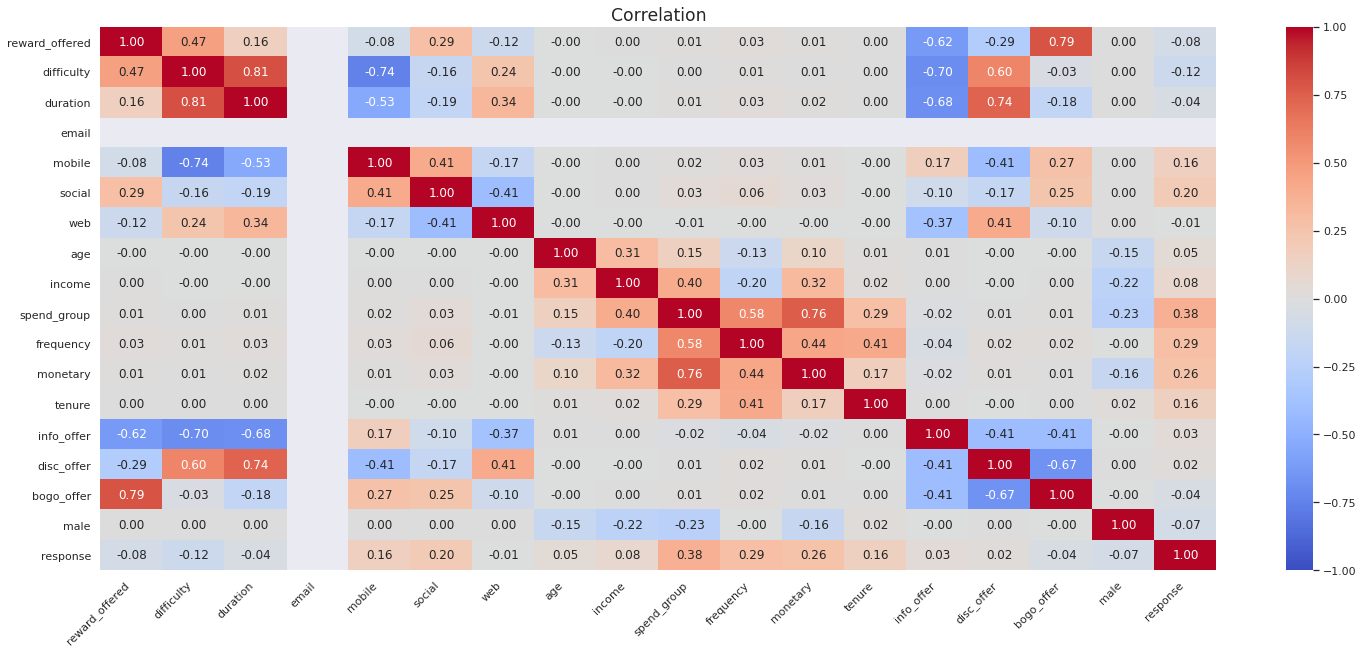

In [165]:


plt.figure(figsize=(25, 10))
sns.heatmap(received_offers.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='coolwarm')
plt.title("Correlation", fontsize='x-large')
plt.xticks(rotation=45, ha='right');

##### Observations:

We can drop "duration", "email", "mobile", "spend_group" as they are highly correlated with other independent features and causes multi-collinearity.

In [166]:
# Dropping features that are not needed

received_offers.drop(["duration", "email", "mobile", "spend_group"], axis=1, inplace=True)

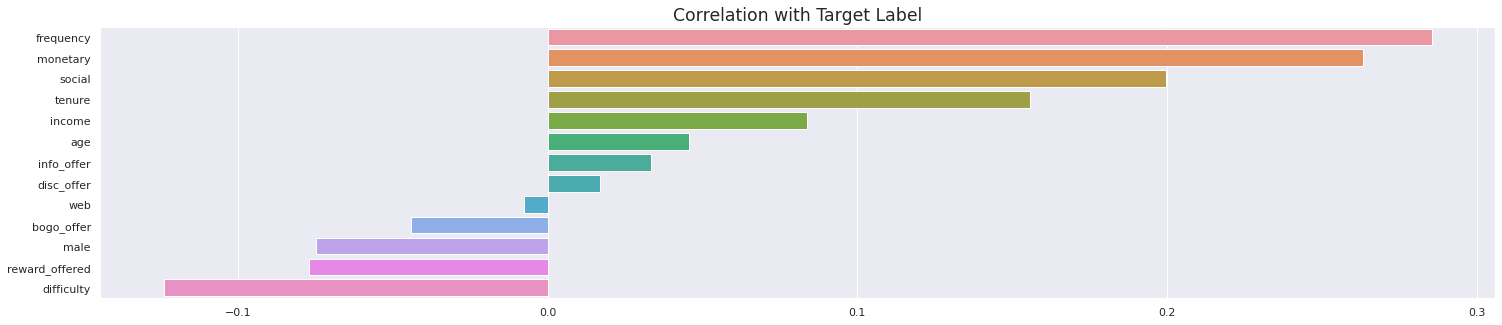

In [167]:
# Correlation with target

target_corr = received_offers.drop("response", axis=1).assign(target = received_offers["response"]).corr().iloc[-1, :-1].sort_values(ascending=False)

plt.figure(figsize=(25, 5))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Correlation with Target Label", fontsize='x-large');

#### **4.1.3 Feature Scaling**

In [168]:
# Applying MinMaxScaling to the data for faster convergence

scaler = MinMaxScaler()

In [169]:
# Scaling the features

scaled_offers_df = scaler.fit_transform(received_offers.drop("response", axis=1)) 
scaled_offers_df = pd.DataFrame(scaled_offers_df, columns=received_offers.columns[:-1])

In [170]:
received_offers.head()

reward_offered  difficulty  social  web  age    income  frequency  \
0             5.0         5.0     0.0  1.0   75  100000.0          7   
1             2.0        10.0     0.0  1.0   68   70000.0          3   
2             5.0         5.0     1.0  1.0   65   53000.0          3   
3             0.0         0.0     0.0  1.0   58   51000.0          3   
4             5.0        20.0     0.0  1.0   61   57000.0          6   

   monetary  tenure  info_offer  disc_offer  bogo_offer  male  response  
0    159.27      15           0           0           1     0         1  
1     57.73       4           0           1           0     1         0  
2     36.43       6           0           0           1     1         1  
3     15.62       9           1           0           0     1         0  
4     85.55      11           0           1           0     0         0

## **5. Model Building**

No we will split the dataset into train and test sets and apply ML algorithms.

In [394]:
# Creating independent feature dataframe for tree and non-tree based classification algorithms and dependent feature dataframe

y = received_offers[["response"]]
X_tree = received_offers.drop("response", axis=1)
X_nt = scaled_offers_df

### **5.1 Train/test Splitting**

We can split the data for train/test and segregate the independent and dependent features.

In [395]:
# Train/train split for tree based algorithms

X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree.values, y.values, test_size=0.2, stratify=y.values ,random_state=42)
print('X_train.shape: ', X_tree_train.shape, '\tX_test.shape: ', X_tree_test.shape, '\nY_train.shape: ', y_tree_train.shape, '\tY_test.shape: ', y_tree_test.shape)

X_train.shape:  (53200, 13) 	X_test.shape:  (13301, 13) 
Y_train.shape:  (53200, 1) 	Y_test.shape:  (13301, 1)


In [396]:
# Train/test spllit for non-tree based algorithms

X_nt_train, X_nt_test, y_nt_train, y_nt_test = train_test_split(X_nt.values, y.values, test_size=0.2, stratify=y.values ,random_state=42)
print('X_train.shape: ', X_tree_train.shape, '\tX_test.shape: ', X_tree_test.shape, '\nY_train.shape: ', y_tree_train.shape, '\tY_test.shape: ', y_tree_test.shape)

X_train.shape:  (53200, 13) 	X_test.shape:  (13301, 13) 
Y_train.shape:  (53200, 1) 	Y_test.shape:  (13301, 1)


### **5.2 Model Fitting**

Fitting various models and checking its accuracy.


In [ ]:
# Initializaing various classification algorithms. We are using Stratified Kfold with roc_auc as scoring parameter.

models = []
models.append(("BNB", BernoulliNB()))
models.append(("GNB", GaussianNB()))
models.append(("DTC", DecisionTreeClassifier()))
models.append(("RFC", RandomForestClassifier()))
models.append(("ABC", AdaBoostClassifier()))
models.append(("GBT", GradientBoostingClassifier()))
models.append(("XGB", XGBClassifier()))
models.append(("LGB", LGBMClassifier()))
models.append(("CBC", CatBoostClassifier(logging_level='Silent')))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_tree_train, y_tree_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

BNB: 0.651834 (0.004051)
GNB: 0.739231 (0.003230)
DTC: 0.656228 (0.005372)
RFC: 0.781344 (0.002331)
ABC: 0.780987 (0.003011)
GBT: 0.812008 (0.001165)
XGB: 0.811263 (0.001225)
LGB: 0.817728 (0.000634)
CBC: 0.815839 (0.000959)


In [ ]:
# Initializaing various classification algorithms

models = []
models.append(("LRE", LogisticRegression()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("SVM", SVC()))
models.append(("LSC", LinearSVC()))

#testing models
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X_nt_train, y_nt_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LRE: 0.752878 (0.002196)
KNN: 0.741038 (0.003947)
SVM: 0.789548 (0.001718)
LSC: 0.752436 (0.002103)


##### Observations:

LightGBM is giving us the best roc_auc scoring followed by similar score by GBT, xgboost and Catboost.

We can now try to optimize the parameters to check if we can get better results.

---

### **5.3 Hyper-parameter Optimization**

#### **5.3.1 Using Optuna to tune the hyper-parameters of Light Gradient Boosting Classifier**

In [ ]:
def lgb_objective(trial):
        
    # Save study
    joblib.dump(lgb_study, '/lgb_study.pkl')
    
    # LGB dataset objects
    
    X_tree_train_h, X_tree_val_h, y_tree_train_h, y_tree_val_h = train_test_split(X_tree_train, y_tree_train.ravel(), test_size=0.1, stratify = y_tree_train.ravel(), random_state = 42)
    
    dtrain = lgb.Dataset(X_tree_train_h, label=y_tree_train_h, params={'verbose': -1})
    dval = lgb.Dataset(X_tree_val_h, label=y_tree_val_h, params={'verbose': -1})
    
    # Parameter grid
    params = {
        'num_iterations': trial.suggest_int('num_iterations', 1_000, 20_000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 1e2),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 1e2),
        'max_depth': trial.suggest_int('max_depth', 2, 40),
        'num_leaves': trial.suggest_int('num_leaves', 2, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 400),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.6, 1.4),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'early_stopping_rounds': 40,
        'objective': 'binary',
        'seed': 0,
        'verbose': -1,
        'num_threads': -1
    }

    # Train model
    lgbm = lgb.train(params, dtrain, verbose_eval=False, valid_sets=[dtrain, dval], valid_names=['train', 'validation'])
    
    # Make predictions
    y_pred = lgbm.predict(X_tree_val_h)
    y_pred = y_pred.round().astype(int)
    return roc_auc_score(y_tree_val_h, y_pred)

In [ ]:
# Enable logging
optuna.logging.enable_default_handler()

# Run study
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=500)

print("Finished trials : ", len(lgb_study.trials))
print("Best trial : ", lgb_study.best_trial.value)
lgb_study.best_trial.params

[I 2020-11-03 05:00:13,313] A new study created in memory with name: no-name-6c3d2069-3b7e-4a70-9fb8-d7dd5ad6bfcb
[I 2020-11-03 05:00:15,560] Trial 0 finished with value: 0.754008818990459 and parameters: {'num_iterations': 19096, 'learning_rate': 0.05873511574179009, 'lambda_l1': 6.103696502925668, 'lambda_l2': 0.3582154529226426, 'max_depth': 32, 'num_leaves': 29, 'min_data_in_leaf': 350, 'scale_pos_weight': 1.3706924617133616, 'bagging_fraction': 0.6187920616534455, 'feature_fraction': 0.9478589577471735}. Best is trial 0 with value: 0.754008818990459.
[I 2020-11-03 05:00:39,380] Trial 1 finished with value: 0.6744901182884294 and parameters: {'num_iterations': 2651, 'learning_rate': 0.00023098270163542846, 'lambda_l1': 97.15574602332215, 'lambda_l2': 0.030431190179369943, 'max_depth': 5, 'num_leaves': 10, 'min_data_in_leaf': 388, 'scale_pos_weight': 0.8923293223602768, 'bagging_fraction': 0.8603972002700397, 'feature_fraction': 0.8600562542858567}. Best is trial 0 with value: 0.754

Finished trials :  500
Best trial :  0.7611893124330793


{'bagging_fraction': 0.5291264745635466,
 'feature_fraction': 0.6992650123561152,
 'lambda_l1': 0.00017912286929220095,
 'lambda_l2': 0.05658921800521694,
 'learning_rate': 0.006306984876271657,
 'max_depth': 32,
 'min_data_in_leaf': 206,
 'num_iterations': 1988,
 'num_leaves': 72,
 'scale_pos_weight': 1.3414158731484793}

In [ ]:
# Best parameters
lgb_params = lgb_study.best_trial.params
lgb_params["objective"] = "binary"
lgb_params["seed"] = 0
lgb_params["verbose"] = -1
lgb_params["num_threads"] = -1

# Increase number of iterations and decrease learning rate by the same ratio
lgb_params["num_iterations"] = 20000
lgb_params["learning_rate"] = 0.01

# LGB dataset objects
dtrain = lgb.Dataset(X_tree_train, label=y_tree_train.ravel(), params={'verbose': -1})

# Train model
lgbm = lgb.train(lgb_params, dtrain, verbose_eval=False)

# Make predictions
lgbm_train_pred = lgbm.predict(X_tree_train)
lgbm_test_pred = lgbm.predict(X_tree_test)

# Convert predictions to binary
lgbm_train_pred = lgbm_train_pred.round().astype(int)
lgbm_test_pred = lgbm_test_pred.round().astype(int)

The classification Report on Test Set using LGBM is as follows : 
               precision    recall  f1-score   support

           0       0.76      0.70      0.73      7607
           1       0.64      0.71      0.67      5694

    accuracy                           0.70     13301
   macro avg       0.70      0.70      0.70     13301
weighted avg       0.71      0.70      0.70     13301


Accuracy Score :  0.7024283888429441


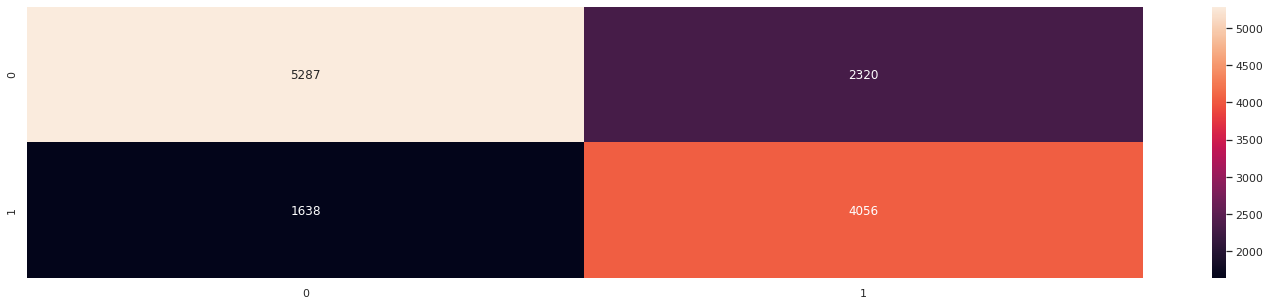

In [ ]:
# Evaluate predictions

print("The classification Report on Test Set using LGBM is as follows : \n", classification_report(y_tree_test, lgbm_test_pred))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_tree_test, lgbm_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

print("\nAccuracy Score : ", accuracy_score(y_tree_test, lgbm_test_pred))

##### Observations:
We are not getting very good testing accuracy with Light Gradient Boosting, so we will try to use other algorithm for it.

#### **5.3.2 Hyper-paramter Optimizaion for Xgboost**

In [ ]:
xgb_para = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
           }

xgb_clf = XGBClassifier()
kfold = StratifiedKFold(n_splits=5, random_state=10)
xgb_hypo = RandomizedSearchCV(estimator = xgb_clf, param_distributions = xgb_para, cv = kfold, scoring='roc_auc', verbose=2, random_state=42, n_jobs = -1)
xgb_hypo.fit(X_tree_train, y_tree_train)

print("\nThe best score is : ", xgb_hypo.best_score_)
print("\nThe best parametes are : \n", xgb_hypo.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished



The best score is :  0.8153258656380759

The best parametes are : 
 {'min_child_weight': 7, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.7}


The classification Report on Test Set using XGBoost is as follows : 
               precision    recall  f1-score   support

           0       0.76      0.75      0.76      7607
           1       0.68      0.68      0.68      5694

    accuracy                           0.72     13301
   macro avg       0.72      0.72      0.72     13301
weighted avg       0.72      0.72      0.72     13301


Accuracy Score :  0.724156078490339


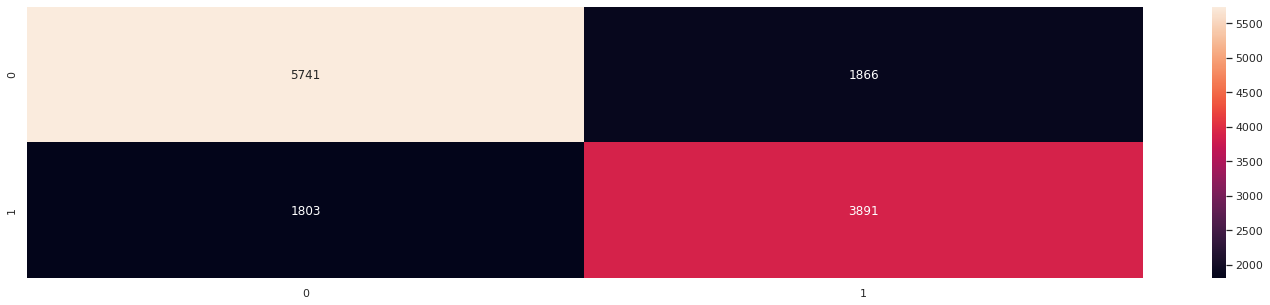

In [ ]:
# Train model
xgb_opt = XGBClassifier(n_estimators=1000, max_depth=8, min_child_weight=7, min_samples_split=40, learning_rate=0.1, gamma=0.3, colsample_bytree=0.7, random_state=0, )
xgb_opt.fit(X_tree_train, y_tree_train)

# Make predictions
xgb_test_pred = xgb_opt.predict(X_tree_test)

# Evaluate predictions
print("The classification Report on Test Set using XGBoost is as follows : \n", classification_report(y_tree_test, xgb_test_pred))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_tree_test, xgb_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

print("\nAccuracy Score : ", accuracy_score(y_tree_test, xgb_test_pred))

##### Observations:

The Xgboost classifier slightly improved upon the LGBT but still the accuracy remains to be 72%.

#### **5.3.3 Hyper-parameter Optizimation for RandomForest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state=0)
rf_params = {'max_samples': [0.4, 0.6, 0.8, None],
             'max_features': [0.25, 0.5, 0.75, None],
             'max_depth': [8, 10, 12, 20],
             'min_samples_split': [100, 60, 20, 2],
             'min_samples_leaf': [50, 30, 10, 1]}

kfold = StratifiedKFold(n_splits=5, random_state=10)
rf_search = RandomizedSearchCV(rf, rf_params, scoring='roc_auc', cv=kfold, verbose=1, n_jobs=-1)
rf_search.fit(X_tree_train, y_tree_train)

print("\nThe best score is : ", rf_search.best_score_)
print("\nThe best parametes are : \n", rf_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished



The best score is :  0.8185484116308321

The best parametes are : 
 {'min_samples_split': 60, 'min_samples_leaf': 10, 'max_samples': 0.4, 'max_features': 0.75, 'max_depth': 12}


The classification Report on Test Set using RFC is as follows : 
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      7607
           1       0.69      0.70      0.69      5694

    accuracy                           0.74     13301
   macro avg       0.73      0.73      0.73     13301
weighted avg       0.74      0.74      0.74     13301


Accuracy Score :  0.7382151717915946


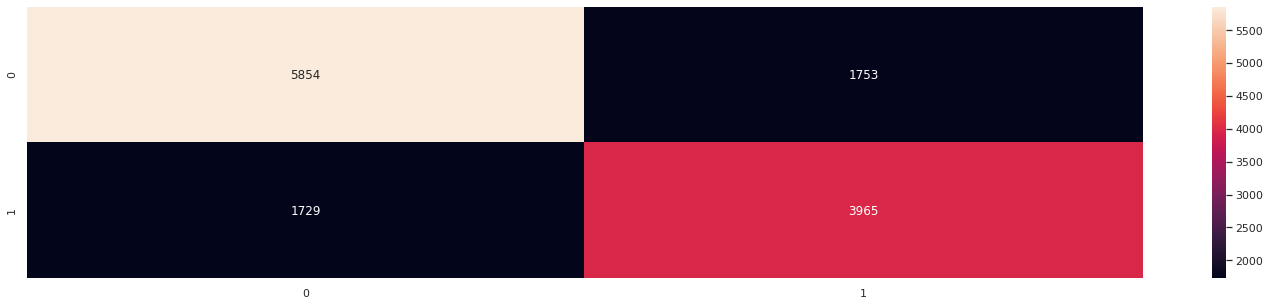

In [ ]:
# Train model
rf_opt = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=60, min_samples_leaf=10, criterion = "gini")
rf_opt.fit(X_tree_train, y_tree_train)

# Make predictions
rf_test_pred = rf_opt.predict(X_tree_test)

# Evaluate predictions
print("The classification Report on Test Set using RFC is as follows : \n", classification_report(y_tree_test, rf_test_pred))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_tree_test, rf_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

print("\nAccuracy Score : ", accuracy_score(y_tree_test, rf_test_pred))

##### Observations:

The accuracy improves slightly to 73%, so we will try one more algorithm.

#### **5.3.4 Hyper-parameter Optizimation for SVM**

In [ ]:
svc = SVC()
svc_params = {'C': np.logspace(-1, 3, 5), 'gamma': np.logspace(-3, 1, 5)}

kfold = StratifiedKFold(n_splits=3, random_state=10)
svc_search = RandomizedSearchCV(svc, svc_params, scoring='roc_auc', cv=kfold, n_jobs=4, verbose=2)
svc_search.fit(X_nt_train, y_nt_train)

print(svc_search.best_score_)
print(svc_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 146.7min finished


0.7934641535134448
{'gamma': 1.0, 'C': 10.0}


The classification Report on Test Set using RFC is as follows : 
               precision    recall  f1-score   support

           0       0.75      0.80      0.77      7607
           1       0.70      0.64      0.67      5694

    accuracy                           0.73     13301
   macro avg       0.72      0.72      0.72     13301
weighted avg       0.73      0.73      0.73     13301


Accuracy Score :  0.7298699345913842


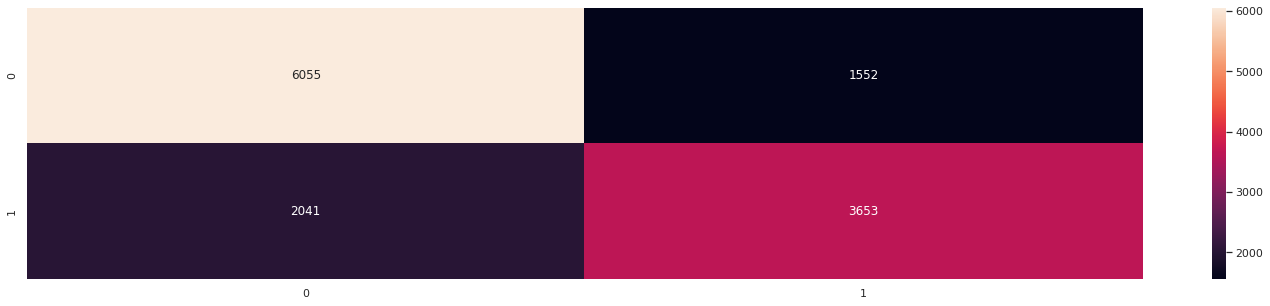

In [ ]:
# Train model
svc = svc_search.best_estimator_
svc.fit(X_nt_train, y_nt_train)

# Make predictions
svc_test_pred = svc.predict(X_nt_test)

# Evaluate predictions
print("The classification Report on Test Set using RFC is as follows : \n", classification_report(y_nt_test, svc_test_pred))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_nt_test, svc_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='g')

print("\nAccuracy Score : ", accuracy_score(y_nt_test, svc_test_pred))

##### Observations:

Event SVMs didn't drastically improve the accuracy and f1-score.


----

#### **5.3.5 Applying Artificial Neural Networks**

In [397]:
model = Sequential()
model.add(Dense(36, input_dim=X_nt_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [398]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

In [399]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [400]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 36)                504       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 296       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [401]:
training = model.fit(X_nt_train, y_nt_train, epochs=200, batch_size=500)

Epoch 1/200
107/107 [==============================] - 0s 3ms/step - loss: 0.6393 - tp: 9099.0000 - fp: 5794.0000 - tn: 24632.0000 - fn: 13675.0000 - accuracy: 0.6340 - precision: 0.6110 - recall: 0.3995 - auc: 0.6774
Epoch 2/200
107/107 [==============================] - 0s 3ms/step - loss: 0.5892 - tp: 12644.0000 - fp: 6237.0000 - tn: 24189.0000 - fn: 10130.0000 - accuracy: 0.6923 - precision: 0.6697 - recall: 0.5552 - auc: 0.7477
Epoch 3/200
107/107 [==============================] - 0s 3ms/step - loss: 0.5731 - tp: 13111.0000 - fp: 6142.0000 - tn: 24284.0000 - fn: 9663.0000 - accuracy: 0.7029 - precision: 0.6810 - recall: 0.5757 - auc: 0.7647
Epoch 4/200
107/107 [==============================] - 0s 4ms/step - loss: 0.5641 - tp: 13340.0000 - fp: 5997.0000 - tn: 24429.0000 - fn: 9434.0000 - accuracy: 0.7099 - precision: 0.6899 - recall: 0.5858 - auc: 0.7748
Epoch 5/200
107/107 [==============================] - 0s 3ms/step - loss: 0.5595 - tp: 13458.0000 - fp: 6000.0000 - tn: 24426.

The classification Report on Test Set using RFC is as follows : 
               precision    recall  f1-score   support

           0       0.78      0.77      0.77      7607
           1       0.69      0.71      0.70      5694

    accuracy                           0.74     13301
   macro avg       0.74      0.74      0.74     13301
weighted avg       0.74      0.74      0.74     13301


Accuracy Score :  0.7416735583790692


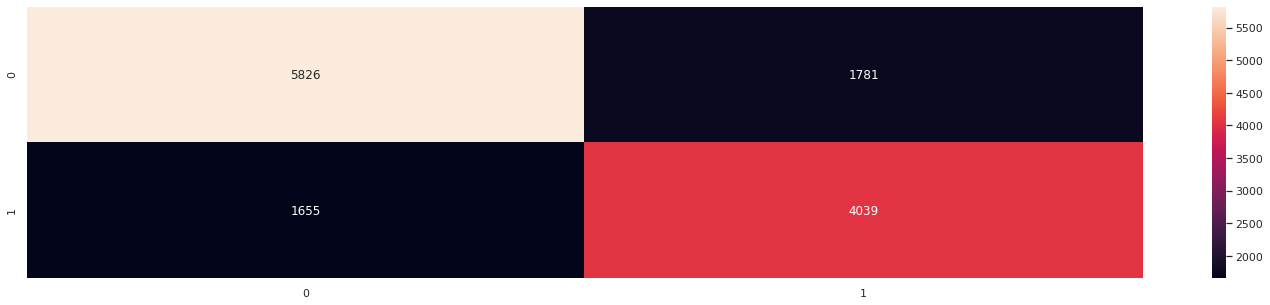

In [402]:
# Make predictions
y_pred3 = model.predict(X_nt_test).ravel()

y_pred3 = [1 if x >= 0.5 else 0 for x in y_pred3]

# Evaluate predictions
print("The classification Report on Test Set using RFC is as follows : \n", classification_report(y_nt_test, y_pred3))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_nt_test, y_pred3)
sns.heatmap(cf_matrix, annot=True, fmt='g')

print("\nAccuracy Score : ", accuracy_score(y_nt_test, y_pred3))

##### Observations:

We are getting the accuracy of around 74% with f1-score of 70%.

---

### **5.4 Saving the Model**

Saving the model

In [403]:
model.save("customer_response_prediction.h5")

In [237]:
cat_feature_columns = {
    "channel" : ["social", "web"],
    "offer_type" : ["bogo", "discount", "informational"],
    "data_columns" : [col for col in received_offers.columns]
}

with open("data_columns_clf.json", "w") as f:
    f.write(json.dumps(cat_feature_columns))

---

## **6. Model Buliding - Regression**

We will try to build a regression model to predict the amount spent by a customer based on the offer sent to them.

This predictor will help us decide the importance of sending various offers to customers.


In [283]:
# Creating a df by merging transcript and portfolio on offer_id, sorting it based on customer_id and index(transaction order) and filling the missing values by -1

info_events = transcript.merge(portfolio, how="left", on="offer_id")
info_events.rename(columns = {"reward_y" : "reward_offered", "reward_x" : "reward_received"}, inplace=True)
info_events.reset_index(inplace=True)
info_events = info_events.sort_values(["customer_id", "index"]).reset_index(drop=True)

In [284]:
# Finding the index of transaction for reward offers so that these transactions can be filtered out

transaction_event_idx_for_reward_offers = []
for idx, c_id, event in info_events[["customer_id", "event"]].itertuples():
    if event == "transaction":
        next_idx = idx+1
        if 0 <= next_idx < info_events.shape[0]:
            next_event = info_events.iloc[next_idx]
            if next_event.event == "offer completed" and next_event.customer_id == c_id:
                transaction_event_idx_for_reward_offers.append(idx)
                info_events.loc[idx, "offer_id"] = next_event.offer_id
                info_events.loc[idx, "offer_type"] = next_event.offer_type

In [285]:
# Saving the records with event as transactions mapped with their offer_id and Offer_type
transactional_data = info_events.iloc[transaction_event_idx_for_reward_offers, :].reset_index(drop=True)

In [286]:
# Filtering the df such that reward offers records are removed and we are left with offer types for informational offers
info_events = info_events[(info_events["event"] != "offer completed") & (~info_events["offer_type"].isin(["bogo", "discount"]))]

In [287]:
# Drop transactions of customers that did not receive an informational offer

users_with_info_offers = info_events.query('event != "transaction"').customer_id.unique()
info_events = info_events[info_events["customer_id"].isin(users_with_info_offers)]

In [288]:
# Add expiration hour (duration starts when the offer is viewed)
info_events["expire_time"] = info_events.apply(lambda e: -1 if e.event == "transaction" else e.duration * 24 + e.time, axis=1)

info_events = info_events.sort_values(['customer_id', 'index']).reset_index(drop=True)

# Create binary features to indicate whether the offer was viewed and completed
info_events["viewed"] = -1
info_events["completed"] = -1

In [289]:
# This will iterate throught the events and mark the viewed and completed features for grouping

for idx, c_id, o_id, event, exp_time in info_events[["customer_id", "offer_id", "event", "expire_time"]].itertuples():

    if event == "offer received":
        if 0 <= idx+1 < info_events.shape[0]:
            idx2 = idx+1
            event_2 = info_events.iloc[idx2]
            if event_2.customer_id == c_id:
                if event_2.event == "offer viewed":
                    next_idx = idx2+1
                    next_event = info_events.iloc[next_idx]
                    FillViewAndCompletedValueForOffers(1, 0, [idx, idx+1], info_events)
                    while next_event.event == "transaction" and next_event.customer_id == c_id:
                        if next_event.time <= exp_time and next_event.amount > 0:
                            FillViewAndCompletedValueForOffers(1, 1, [idx, idx+1, next_idx], info_events)
                            info_events.loc[next_idx, "offer_id"] = o_id
                            break
                        else:
                            FillViewAndCompletedValueForOffers(0, 0, [next_idx], info_events)
                        next_idx = next_idx + 1
                        if 0 <= next_idx < info_events.shape[0]:
                            next_event = info_events.iloc[next_idx]

                elif event_2.event == "transaction":
                    next_idx = idx2
                    next_event = event_2
                    idx_for_successful_offer_completion = [idx]
                    FillViewAndCompletedValueForOffers(0, 0, idx_for_successful_offer_completion, info_events)
                    while next_event.customer_id == c_id:
                        if next_event.event == "transaction":
                            if next_event.time <= exp_time and next_event.amount > 0:
                                idx_for_successful_offer_completion.append(next_idx)
                                FillViewAndCompletedValueForOffers(info_events.loc[idx, "viewed"], 1, idx_for_successful_offer_completion, info_events)
                                info_events.loc[next_idx, "offer_id"] = o_id
                            else:
                                FillViewAndCompletedValueForOffers(0, 0, [next_idx], info_events)
                            next_idx = next_idx + 1
                            if 0 <= next_idx < info_events.shape[0]:
                                next_event = info_events.iloc[next_idx]
                        elif next_event.event == "offer viewed":
                            idx_for_successful_offer_completion = []
                            idx_for_successful_offer_completion.append(idx)
                            idx_for_successful_offer_completion.append(next_idx)
                            if len(idx_for_successful_offer_completion) == 1:
                                FillViewAndCompletedValueForOffers(1, 0, idx_for_successful_offer_completion, info_events)
                            else:
                                FillViewAndCompletedValueForOffers(0, 1, idx_for_successful_offer_completion, info_events)
                                info_events.loc[next_idx, "offer_id"] = o_id                                
                            next_idx = next_idx + 1
                            if 0 <= next_idx < info_events.shape[0]:
                                next_event = info_events.iloc[next_idx]
                        else:
                            break
                else:
                      FillViewAndCompletedValueForOffers(0, 0, [idx], info_events)
            else:
                FillViewAndCompletedValueForOffers(0, 0, [idx], info_events)

    elif info_events.loc[idx, "viewed"] < 0 or info_events.loc[idx, "completed"] < 0:
        if event == "offer viewed":
            FillViewAndCompletedValueForOffers(1, 0, [idx], info_events)
        else:
            FillViewAndCompletedValueForOffers(0, 1, [idx], info_events)

In [290]:
# Filtering the transaction after mapping respective offer_id where ever the offer were completed.

info_transactions = info_events.query('event == "transaction" and offer_id >= 0').drop(["reward_offered", "difficulty", "duration", "offer_type", "email", "mobile", 
                                                                                        "social", "web", "expire_time", "viewed", "completed"], axis=1).reset_index(drop=True)

transactional_data = transactional_data.drop(["reward_offered", "difficulty", "duration", "offer_type", "email", "mobile", "social", "web"], axis=1)

In [291]:
# Merging the reward offer transactions and informational transactions

transactional_data = transactional_data.append(info_transactions).reset_index(drop=True)

In [292]:
# Merging the portfolio and profile data

transactional_data = transactional_data.merge(portfolio, how="left", on="offer_id")
transactional_data = transactional_data.merge(profile, how="left", on="customer_id")
transactional_data.rename(columns = {"reward_y" : "reward_offered", "reward_x" : "reward_received"}, inplace=True)
transactional_data.rename(columns = {"amount_x" : "amount", "amount_y" : "total_spent"}, inplace=True)
transactional_data.drop(["index", "event", "time"], axis=1, inplace=True)

In [293]:
print("The shape of the dataset is : ", transactional_data.shape)
transactional_data.head()

The shape of the dataset is :  (39832, 21)


customer_id  amount  reward_received  offer_id  reward  difficulty  \
0            0    8.57              0.0         8       5           5   
1            0   14.11              0.0         9       2          10   
2            0   10.27              0.0         2       2          10   
3            1   11.93              0.0         1       3           7   
4            1   22.05              0.0         0       5          20   

   duration offer_type  email  mobile  social  web gender  age  \
0         5       bogo    1.0     1.0     1.0  1.0      M   33   
1        10   discount    1.0     1.0     1.0  1.0      M   33   
2         7   discount    1.0     1.0     0.0  1.0      M   33   
3         7   discount    1.0     1.0     1.0  1.0      O   40   
4        10   discount    1.0     0.0     0.0  1.0      O   40   

  became_member_on   income  signup_year  age_group  income_group  \
0       2017-04-21  72000.0         2017          1             4   
1       2017-04-21  72000.0         2017          1             4   
2       2017-04-21  72000.0         2017          1             4   
3       2018-01-09  57000.0         2018          2             2   
4       2018-01-09  57000.0         2018          2             2   

   total_spent  spend_group  
0       127.60            7  
1       127.60            7  
2       127.60            7  
3        79.46            5  
4        79.46            5

### **6.1 Feature Engineering**

Now that we have completed the data exploration part, we can start the Feature Engineering in order to prepare the data for the ML algorithms.

#### **6.1.1 Feature Encoding**


In [294]:
# OHE Encoding "offer_type"

transactional_data["info_offer"] = transactional_data["offer_type"].apply(lambda t: int(t == "informational"))
transactional_data["disc_offer"] = transactional_data["offer_type"].apply(lambda t: int(t == "discount"))
transactional_data["bogo_offer"] = transactional_data["offer_type"].apply(lambda t: int(t == "bogo"))

In [295]:
# Encode gender: 1 : Male and 0 : Female and Others

transactional_data["male"] = transactional_data["gender"].apply(lambda g: int(g == 'M'))

In [296]:
ohe1 = OneHotEncoder()
offer_id_ohe = ohe1.fit_transform(transactional_data["offer_id"].ravel().reshape(-1,1))
offer_id_ohe = pd.DataFrame(offer_id_ohe.toarray(), columns = ["offer_id_" + str(col) for col in range(0,10)])

In [297]:
transactional_data = pd.concat([transactional_data, offer_id_ohe], axis = 1)

In [298]:
ref_date = transactional_data["became_member_on"].max() + pd.Timedelta(30, 'days')

# Calculate the tenure in months for all users
transactional_data["tenure"] = transactional_data["became_member_on"].apply(lambda d: (ref_date - d).days // 30)

In [299]:
transactional_data.head()

customer_id  amount  reward_received  offer_id  reward  difficulty  \
0            0    8.57              0.0         8       5           5   
1            0   14.11              0.0         9       2          10   
2            0   10.27              0.0         2       2          10   
3            1   11.93              0.0         1       3           7   
4            1   22.05              0.0         0       5          20   

   duration offer_type  email  mobile  social  web gender  age  \
0         5       bogo    1.0     1.0     1.0  1.0      M   33   
1        10   discount    1.0     1.0     1.0  1.0      M   33   
2         7   discount    1.0     1.0     0.0  1.0      M   33   
3         7   discount    1.0     1.0     1.0  1.0      O   40   
4        10   discount    1.0     0.0     0.0  1.0      O   40   

  became_member_on   income  signup_year  age_group  income_group  \
0       2017-04-21  72000.0         2017          1             4   
1       2017-04-21  72000.0         2017          1             4   
2       2017-04-21  72000.0         2017          1             4   
3       2018-01-09  57000.0         2018          2             2   
4       2018-01-09  57000.0         2018          2             2   

   total_spent  spend_group  info_offer  disc_offer  bogo_offer  male  \
0       127.60            7           0           0           1     1   
1       127.60            7           0           1           0     1   
2       127.60            7           0           1           0     1   
3        79.46            5           0           1           0     0   
4        79.46            5           0           1           0     0   

   offer_id_0  offer_id_1  offer_id_2  offer_id_3  offer_id_4  offer_id_5  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         1.0         0.0         0.0         0.0   
3         0.0         1.0         0.0         0.0         0.0         0.0   
4         1.0         0.0         0.0         0.0         0.0         0.0   

   offer_id_6  offer_id_7  offer_id_8  offer_id_9  tenure  
0         0.0         0.0         1.0         0.0      16  
1         0.0         0.0         0.0         1.0      16  
2         0.0         0.0         0.0         0.0      16  
3         0.0         0.0         0.0         0.0       7  
4         0.0         0.0         0.0         0.0       7

#### **6.1.2 Dropping irrelevant features**

In [300]:
# Dropping the features that are not needed anymore

transactional_data.drop(["customer_id", "offer_id", "reward", "difficulty", "duration", "offer_type", "gender", "became_member_on", "signup_year", "total_spent"], axis=1, inplace=True)

#### **6.1.3 Outlier Analysis**

In [301]:
transactional_data.head()

amount  reward_received  email  mobile  social  web  age   income  \
0    8.57              0.0    1.0     1.0     1.0  1.0   33  72000.0   
1   14.11              0.0    1.0     1.0     1.0  1.0   33  72000.0   
2   10.27              0.0    1.0     1.0     0.0  1.0   33  72000.0   
3   11.93              0.0    1.0     1.0     1.0  1.0   40  57000.0   
4   22.05              0.0    1.0     0.0     0.0  1.0   40  57000.0   

   age_group  income_group  spend_group  info_offer  disc_offer  bogo_offer  \
0          1             4            7           0           0           1   
1          1             4            7           0           1           0   
2          1             4            7           0           1           0   
3          2             2            5           0           1           0   
4          2             2            5           0           1           0   

   male  offer_id_0  offer_id_1  offer_id_2  offer_id_3  offer_id_4  \
0     1         0.0         0.0         0.0         0.0         0.0   
1     1         0.0         0.0         0.0         0.0         0.0   
2     1         0.0         0.0         1.0         0.0         0.0   
3     0         0.0         1.0         0.0         0.0         0.0   
4     0         1.0         0.0         0.0         0.0         0.0   

   offer_id_5  offer_id_6  offer_id_7  offer_id_8  offer_id_9  tenure  
0         0.0         0.0         0.0         1.0         0.0      16  
1         0.0         0.0         0.0         0.0         1.0      16  
2         0.0         0.0         0.0         0.0         0.0      16  
3         0.0         0.0         0.0         0.0         0.0       7  
4         0.0         0.0         0.0         0.0         0.0       7

Text(0.5, 0, ' ')

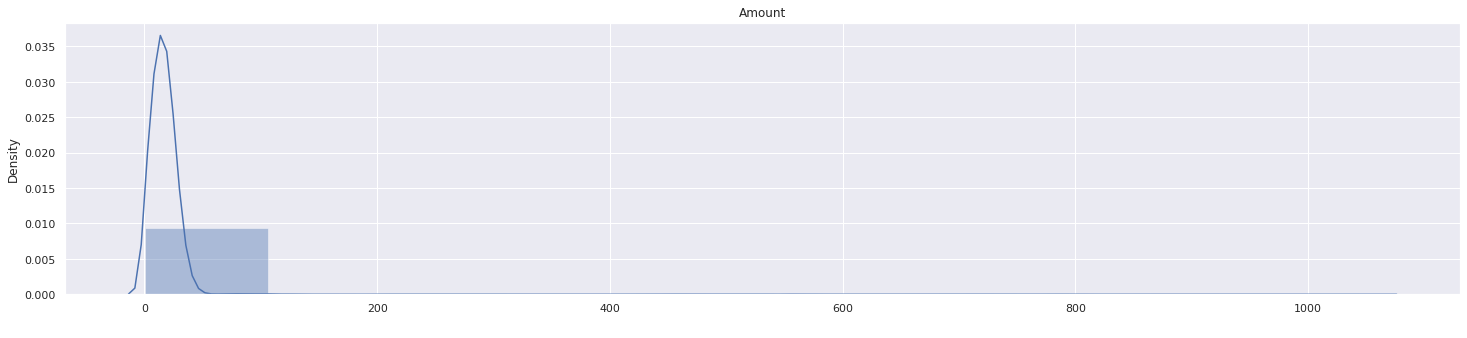

In [302]:
# Checking feature "rate"

sns.set(style="darkgrid")
plot_objects = plt.subplots(nrows=1, ncols=1, figsize=(25, 5))
fig, ax1 = plot_objects

sns.distplot(transactional_data["amount"], bins=10 , ax=ax1)
ax1.set_title("Amount")
ax1.set_xlabel(" ")

In [303]:
print("The basic statistics for the feature is :\n", transactional_data["amount"].describe())
print("The number of unique values in the feature is :", transactional_data["amount"].nunique())

The basic statistics for the feature is :
 count    39832.000000
mean        18.738583
std         38.189810
min          0.050000
25%          9.230000
50%         15.650000
75%         22.490000
max       1062.280000
Name: amount, dtype: float64
The number of unique values in the feature is : 4466


In [304]:
quantile_amount = transactional_data["amount"].quantile(np.round(np.arange(0, 1.00, 0.1), 2))
qValues = np.round(np.arange(0, 1.00, 0.1), 2)
for i in qValues:
    print("{}th percentile value of amount is {}".format((int(i*100)), quantile_amount[i]))

0th percentile value of amount is 0.05
10th percentile value of amount is 3.98
20th percentile value of amount is 7.4
30th percentile value of amount is 10.732999999999993
40th percentile value of amount is 13.13
50th percentile value of amount is 15.65
60th percentile value of amount is 18.235999999999983
70th percentile value of amount is 20.99
80th percentile value of amount is 24.21
90th percentile value of amount is 28.92


In [305]:
quantile_amount = transactional_data["amount"].quantile(np.round(np.arange(0.90, 1.00, 0.01), 2))
qValues = np.round(np.arange(0.90, 1.00, 0.01), 2)
for i in qValues:
    print("{}th percentile value of amount is {}".format((int(i*100)), quantile_amount[i]))

90th percentile value of amount is 28.92
91th percentile value of amount is 29.58
92th percentile value of amount is 30.3
93th percentile value of amount is 31.18
94th percentile value of amount is 32.121399999999994
95th percentile value of amount is 33.26449999999997
96th percentile value of amount is 34.55
97th percentile value of amount is 36.250699999999995
98th percentile value of amount is 38.913799999999966
99th percentile value of amount is 46.35380000000005


In [306]:
quantile_amount = transactional_data["amount"].quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
for i in qValues:
    print("{}th percentile value of amount is {}".format(((i*100)), quantile_amount[i]))

99.1th percentile value of amount is 49.66084000000002
99.2th percentile value of amount is 68.48319999999963
99.3th percentile value of amount is 81.96358999999799
99.4th percentile value of amount is 101.43448000000092
99.5th percentile value of amount is 125.90855000000069
99.6th percentile value of amount is 280.80807999999655
99.7th percentile value of amount is 421.7188699999924
99.8th percentile value of amount is 533.4733600000193
99.9th percentile value of amount is 695.7590000000017
100.0th percentile value of amount is 1062.28


In [307]:
print("The count of seemingly outlier values is: ", len(transactional_data[transactional_data["amount"] > transactional_data["amount"].quantile(0.990)]))
print("The percentage of seemingly outlier values is: ", len(transactional_data[transactional_data["amount"] > transactional_data["amount"].quantile(0.990)]) / len(transactional_data) )

The count of seemingly outlier values is:  399
The percentage of seemingly outlier values is:  0.010017071701144808


In [308]:
# Dropping the 399 outlier values.

transactional_data = transactional_data[transactional_data["amount"] <= transactional_data["amount"].quantile(0.990)]

Text(0.5, 0, ' ')

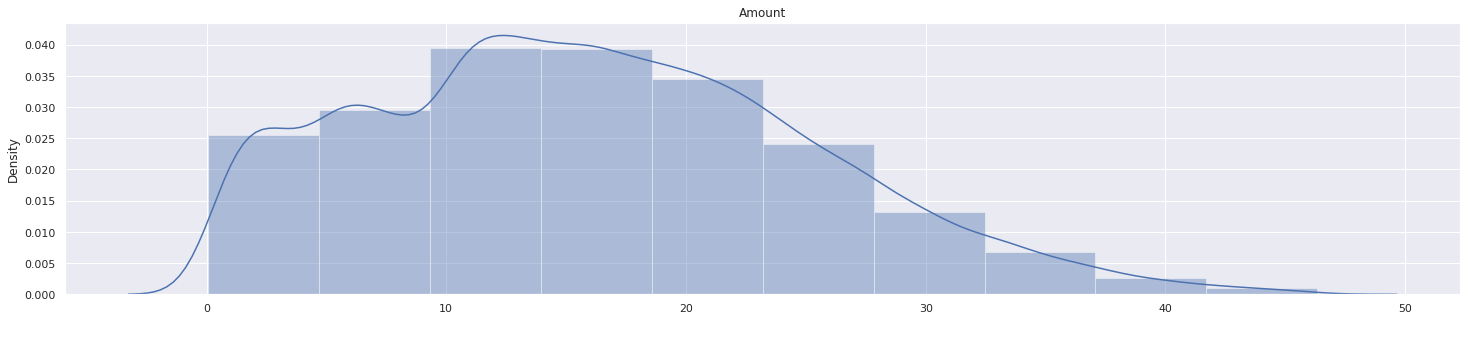

In [309]:
# Checking feature "amount"

sns.set(style="darkgrid")
plot_objects = plt.subplots(nrows=1, ncols=1, figsize=(25, 5))
fig, ax1 = plot_objects

sns.distplot(transactional_data["amount"], bins=10 , ax=ax1)
ax1.set_title("Amount")
ax1.set_xlabel(" ")

#### **6.1.3 Feature Selection**

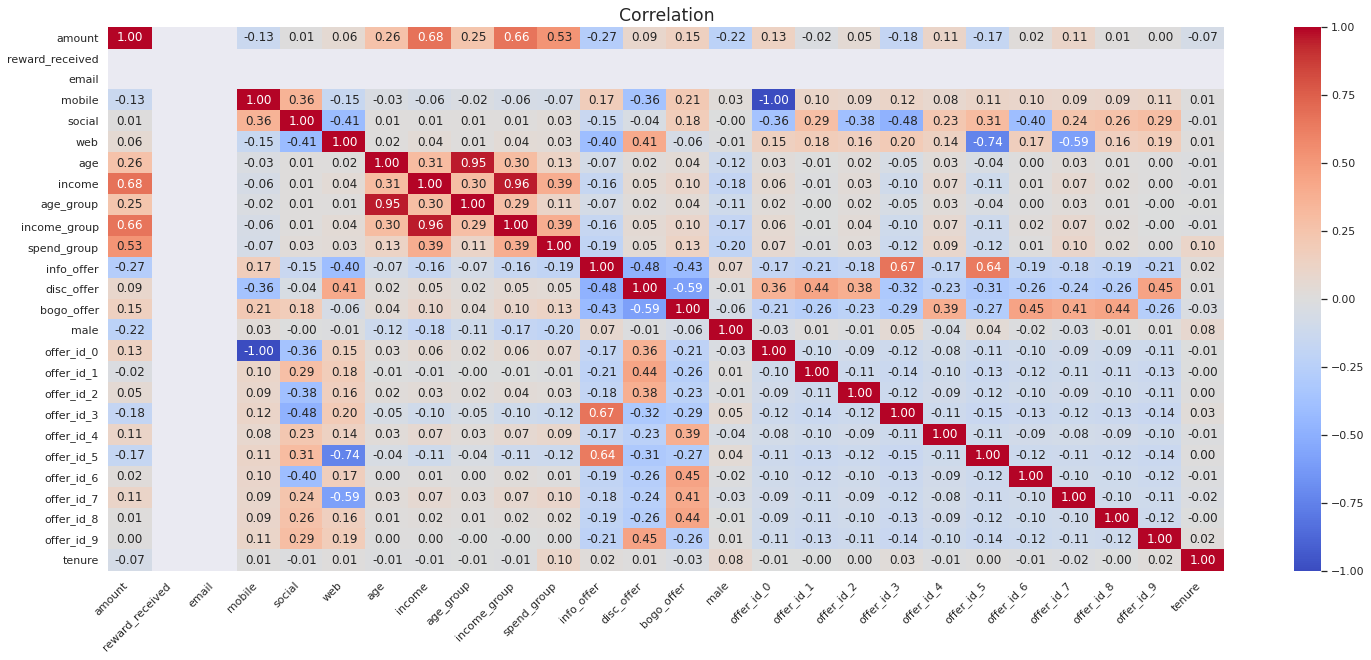

In [310]:
# Visualizing the heatmap

plt.figure(figsize=(25, 10))
sns.heatmap(transactional_data.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='coolwarm')
plt.title("Correlation", fontsize='x-large')
plt.xticks(rotation=45, ha='right');

##### Observations:

We can drop "reward_received, "email", "income", "age_group", "info_offer", "disc_offer", "bogo_offer" as they are irrelevant or other features are representative of it.

In [311]:
# Dropping features with less correlated with the dependent feature

transactional_data.drop(["reward_received", "email", "income", "age_group", "info_offer", "disc_offer", "bogo_offer"], axis=1, inplace=True)

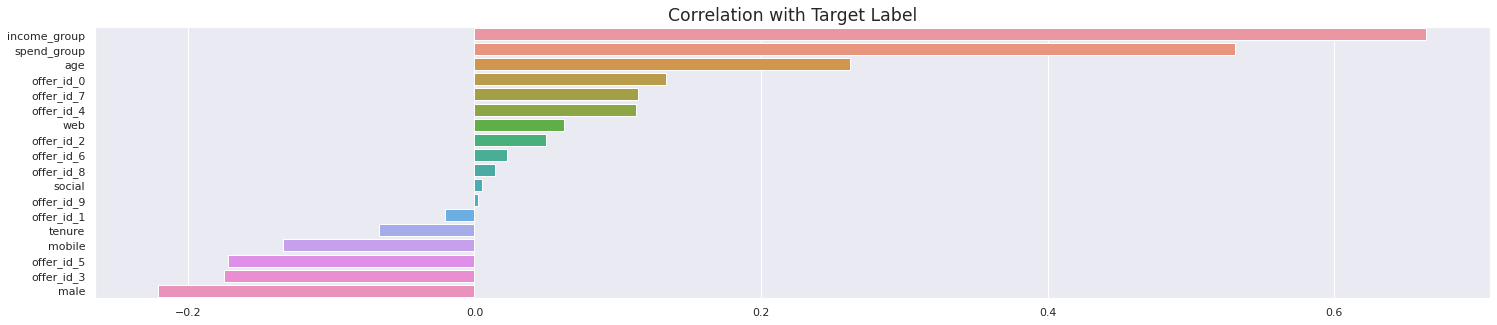

In [312]:
# Correlation with target

target_corr = transactional_data.drop("amount", axis=1).assign(target = transactional_data["amount"]).corr().iloc[-1, :-1].sort_values(ascending=False)

plt.figure(figsize=(25, 5))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Correlation with Target Label", fontsize='x-large');

##### Observations:

We have a dataset that is not highly correlated with the target feature which means the data is highly varied.

In [313]:
transactional_data.head()

amount  mobile  social  web  age  income_group  spend_group  male  \
0    8.57     1.0     1.0  1.0   33             4            7     1   
1   14.11     1.0     1.0  1.0   33             4            7     1   
2   10.27     1.0     0.0  1.0   33             4            7     1   
3   11.93     1.0     1.0  1.0   40             2            5     0   
4   22.05     0.0     0.0  1.0   40             2            5     0   

   offer_id_0  offer_id_1  offer_id_2  offer_id_3  offer_id_4  offer_id_5  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         1.0         0.0         0.0         0.0   
3         0.0         1.0         0.0         0.0         0.0         0.0   
4         1.0         0.0         0.0         0.0         0.0         0.0   

   offer_id_6  offer_id_7  offer_id_8  offer_id_9  tenure  
0         0.0         0.0         1.0         0.0      16  
1         0.0         0.0         0.0         1.0      16  
2         0.0         0.0         0.0         0.0      16  
3         0.0         0.0         0.0         0.0       7  
4         0.0         0.0         0.0         0.0       7

#### **6.1.4 Feature Scaling**

In [314]:
# Applying MinMaxScaler on continuous features

scaler = MinMaxScaler()

In [315]:
transactional_data["age_scaled"] = scaler.fit_transform(transactional_data[["age"]])
transactional_data["tenure_scaled"] = scaler.fit_transform(transactional_data[["tenure"]])

## **7. Model Building**

No we will split the dataset into train and test sets and apply ML algorithms.

In [316]:
# Creating independent feature dataframe for tree and non-tree based classification algorithms and dependent feature dataframe

y = transactional_data[["amount"]]
X_tree = transactional_data.drop(["amount", "age_scaled", "tenure_scaled"], axis=1)
X_nt = transactional_data.drop(["amount"], axis=1)

In [317]:
# Preparing the df for non-tree based algorithms

X_nt["age"] = X_nt["age_scaled"]
X_nt["tenure"] = X_nt["tenure_scaled"]

X_nt.drop(["age_scaled", "tenure_scaled", "offer_id_9"], axis=1, inplace=True)

### **7.1 Train/test Splitting**

We can split the data for train/test and segregate the independent and dependent features.

In [318]:
# Train/train split for tree based algorithms

X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree.values, y.values, test_size=0.2,random_state=42)
print('X_train.shape: ', X_tree_train.shape, '\tX_test.shape: ', X_tree_test.shape, '\nY_train.shape: ', y_tree_train.shape, '\tY_test.shape: ', y_tree_test.shape)

X_train.shape:  (31546, 18) 	X_test.shape:  (7887, 18) 
Y_train.shape:  (31546, 1) 	Y_test.shape:  (7887, 1)


In [319]:
# Train/test spllit for non-tree based algorithms

X_nt_train, X_nt_test, y_nt_train, y_nt_test = train_test_split(X_nt.values, y.values, test_size=0.2, random_state=42)
print('X_train.shape: ', X_nt_train.shape, '\tX_test.shape: ', X_nt_test.shape, '\nY_train.shape: ', y_nt_train.shape, '\tY_test.shape: ', y_nt_test.shape)

X_train.shape:  (31546, 17) 	X_test.shape:  (7887, 17) 
Y_train.shape:  (31546, 1) 	Y_test.shape:  (7887, 1)


### **7.2 Model Fitting**

Fitting various models and checking its accuracy.


In [320]:
# Regression metrics

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

def fcnPrintErrorMetrics(y_test, y_pred):
    print('R2:', metrics.r2_score(y_test, y_pred))
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [321]:
# Fitting Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_nt_train, y_nt_train)
y_pred1 = lin_reg.predict(X_nt_test)

fcnPrintErrorMetrics(y_nt_test, y_pred1)

R2: 0.5487485928915765
MAE: 4.807828705464689
MSE: 37.197881188966385
RMSE: 6.09900657394025


In [322]:
# Fiiting Ridge Regression

ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_nt_train, y_nt_train)
y_pred2 = ridge_regressor.predict(X_nt_test)

fcnPrintErrorMetrics(y_nt_test, y_pred2)

R2: 0.5488095876917998
MAE: 4.808048235575489
MSE: 37.192853221637954
RMSE: 6.098594364412012


In [323]:
# Fiiting Lasso Regression

lasso = Lasso()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_nt_train, y_nt_train)
y_pred3 = ridge_regressor.predict(X_nt_test)

fcnPrintErrorMetrics(y_nt_test, y_pred3)

R2: 0.5488095876917998
MAE: 4.808048235575489
MSE: 37.192853221637954
RMSE: 6.098594364412012


In [324]:
# Fiiting Linear SVM Regression

lsv_reg = LinearSVR()
lsv_reg.fit(X_nt_train, y_nt_train)
y_pred6 = lsv_reg.predict(X_nt_test)

fcnPrintErrorMetrics(y_nt_test, y_pred6)

R2: 0.544128497435387
MAE: 4.788618391437899
MSE: 37.57872822712249
RMSE: 6.130149119484981


In [325]:
# Fiiting SVM Regression

sv_reg = SVR()
sv_reg.fit(X_nt_train, y_nt_train)
y_pred7 = sv_reg.predict(X_nt_test)

fcnPrintErrorMetrics(y_nt_test, y_pred7)

R2: 0.5802761295888677
MAE: 4.520181963492678
MSE: 34.598980563344995
RMSE: 5.882089812587444


In [326]:
# Fiiting DT Regression

dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_tree_train, y_tree_train)
y_pred4 = dt_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred4)

R2: 0.2591169153353742
MAE: 5.893567845218472
MSE: 61.07300835883693
RMSE: 7.814922159486742


In [327]:
# Fiiting Random Forest Regression

rf_reg = RandomForestRegressor()
rf_reg.fit(X_tree_train, y_tree_train)
y_pred5 = rf_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred5)

R2: 0.5447971491149397
MAE: 4.656805049198097
MSE: 37.523609450004024
RMSE: 6.125651757160541


In [328]:
# Fiiting Adaboost Regression

ab_reg = AdaBoostRegressor(loss = "linear")
ab_reg.fit(X_tree_train, y_tree_train)
y_pred8 = ab_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred8)

R2: 0.5092806637178968
MAE: 5.211293650429824
MSE: 40.451329969513516
RMSE: 6.3601360024384315


In [329]:
# Fiiting GBT Regression

gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_tree_train, y_tree_train)
y_pred9 = gb_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred9)

R2: 0.5941146681185319
MAE: 4.468857782748028
MSE: 33.45823218240599
RMSE: 5.7843091361376935


In [330]:
# Fiiting XGB Regression

xgb_reg = XGBRegressor()
xgb_reg.fit(X_tree_train, y_tree_train)
y_pred10 = xgb_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred10)

[10:40:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: 0.5945970611494054
MAE: 4.463596694680755
MSE: 33.41846721244435
RMSE: 5.780870800532075


In [331]:
# Fiiting LGB Regression

lgb_reg = LGBMRegressor()
lgb_reg.fit(X_tree_train, y_tree_train)
y_pred11 = lgb_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred11)

R2: 0.6054873650524851
MAE: 4.389594646341137
MSE: 32.52074983291457
RMSE: 5.702696715845458


In [332]:
# Fiiting Catboost Regression

cat_reg = CatBoostRegressor(logging_level='Silent')
cat_reg.fit(X_tree_train, y_tree_train)
y_pred12 = cat_reg.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred12)

R2: 0.6037878785990245
MAE: 4.396698945359448
MSE: 32.66084312499576
RMSE: 5.714966590015707


##### Observations:

The ensemble techniques like GBDT, XGB, LGBT and CBT are giving us R2 score of ~0.60 and RMSE score of ~5.70.

We can try to optimize the hyperparameters to get the best model.

In [359]:
# Using ANNs

model = Sequential()
model.add(Dense(10, input_dim=X_nt_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

In [360]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [361]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                180       
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 44        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


In [363]:
training = model.fit(X_nt_train, y_nt_train, epochs=100, batch_size=2000)

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 36.5185
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 36.4797
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 36.4541
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 36.4350
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 36.4119
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 36.4010
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 36.3872
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 36.3862
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 36.3786
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 36.3722
Epoch 11/100
16/16 [==============================] - 0s 2ms/step - loss: 36.3610
Epoch 12/100
16/16 [==============================] - 0s 2ms/step - loss: 36.3539
Epoch 13/100
16/16 [=====

### **7.3 Hyperparameter Optimization**

Applying hyperparameter optimization techniques to select best parameters that give us high accuracy.

In [382]:
def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 100):
  
  dtrain = lgb.Dataset(data=X, label=y)
  def lgb_rmse_score(preds, dtrain):
      labels = dtrain.get_label()
      return 'rmse', np.sqrt(mean_squared_error(labels, preds)), True
  
  # Objective Function
  def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        
          params = {'application':'regression','num_iterations': num_iterations,
                    'learning_rate':0.05, 'early_stopping_round':50,
                    'metric':'lgb_rmse_score'} # Default parameters
          params["num_leaves"] = int(round(num_leaves))
          params['feature_fraction'] = max(min(feature_fraction, 1), 0)
          params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
          params['max_depth'] = int(round(max_depth))
          params['min_split_gain'] = min_split_gain
          params['min_child_weight'] = min_child_weight
          
          cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False, verbose_eval =None, feval=lgb_rmse_score)
          
          # print(cv_results)
          return np.max(cv_results['rmse-mean'])
  
  # Domain space-- Range of hyperparameters 
  pds = {'num_leaves': (80, 100),
         'feature_fraction': (0.1, 0.9),
         'bagging_fraction': (0.8, 1),
         'max_depth': (17, 25),
         'min_split_gain': (0.001, 0.1),
         'min_child_weight': (10, 25)
         }

  # Surrogate model
  optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
  # Optimize
  optimizer.maximize(init_points=init_iter, n_iter=n_iters)

  print("The best parameters are : ", optimizer.max['params'])

In [384]:
bayesion_opt_lgbm(X_tree_train, y_tree_train.ravel(), init_iter=5, n_iters=10, random_state=77, seed = 101, num_iterations = 200)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  8.979    |  0.9838   |  0.6138   |  23.03    |  12.09    |  0.009645 |  95.76    |
|  2        |  8.999    |  0.8652   |  0.5329   |  18.92    |  18.18    |  0.04065  |  94.3     |
|  3        |  8.979    |  0.9673   |  0.5708   |  19.37    |  14.22    |  0.07085  |  88.45    |
|  4        |  8.979    |  0.8115   |  0.6976   |  20.62    |  12.64    |  0.005888 |  85.85    |
|  5        |  8.98     |  0.8134   |  0.7009   |  17.51    |  16.48    |  0.03705  |  83.04    |
|  6        |  9.139    |  0.834    |  0.1361   |  24.92    |  24.92    |  0.01809  |  82.81    |
|  7        |  8.979    |  0.8869   |  0.8303   |  24.97    |  24.95    |  0.09487  |  88.81    |
|  8        |  9.139    |  0.8      |  0.1      |  17.0     |  10.0     |  0.001    |  100.0    |
|  9        |  8.891

In [386]:
# Fiiting LGB Regression

lgb_reg_opt = LGBMRegressor(max_depth=25, min_child_weight=25, min_split_gain=0.01808965304160861, num_leaves=83)
lgb_reg_opt.fit(X_tree_train, y_tree_train)
y_pred_opt = lgb_reg_opt.predict(X_tree_test)

fcnPrintErrorMetrics(y_tree_test, y_pred_opt)

R2: 0.6073138822991412
MAE: 4.370937507007183
MSE: 32.370185046942865
RMSE: 5.689480208854133


### **7.4 Saving the Model**

Saving the model.

In [388]:
# Saving the model

joblib.dump(lgb_reg_opt, 'lgb_regressor.pkl')

['lgb_regressor.pkl']

In [390]:
cat_feature_columns = {
    "channel" : ["mobile", "social", "web"],
    "offer_type" : ["bogo", "discount", "informational"],
    "data_columns" : [col for col in X_tree.columns]
}

with open("data_columns_reg.json", "w") as f:
    f.write(json.dumps(cat_feature_columns))

---

## **8. Conclusion**

1. **Exploratory Data Analysis:**
    - We began with various data cleaning and preprocessing steps in order to transform the raw data into a usable format. This included dropping missing data, dropping duplicate data, converting colunms to the appropriate data types, extracting data from columns that contained lists or dictionaries, and mapping offer and user ID hash strings to numbers for simplicity. 
    - A little over 10% of users were missing demographic data so they were dropped entirely, since the purpose of this project is to segment users into demographic groups.
    - We explored the recorded events in order to answer the following questions about the offers and users:
      1. How many offers of each type were sent out?
      2. How many reward offers were completed?
      3. How many informational offers were followed by transactions?
      4. Which offers had the highest completion rate?
      5. How are customer demographics distributed?
      6. How are customer demographics distributed in each group?
      7. Are there any patterns in customer spending?
      8. Are there any demographic patterns in offer completion?

2. **Customer Segmentation:**
  - We used 2 different methods to segment customers:
  1.  Quantile segmentation with frequency, monetary value, and tenure (FMT) -
      - This method focused primarily on the spending behavior of customers on the app and created segments based on the number of transactions made during the month, the total amount spent during the month, and how long the customer has been using the app.
  2. K-means clustering - 
      - This method combined user demographic with FMT features and created clusters from linear combinations of these features.
      - The features were not used directly with K-means clustering because one of the demographic features (gender) is categorical
      - Principal component analysis (PCA) was used to create 5 components (which are linear combinations of the features) that explained almost 95% of the variance in the data.

3. **Classifier for Offer Response:**
  - We built a classifier that predicts whether a customer will complete an offer. 
  - The process began with some data preprocessing, which included extracting the received offers (the data of interest), encoding the categorical variables into numerical data, creating the target label (defined as 1 if the user viewed and then completed the offer or 0 otherwise).
  - The ANN classifier had the best prediction performance with an F1 score of 0.70 and 0.74 on the test set.


4. **Regressor to predict Amount spent by Customer:**
  - The regression model to predict how much someone would spend given an offer was sent perhaps we can assess which offers bring in the most revenue. 
  - However, my model found virtually no correlation between the features provided (namely, offer characteristics and demographics of app users) with the amount spent per user. These features aren't strong enough to predict the amount spent per user. 
  - With the available data, we used the Light GBT Regressor to estimate the amount spent by the customer given they were sent out an offer. The R2 score was 0.61 and RMSE score was 5.69.